In [1]:
from cc.env.collect import sample_feedforward_and_collect
from cc.env import make_env
from cc.examples.neural_ode_model_compact_example import make_neural_ode_model
from cc.train import (
    ModelControllerTrainer, TrainingOptionsModel, 
    EvaluationMetrices, Tracker, make_dataloader, DictLogger,
    Regularisation, SupervisedDataset
)
import jax.random as jrand
from cc.utils import rmse, l2_norm
import optax
import jax.numpy as jnp

/home/simon/miniforge3/envs/chain_control/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
time_limit = 10.0
control_timestep = 0.01

env = make_env("two_segments_v1", time_limit=time_limit, control_timestep=control_timestep, random=1)

In [3]:
sample_train = sample_feedforward_and_collect(
    env,
    seeds_gp=[0,1,2,3,4,5,6,7,8,9,10,11],
    seeds_cos=[1,2,3,4,5,6,7,8,9,10,12,14]
)

sample_val = sample_feedforward_and_collect(
    env, 
    seeds_gp=[15, 16, 17, 18],
    seeds_cos=[2.5, 5.0, 7.5, 10.0]
)

In [4]:
model = make_neural_ode_model(
    env.action_spec(),
    env.observation_spec(),
    env.control_timestep,
    state_dim=50,
    f_depth=0, 
    u_transform=jnp.arctan
)

In [5]:
model_train_dataloader = make_dataloader(
    SupervisedDataset(sample_train.action, sample_train.obs), # <- (X, y)
    jrand.PRNGKey(2,), 
    n_minibatches=4
)

optimizer = optax.adam(1e-3)

regularisers = (
    Regularisation(
        prefactor = 0.5,
        reduce_weights = lambda vector_of_params: {"l2_norm": l2_norm(vector_of_params)}
    ),
)

metrices = (
    EvaluationMetrices(
        data = (sample_val.action, sample_val.obs), # <- (X, y)
        metrices=(
            lambda y, yhat: {"val_rmse": rmse(y, yhat)}, 
        )
    ),
)

model_train_options = TrainingOptionsModel(
    model_train_dataloader, 
    optimizer, 
    regularisers=regularisers,
    metrices=metrices
)

model_trainer = ModelControllerTrainer(
    model, 
    model_train_options=model_train_options,
    loggers=[DictLogger()],
    trackers=[Tracker("val_rmse")]
)

In [6]:
model_trainer.run(700)

  0%|                                                                                                     | 0/700 [00:00<?, ?it/s]

l2_norm:     4.1750 | train_loss:    27.9186 | train_mse:    25.8311 | val_rmse:     7.4492 | :   0%|     | 0/700 [00:02<?, ?it/s]

l2_norm:     4.1750 | train_loss:    27.9186 | train_mse:    25.8311 | val_rmse:     7.4492 | :   0%| | 1/700 [00:02<33:34,  2.88s

l2_norm:     4.1697 | train_loss:    22.5092 | train_mse:    20.4244 | val_rmse:     7.1529 | :   0%| | 1/700 [00:06<33:34,  2.88s

l2_norm:     4.1697 | train_loss:    22.5092 | train_mse:    20.4244 | val_rmse:     7.1529 | :   0%| | 2/700 [00:06<39:43,  3.41s

l2_norm:     4.1680 | train_loss:    22.0072 | train_mse:    19.9232 | val_rmse:     6.9086 | :   0%| | 2/700 [00:06<39:43,  3.41s

l2_norm:     4.1680 | train_loss:    22.0072 | train_mse:    19.9232 | val_rmse:     6.9086 | :   0%| | 3/700 [00:06<22:24,  1.93s

l2_norm:     4.1680 | train_loss:    19.9738 | train_mse:    17.8898 | val_rmse:     6.7106 | :   0%| | 3/700 [00:06<22:24,  1.93s

l2_norm:     4.1680 | train_loss:    19.9738 | train_mse:    17.8898 | val_rmse:     6.7106 | :   1%| | 4/700 [00:06<14:18,  1.23s

l2_norm:     4.1700 | train_loss:    19.3546 | train_mse:    17.2696 | val_rmse:     6.5226 | :   1%| | 4/700 [00:07<14:18,  1.23s

l2_norm:     4.1700 | train_loss:    19.3546 | train_mse:    17.2696 | val_rmse:     6.5226 | :   1%| | 5/700 [00:07<09:49,  1.18i

l2_norm:     4.1725 | train_loss:    17.9804 | train_mse:    15.8942 | val_rmse:     6.1275 | :   1%| | 5/700 [00:07<09:49,  1.18i

l2_norm:     4.1725 | train_loss:    17.9804 | train_mse:    15.8942 | val_rmse:     6.1275 | :   1%| | 6/700 [00:07<07:08,  1.62i

l2_norm:     4.1753 | train_loss:    17.6549 | train_mse:    15.5673 | val_rmse:     5.9756 | :   1%| | 6/700 [00:07<07:08,  1.62i

l2_norm:     4.1753 | train_loss:    17.6549 | train_mse:    15.5673 | val_rmse:     5.9756 | :   1%| | 7/700 [00:07<05:25,  2.13i

l2_norm:     4.1775 | train_loss:    16.9360 | train_mse:    14.8473 | val_rmse:     5.9718 | :   1%| | 7/700 [00:07<05:25,  2.13i

l2_norm:     4.1775 | train_loss:    16.9360 | train_mse:    14.8473 | val_rmse:     5.9718 | :   1%| | 8/700 [00:07<04:17,  2.68i

l2_norm:     4.1788 | train_loss:    17.0558 | train_mse:    14.9664 | val_rmse:     6.0048 | :   1%| | 8/700 [00:07<04:17,  2.68i

l2_norm:     4.1788 | train_loss:    17.0558 | train_mse:    14.9664 | val_rmse:     6.0048 | :   1%| | 9/700 [00:07<03:33,  3.24i

l2_norm:     4.1791 | train_loss:    16.5640 | train_mse:    14.4745 | val_rmse:     6.0028 | :   1%| | 9/700 [00:08<03:33,  3.24i

l2_norm:     4.1791 | train_loss:    16.5640 | train_mse:    14.4745 | val_rmse:     6.0028 | :   1%| | 10/700 [00:08<03:03,  3.76

l2_norm:     4.1813 | train_loss:    15.8149 | train_mse:    13.7243 | val_rmse:     5.8449 | :   1%| | 10/700 [00:08<03:03,  3.76

l2_norm:     4.1813 | train_loss:    15.8149 | train_mse:    13.7243 | val_rmse:     5.8449 | :   2%| | 11/700 [00:08<02:44,  4.20

l2_norm:     4.1861 | train_loss:    15.2156 | train_mse:    13.1226 | val_rmse:     5.6926 | :   2%| | 11/700 [00:08<02:44,  4.20

l2_norm:     4.1861 | train_loss:    15.2156 | train_mse:    13.1226 | val_rmse:     5.6926 | :   2%| | 12/700 [00:08<02:30,  4.58

l2_norm:     4.1912 | train_loss:    15.1837 | train_mse:    13.0881 | val_rmse:     5.3376 | :   2%| | 12/700 [00:08<02:30,  4.58

l2_norm:     4.1912 | train_loss:    15.1837 | train_mse:    13.0881 | val_rmse:     5.3376 | :   2%| | 13/700 [00:08<02:19,  4.91

l2_norm:     4.1964 | train_loss:    15.5103 | train_mse:    13.4121 | val_rmse:     5.6361 | :   2%| | 13/700 [00:08<02:19,  4.91

l2_norm:     4.1964 | train_loss:    15.5103 | train_mse:    13.4121 | val_rmse:     5.6361 | :   2%| | 14/700 [00:08<02:11,  5.20

l2_norm:     4.1998 | train_loss:    14.4918 | train_mse:    12.3919 | val_rmse:     5.2294 | :   2%| | 14/700 [00:08<02:11,  5.20

l2_norm:     4.1998 | train_loss:    14.4918 | train_mse:    12.3919 | val_rmse:     5.2294 | :   2%| | 15/700 [00:08<02:05,  5.44

l2_norm:     4.2035 | train_loss:    15.1259 | train_mse:    13.0242 | val_rmse:     5.4211 | :   2%| | 15/700 [00:09<02:05,  5.44

l2_norm:     4.2035 | train_loss:    15.1259 | train_mse:    13.0242 | val_rmse:     5.4211 | :   2%| | 16/700 [00:09<02:01,  5.61

l2_norm:     4.2076 | train_loss:    12.9626 | train_mse:    10.8589 | val_rmse:     4.7658 | :   2%| | 16/700 [00:09<02:01,  5.61

l2_norm:     4.2076 | train_loss:    12.9626 | train_mse:    10.8589 | val_rmse:     4.7658 | :   2%| | 17/700 [00:09<02:00,  5.68

l2_norm:     4.2113 | train_loss:    14.7841 | train_mse:    12.6785 | val_rmse:     5.0496 | :   2%| | 17/700 [00:09<02:00,  5.68

l2_norm:     4.2113 | train_loss:    14.7841 | train_mse:    12.6785 | val_rmse:     5.0496 | :   3%| | 18/700 [00:09<02:24,  4.73

l2_norm:     4.2147 | train_loss:    12.8541 | train_mse:    10.7467 | val_rmse:     4.8300 | :   3%| | 18/700 [00:09<02:24,  4.73

l2_norm:     4.2147 | train_loss:    12.8541 | train_mse:    10.7467 | val_rmse:     4.8300 | :   3%| | 19/700 [00:09<03:02,  3.73

l2_norm:     4.2184 | train_loss:    12.3042 | train_mse:    10.1950 | val_rmse:     4.6575 | :   3%| | 19/700 [00:10<03:02,  3.73

l2_norm:     4.2184 | train_loss:    12.3042 | train_mse:    10.1950 | val_rmse:     4.6575 | :   3%| | 20/700 [00:10<03:19,  3.42

l2_norm:     4.2227 | train_loss:    12.0747 | train_mse:     9.9633 | val_rmse:     4.7233 | :   3%| | 20/700 [00:10<03:19,  3.42

l2_norm:     4.2227 | train_loss:    12.0747 | train_mse:     9.9633 | val_rmse:     4.7233 | :   3%| | 21/700 [00:10<03:36,  3.13

l2_norm:     4.2267 | train_loss:    12.2969 | train_mse:    10.1836 | val_rmse:     4.2593 | :   3%| | 21/700 [00:10<03:36,  3.13

l2_norm:     4.2267 | train_loss:    12.2969 | train_mse:    10.1836 | val_rmse:     4.2593 | :   3%| | 22/700 [00:10<03:40,  3.07

l2_norm:     4.2308 | train_loss:    12.4596 | train_mse:    10.3442 | val_rmse:     4.6542 | :   3%| | 22/700 [00:11<03:40,  3.07

l2_norm:     4.2308 | train_loss:    12.4596 | train_mse:    10.3442 | val_rmse:     4.6542 | :   3%| | 23/700 [00:11<03:55,  2.88

l2_norm:     4.2338 | train_loss:    13.9565 | train_mse:    11.8395 | val_rmse:     4.3096 | :   3%| | 23/700 [00:11<03:55,  2.88

l2_norm:     4.2338 | train_loss:    13.9565 | train_mse:    11.8395 | val_rmse:     4.3096 | :   3%| | 24/700 [00:11<03:32,  3.18

l2_norm:     4.2353 | train_loss:    10.7084 | train_mse:     8.5907 | val_rmse:     5.1241 | :   3%| | 24/700 [00:11<03:32,  3.18

l2_norm:     4.2353 | train_loss:    10.7084 | train_mse:     8.5907 | val_rmse:     5.1241 | :   4%| | 25/700 [00:11<03:07,  3.60

l2_norm:     4.2369 | train_loss:    13.1997 | train_mse:    11.0813 | val_rmse:     4.2096 | :   4%| | 25/700 [00:11<03:07,  3.60

l2_norm:     4.2369 | train_loss:    13.1997 | train_mse:    11.0813 | val_rmse:     4.2096 | :   4%| | 26/700 [00:11<02:46,  4.05

l2_norm:     4.2377 | train_loss:    11.4971 | train_mse:     9.3783 | val_rmse:     4.0712 | :   4%| | 26/700 [00:12<02:46,  4.05

l2_norm:     4.2377 | train_loss:    11.4971 | train_mse:     9.3783 | val_rmse:     4.0712 | :   4%| | 27/700 [00:12<02:30,  4.48

l2_norm:     4.2387 | train_loss:    11.1323 | train_mse:     9.0129 | val_rmse:     4.3209 | :   4%| | 27/700 [00:12<02:30,  4.48

l2_norm:     4.2387 | train_loss:    11.1323 | train_mse:     9.0129 | val_rmse:     4.3209 | :   4%| | 28/700 [00:12<02:16,  4.91

l2_norm:     4.2412 | train_loss:    11.0642 | train_mse:     8.9436 | val_rmse:     4.3812 | :   4%| | 28/700 [00:12<02:16,  4.91

l2_norm:     4.2412 | train_loss:    11.0642 | train_mse:     8.9436 | val_rmse:     4.3812 | :   4%| | 29/700 [00:12<02:06,  5.29

l2_norm:     4.2448 | train_loss:    10.6009 | train_mse:     8.4785 | val_rmse:     4.1541 | :   4%| | 29/700 [00:12<02:06,  5.29

l2_norm:     4.2448 | train_loss:    10.6009 | train_mse:     8.4785 | val_rmse:     4.1541 | :   4%| | 30/700 [00:12<01:59,  5.59

l2_norm:     4.2493 | train_loss:    11.4292 | train_mse:     9.3045 | val_rmse:     4.6638 | :   4%| | 30/700 [00:12<01:59,  5.59

l2_norm:     4.2493 | train_loss:    11.4292 | train_mse:     9.3045 | val_rmse:     4.6638 | :   4%| | 31/700 [00:12<01:55,  5.82

l2_norm:     4.2529 | train_loss:    10.5212 | train_mse:     8.3948 | val_rmse:     3.4872 | :   4%| | 31/700 [00:12<01:55,  5.82

l2_norm:     4.2529 | train_loss:    10.5212 | train_mse:     8.3948 | val_rmse:     3.4872 | :   5%| | 32/700 [00:12<01:51,  5.97

l2_norm:     4.2555 | train_loss:    10.1795 | train_mse:     8.0517 | val_rmse:     3.6414 | :   5%| | 32/700 [00:13<01:51,  5.97

l2_norm:     4.2555 | train_loss:    10.1795 | train_mse:     8.0517 | val_rmse:     3.6414 | :   5%| | 33/700 [00:13<01:49,  6.10

l2_norm:     4.2588 | train_loss:     8.8505 | train_mse:     6.7210 | val_rmse:     3.7851 | :   5%| | 33/700 [00:13<01:49,  6.10

l2_norm:     4.2588 | train_loss:     8.8505 | train_mse:     6.7210 | val_rmse:     3.7851 | :   5%| | 34/700 [00:13<01:47,  6.22

l2_norm:     4.2632 | train_loss:     9.6409 | train_mse:     7.5093 | val_rmse:     3.5987 | :   5%| | 34/700 [00:13<01:47,  6.22

l2_norm:     4.2632 | train_loss:     9.6409 | train_mse:     7.5093 | val_rmse:     3.5987 | :   5%| | 35/700 [00:13<01:45,  6.30

l2_norm:     4.2683 | train_loss:     8.6054 | train_mse:     6.4712 | val_rmse:     3.7692 | :   5%| | 35/700 [00:13<01:45,  6.30

l2_norm:     4.2683 | train_loss:     8.6054 | train_mse:     6.4712 | val_rmse:     3.7692 | :   5%| | 36/700 [00:13<01:45,  6.32

l2_norm:     4.2736 | train_loss:     8.6015 | train_mse:     6.4647 | val_rmse:     3.0730 | :   5%| | 36/700 [00:13<01:45,  6.32

l2_norm:     4.2736 | train_loss:     8.6015 | train_mse:     6.4647 | val_rmse:     3.0730 | :   5%| | 37/700 [00:13<01:44,  6.33

l2_norm:     4.2782 | train_loss:    11.1102 | train_mse:     8.9711 | val_rmse:     4.6533 | :   5%| | 37/700 [00:13<01:44,  6.33

l2_norm:     4.2782 | train_loss:    11.1102 | train_mse:     8.9711 | val_rmse:     4.6533 | :   5%| | 38/700 [00:13<01:44,  6.36

l2_norm:     4.2805 | train_loss:    12.0997 | train_mse:     9.9595 | val_rmse:     3.6509 | :   5%| | 38/700 [00:13<01:44,  6.36

l2_norm:     4.2805 | train_loss:    12.0997 | train_mse:     9.9595 | val_rmse:     3.6509 | :   6%| | 39/700 [00:13<01:43,  6.37

l2_norm:     4.2803 | train_loss:    13.6303 | train_mse:    11.4902 | val_rmse:     3.7838 | :   6%| | 39/700 [00:14<01:43,  6.37

l2_norm:     4.2803 | train_loss:    13.6303 | train_mse:    11.4902 | val_rmse:     3.7838 | :   6%| | 40/700 [00:14<01:43,  6.38

l2_norm:     4.2761 | train_loss:    13.9599 | train_mse:    11.8218 | val_rmse:     4.8637 | :   6%| | 40/700 [00:14<01:43,  6.38

l2_norm:     4.2761 | train_loss:    13.9599 | train_mse:    11.8218 | val_rmse:     4.8637 | :   6%| | 41/700 [00:14<01:42,  6.42

l2_norm:     4.2738 | train_loss:    11.6497 | train_mse:     9.5128 | val_rmse:     3.7868 | :   6%| | 41/700 [00:14<01:42,  6.42

l2_norm:     4.2738 | train_loss:    11.6497 | train_mse:     9.5128 | val_rmse:     3.7868 | :   6%| | 42/700 [00:14<01:42,  6.43

l2_norm:     4.2737 | train_loss:    10.4858 | train_mse:     8.3489 | val_rmse:     4.1422 | :   6%| | 42/700 [00:14<01:42,  6.43

l2_norm:     4.2737 | train_loss:    10.4858 | train_mse:     8.3489 | val_rmse:     4.1422 | :   6%| | 43/700 [00:14<01:42,  6.42

l2_norm:     4.2738 | train_loss:     8.9518 | train_mse:     6.8149 | val_rmse:     4.0584 | :   6%| | 43/700 [00:14<01:42,  6.42

l2_norm:     4.2738 | train_loss:     8.9518 | train_mse:     6.8149 | val_rmse:     4.0584 | :   6%| | 44/700 [00:14<01:42,  6.42

l2_norm:     4.2755 | train_loss:     8.7365 | train_mse:     6.5988 | val_rmse:     3.3815 | :   6%| | 44/700 [00:14<01:42,  6.42

l2_norm:     4.2755 | train_loss:     8.7365 | train_mse:     6.5988 | val_rmse:     3.3815 | :   6%| | 45/700 [00:14<01:42,  6.42

l2_norm:     4.2784 | train_loss:    10.2836 | train_mse:     8.1444 | val_rmse:     3.2461 | :   6%| | 45/700 [00:15<01:42,  6.42

l2_norm:     4.2784 | train_loss:    10.2836 | train_mse:     8.1444 | val_rmse:     3.2461 | :   7%| | 46/700 [00:15<01:41,  6.42

l2_norm:     4.2815 | train_loss:     8.9261 | train_mse:     6.7854 | val_rmse:     4.6732 | :   7%| | 46/700 [00:15<01:41,  6.42

l2_norm:     4.2815 | train_loss:     8.9261 | train_mse:     6.7854 | val_rmse:     4.6732 | :   7%| | 47/700 [00:15<01:41,  6.42

l2_norm:     4.2833 | train_loss:    11.1643 | train_mse:     9.0226 | val_rmse:     3.6504 | :   7%| | 47/700 [00:15<01:41,  6.42

l2_norm:     4.2833 | train_loss:    11.1643 | train_mse:     9.0226 | val_rmse:     3.6504 | :   7%| | 48/700 [00:15<01:41,  6.40

l2_norm:     4.2834 | train_loss:     8.4522 | train_mse:     6.3105 | val_rmse:     3.1319 | :   7%| | 48/700 [00:15<01:41,  6.40

l2_norm:     4.2834 | train_loss:     8.4522 | train_mse:     6.3105 | val_rmse:     3.1319 | :   7%| | 49/700 [00:15<01:41,  6.40

l2_norm:     4.2843 | train_loss:     8.4667 | train_mse:     6.3246 | val_rmse:     3.6721 | :   7%| | 49/700 [00:15<01:41,  6.40

l2_norm:     4.2843 | train_loss:     8.4667 | train_mse:     6.3246 | val_rmse:     3.6721 | :   7%| | 50/700 [00:15<01:41,  6.41

l2_norm:     4.2856 | train_loss:    10.6630 | train_mse:     8.5202 | val_rmse:     3.7542 | :   7%| | 50/700 [00:15<01:41,  6.41

l2_norm:     4.2856 | train_loss:    10.6630 | train_mse:     8.5202 | val_rmse:     3.7542 | :   7%| | 51/700 [00:15<01:45,  6.18

l2_norm:     4.2881 | train_loss:     7.6187 | train_mse:     5.4746 | val_rmse:     3.1320 | :   7%| | 51/700 [00:16<01:45,  6.18

l2_norm:     4.2881 | train_loss:     7.6187 | train_mse:     5.4746 | val_rmse:     3.1320 | :   7%| | 52/700 [00:16<01:45,  6.17

l2_norm:     4.2912 | train_loss:     9.1708 | train_mse:     7.0253 | val_rmse:     3.4347 | :   7%| | 52/700 [00:16<01:45,  6.17

l2_norm:     4.2912 | train_loss:     9.1708 | train_mse:     7.0253 | val_rmse:     3.4347 | :   8%| | 53/700 [00:16<01:47,  6.04

l2_norm:     4.2939 | train_loss:     8.8820 | train_mse:     6.7351 | val_rmse:     3.4549 | :   8%| | 53/700 [00:16<01:47,  6.04

l2_norm:     4.2939 | train_loss:     8.8820 | train_mse:     6.7351 | val_rmse:     3.4549 | :   8%| | 54/700 [00:16<01:46,  6.09

l2_norm:     4.2973 | train_loss:     8.9981 | train_mse:     6.8495 | val_rmse:     2.8521 | :   8%| | 54/700 [00:16<01:46,  6.09

l2_norm:     4.2973 | train_loss:     8.9981 | train_mse:     6.8495 | val_rmse:     2.8521 | :   8%| | 55/700 [00:16<01:45,  6.13

l2_norm:     4.3005 | train_loss:     9.3292 | train_mse:     7.1790 | val_rmse:     4.1929 | :   8%| | 55/700 [00:16<01:45,  6.13

l2_norm:     4.3005 | train_loss:     9.3292 | train_mse:     7.1790 | val_rmse:     4.1929 | :   8%| | 56/700 [00:16<01:43,  6.20

l2_norm:     4.3029 | train_loss:     9.7536 | train_mse:     7.6022 | val_rmse:     2.9008 | :   8%| | 56/700 [00:16<01:43,  6.20

l2_norm:     4.3029 | train_loss:     9.7536 | train_mse:     7.6022 | val_rmse:     2.9008 | :   8%| | 57/700 [00:16<01:42,  6.26

l2_norm:     4.3040 | train_loss:     9.8846 | train_mse:     7.7326 | val_rmse:     3.3162 | :   8%| | 57/700 [00:17<01:42,  6.26

l2_norm:     4.3040 | train_loss:     9.8846 | train_mse:     7.7326 | val_rmse:     3.3162 | :   8%| | 58/700 [00:17<01:43,  6.20

l2_norm:     4.3044 | train_loss:     8.0514 | train_mse:     5.8992 | val_rmse:     3.7869 | :   8%| | 58/700 [00:17<01:43,  6.20

l2_norm:     4.3044 | train_loss:     8.0514 | train_mse:     5.8992 | val_rmse:     3.7869 | :   8%| | 59/700 [00:17<01:44,  6.16

l2_norm:     4.3064 | train_loss:     7.8462 | train_mse:     5.6930 | val_rmse:     2.8227 | :   8%| | 59/700 [00:17<01:44,  6.16

l2_norm:     4.3064 | train_loss:     7.8462 | train_mse:     5.6930 | val_rmse:     2.8227 | :   9%| | 60/700 [00:17<01:44,  6.11

l2_norm:     4.3089 | train_loss:     8.5067 | train_mse:     6.3523 | val_rmse:     3.0360 | :   9%| | 60/700 [00:17<01:44,  6.11

l2_norm:     4.3089 | train_loss:     8.5067 | train_mse:     6.3523 | val_rmse:     3.0360 | :   9%| | 61/700 [00:17<01:44,  6.12

l2_norm:     4.3109 | train_loss:     7.5972 | train_mse:     5.4417 | val_rmse:     3.3438 | :   9%| | 61/700 [00:17<01:44,  6.12

l2_norm:     4.3109 | train_loss:     7.5972 | train_mse:     5.4417 | val_rmse:     3.3438 | :   9%| | 62/700 [00:17<01:43,  6.15

l2_norm:     4.3135 | train_loss:     6.5833 | train_mse:     4.4265 | val_rmse:     2.4778 | :   9%| | 62/700 [00:17<01:43,  6.15

l2_norm:     4.3135 | train_loss:     6.5833 | train_mse:     4.4265 | val_rmse:     2.4778 | :   9%| | 63/700 [00:17<01:43,  6.17

l2_norm:     4.3165 | train_loss:     8.4084 | train_mse:     6.2502 | val_rmse:     2.8257 | :   9%| | 63/700 [00:17<01:43,  6.17

l2_norm:     4.3165 | train_loss:     8.4084 | train_mse:     6.2502 | val_rmse:     2.8257 | :   9%| | 64/700 [00:17<01:43,  6.16

l2_norm:     4.3182 | train_loss:    11.5141 | train_mse:     9.3550 | val_rmse:     3.7893 | :   9%| | 64/700 [00:18<01:43,  6.16

l2_norm:     4.3182 | train_loss:    11.5141 | train_mse:     9.3550 | val_rmse:     3.7893 | :   9%| | 65/700 [00:18<01:43,  6.15

l2_norm:     4.3190 | train_loss:     7.7836 | train_mse:     5.6241 | val_rmse:     2.7501 | :   9%| | 65/700 [00:18<01:43,  6.15

l2_norm:     4.3190 | train_loss:     7.7836 | train_mse:     5.6241 | val_rmse:     2.7501 | :   9%| | 66/700 [00:18<01:43,  6.14

l2_norm:     4.3199 | train_loss:     8.0555 | train_mse:     5.8956 | val_rmse:     3.1211 | :   9%| | 66/700 [00:18<01:43,  6.14

l2_norm:     4.3199 | train_loss:     8.0555 | train_mse:     5.8956 | val_rmse:     3.1211 | :  10%| | 67/700 [00:18<01:44,  6.04

l2_norm:     4.3211 | train_loss:     6.6851 | train_mse:     4.5246 | val_rmse:     2.9401 | :  10%| | 67/700 [00:18<01:44,  6.04

l2_norm:     4.3211 | train_loss:     6.6851 | train_mse:     4.5246 | val_rmse:     2.9401 | :  10%| | 68/700 [00:18<01:43,  6.08

l2_norm:     4.3239 | train_loss:     6.2463 | train_mse:     4.0843 | val_rmse:     2.5414 | :  10%| | 68/700 [00:18<01:43,  6.08

l2_norm:     4.3239 | train_loss:     6.2463 | train_mse:     4.0843 | val_rmse:     2.5414 | :  10%| | 69/700 [00:18<01:42,  6.13

l2_norm:     4.3279 | train_loss:     6.5404 | train_mse:     4.3765 | val_rmse:     2.5720 | :  10%| | 69/700 [00:18<01:42,  6.13

l2_norm:     4.3279 | train_loss:     6.5404 | train_mse:     4.3765 | val_rmse:     2.5720 | :  10%| | 70/700 [00:18<01:42,  6.15

l2_norm:     4.3324 | train_loss:     6.0756 | train_mse:     3.9095 | val_rmse:     2.1613 | :  10%| | 70/700 [00:19<01:42,  6.15

l2_norm:     4.3324 | train_loss:     6.0756 | train_mse:     3.9095 | val_rmse:     2.1613 | :  10%| | 71/700 [00:19<01:41,  6.19

l2_norm:     4.3367 | train_loss:     6.2626 | train_mse:     4.0943 | val_rmse:     2.6237 | :  10%| | 71/700 [00:19<01:41,  6.19

l2_norm:     4.3367 | train_loss:     6.2626 | train_mse:     4.0943 | val_rmse:     2.6237 | :  10%| | 72/700 [00:19<01:40,  6.26

l2_norm:     4.3408 | train_loss:     6.3394 | train_mse:     4.1690 | val_rmse:     2.0190 | :  10%| | 72/700 [00:19<01:40,  6.26

l2_norm:     4.3408 | train_loss:     6.3394 | train_mse:     4.1690 | val_rmse:     2.0190 | :  10%| | 73/700 [00:19<01:39,  6.30

l2_norm:     4.3450 | train_loss:     6.3464 | train_mse:     4.1740 | val_rmse:     2.6557 | :  10%| | 73/700 [00:19<01:39,  6.30

l2_norm:     4.3450 | train_loss:     6.3464 | train_mse:     4.1740 | val_rmse:     2.6557 | :  11%| | 74/700 [00:19<01:38,  6.33

l2_norm:     4.3486 | train_loss:     6.9569 | train_mse:     4.7826 | val_rmse:     2.3354 | :  11%| | 74/700 [00:19<01:38,  6.33

l2_norm:     4.3486 | train_loss:     6.9569 | train_mse:     4.7826 | val_rmse:     2.3354 | :  11%| | 75/700 [00:19<01:38,  6.36

l2_norm:     4.3519 | train_loss:     5.6144 | train_mse:     3.4385 | val_rmse:     2.1414 | :  11%| | 75/700 [00:19<01:38,  6.36

l2_norm:     4.3519 | train_loss:     5.6144 | train_mse:     3.4385 | val_rmse:     2.1414 | :  11%| | 76/700 [00:19<01:38,  6.34

l2_norm:     4.3534 | train_loss:     8.9038 | train_mse:     6.7271 | val_rmse:     4.0593 | :  11%| | 76/700 [00:20<01:38,  6.34

l2_norm:     4.3534 | train_loss:     8.9038 | train_mse:     6.7271 | val_rmse:     4.0593 | :  11%| | 77/700 [00:20<01:38,  6.31

l2_norm:     4.3529 | train_loss:    10.3979 | train_mse:     8.2214 | val_rmse:     2.3786 | :  11%| | 77/700 [00:20<01:38,  6.31

l2_norm:     4.3529 | train_loss:    10.3979 | train_mse:     8.2214 | val_rmse:     2.3786 | :  11%| | 78/700 [00:20<01:38,  6.34

l2_norm:     4.3522 | train_loss:    10.2529 | train_mse:     8.0768 | val_rmse:     2.6337 | :  11%| | 78/700 [00:20<01:38,  6.34

l2_norm:     4.3522 | train_loss:    10.2529 | train_mse:     8.0768 | val_rmse:     2.6337 | :  11%| | 79/700 [00:20<01:37,  6.36

l2_norm:     4.3479 | train_loss:     7.5318 | train_mse:     5.3578 | val_rmse:     4.0878 | :  11%| | 79/700 [00:20<01:37,  6.36

l2_norm:     4.3479 | train_loss:     7.5318 | train_mse:     5.3578 | val_rmse:     4.0878 | :  11%| | 80/700 [00:20<01:37,  6.38

l2_norm:     4.3453 | train_loss:     9.4373 | train_mse:     7.2647 | val_rmse:     2.9479 | :  11%| | 80/700 [00:20<01:37,  6.38

l2_norm:     4.3453 | train_loss:     9.4373 | train_mse:     7.2647 | val_rmse:     2.9479 | :  12%| | 81/700 [00:20<01:36,  6.39

l2_norm:     4.3449 | train_loss:     8.1191 | train_mse:     5.9466 | val_rmse:     2.6896 | :  12%| | 81/700 [00:20<01:36,  6.39

l2_norm:     4.3449 | train_loss:     8.1191 | train_mse:     5.9466 | val_rmse:     2.6896 | :  12%| | 82/700 [00:20<01:37,  6.34

l2_norm:     4.3441 | train_loss:     6.5520 | train_mse:     4.3799 | val_rmse:     3.0476 | :  12%| | 82/700 [00:21<01:37,  6.34

l2_norm:     4.3441 | train_loss:     6.5520 | train_mse:     4.3799 | val_rmse:     3.0476 | :  12%| | 83/700 [00:21<01:37,  6.32

l2_norm:     4.3447 | train_loss:     6.4889 | train_mse:     4.3165 | val_rmse:     2.7616 | :  12%| | 83/700 [00:21<01:37,  6.32

l2_norm:     4.3447 | train_loss:     6.4889 | train_mse:     4.3165 | val_rmse:     2.7616 | :  12%| | 84/700 [00:21<01:37,  6.32

l2_norm:     4.3473 | train_loss:     5.8366 | train_mse:     3.6629 | val_rmse:     2.2620 | :  12%| | 84/700 [00:21<01:37,  6.32

l2_norm:     4.3473 | train_loss:     5.8366 | train_mse:     3.6629 | val_rmse:     2.2620 | :  12%| | 85/700 [00:21<01:37,  6.32

l2_norm:     4.3509 | train_loss:     5.8342 | train_mse:     3.6588 | val_rmse:     2.3007 | :  12%| | 85/700 [00:21<01:37,  6.32

l2_norm:     4.3509 | train_loss:     5.8342 | train_mse:     3.6588 | val_rmse:     2.3007 | :  12%| | 86/700 [00:21<01:36,  6.34

l2_norm:     4.3548 | train_loss:     5.4855 | train_mse:     3.3081 | val_rmse:     2.1713 | :  12%| | 86/700 [00:21<01:36,  6.34

l2_norm:     4.3548 | train_loss:     5.4855 | train_mse:     3.3081 | val_rmse:     2.1713 | :  12%| | 87/700 [00:21<01:36,  6.36

l2_norm:     4.3590 | train_loss:     5.1433 | train_mse:     2.9638 | val_rmse:     1.9321 | :  12%| | 87/700 [00:21<01:36,  6.36

l2_norm:     4.3590 | train_loss:     5.1433 | train_mse:     2.9638 | val_rmse:     1.9321 | :  13%|▏| 88/700 [00:21<01:37,  6.30

l2_norm:     4.3634 | train_loss:     4.9866 | train_mse:     2.8049 | val_rmse:     1.9556 | :  13%|▏| 88/700 [00:21<01:37,  6.30

l2_norm:     4.3634 | train_loss:     4.9866 | train_mse:     2.8049 | val_rmse:     1.9556 | :  13%|▏| 89/700 [00:21<01:37,  6.29

l2_norm:     4.3678 | train_loss:     5.0302 | train_mse:     2.8463 | val_rmse:     1.8676 | :  13%|▏| 89/700 [00:22<01:37,  6.29

l2_norm:     4.3678 | train_loss:     5.0302 | train_mse:     2.8463 | val_rmse:     1.8676 | :  13%|▏| 90/700 [00:22<01:36,  6.30

l2_norm:     4.3721 | train_loss:     4.7381 | train_mse:     2.5520 | val_rmse:     1.9546 | :  13%|▏| 90/700 [00:22<01:36,  6.30

l2_norm:     4.3721 | train_loss:     4.7381 | train_mse:     2.5520 | val_rmse:     1.9546 | :  13%|▏| 91/700 [00:22<01:36,  6.30

l2_norm:     4.3765 | train_loss:     5.2146 | train_mse:     3.0263 | val_rmse:     1.8381 | :  13%|▏| 91/700 [00:22<01:36,  6.30

l2_norm:     4.3765 | train_loss:     5.2146 | train_mse:     3.0263 | val_rmse:     1.8381 | :  13%|▏| 92/700 [00:22<01:36,  6.28

l2_norm:     4.3812 | train_loss:     4.5444 | train_mse:     2.3538 | val_rmse:     1.7217 | :  13%|▏| 92/700 [00:22<01:36,  6.28

l2_norm:     4.3812 | train_loss:     4.5444 | train_mse:     2.3538 | val_rmse:     1.7217 | :  13%|▏| 93/700 [00:22<01:36,  6.26

l2_norm:     4.3851 | train_loss:     4.7260 | train_mse:     2.5334 | val_rmse:     1.8471 | :  13%|▏| 93/700 [00:22<01:36,  6.26

l2_norm:     4.3851 | train_loss:     4.7260 | train_mse:     2.5334 | val_rmse:     1.8471 | :  13%|▏| 94/700 [00:22<01:38,  6.18

l2_norm:     4.3886 | train_loss:     5.0033 | train_mse:     2.8090 | val_rmse:     2.1442 | :  13%|▏| 94/700 [00:22<01:38,  6.18

l2_norm:     4.3886 | train_loss:     5.0033 | train_mse:     2.8090 | val_rmse:     2.1442 | :  14%|▏| 95/700 [00:22<01:38,  6.16

l2_norm:     4.3923 | train_loss:     5.8132 | train_mse:     3.6170 | val_rmse:     1.7148 | :  14%|▏| 95/700 [00:23<01:38,  6.16

l2_norm:     4.3923 | train_loss:     5.8132 | train_mse:     3.6170 | val_rmse:     1.7148 | :  14%|▏| 96/700 [00:23<01:37,  6.17

l2_norm:     4.3943 | train_loss:     6.7490 | train_mse:     4.5519 | val_rmse:     1.9066 | :  14%|▏| 96/700 [00:23<01:37,  6.17

l2_norm:     4.3943 | train_loss:     6.7490 | train_mse:     4.5519 | val_rmse:     1.9066 | :  14%|▏| 97/700 [00:23<01:38,  6.13

l2_norm:     4.3954 | train_loss:     5.1734 | train_mse:     2.9757 | val_rmse:     1.7334 | :  14%|▏| 97/700 [00:23<01:38,  6.13

l2_norm:     4.3954 | train_loss:     5.1734 | train_mse:     2.9757 | val_rmse:     1.7334 | :  14%|▏| 98/700 [00:23<01:38,  6.09

l2_norm:     4.3956 | train_loss:     4.4735 | train_mse:     2.2757 | val_rmse:     2.0489 | :  14%|▏| 98/700 [00:23<01:38,  6.09

l2_norm:     4.3956 | train_loss:     4.4735 | train_mse:     2.2757 | val_rmse:     2.0489 | :  14%|▏| 99/700 [00:23<01:38,  6.07

l2_norm:     4.3961 | train_loss:     4.7333 | train_mse:     2.5352 | val_rmse:     1.8999 | :  14%|▏| 99/700 [00:23<01:38,  6.07

l2_norm:     4.3961 | train_loss:     4.7333 | train_mse:     2.5352 | val_rmse:     1.8999 | :  14%|▏| 100/700 [00:23<01:37,  6.1

l2_norm:     4.3978 | train_loss:     4.6573 | train_mse:     2.4584 | val_rmse:     1.7539 | :  14%|▏| 100/700 [00:23<01:37,  6.1

l2_norm:     4.3978 | train_loss:     4.6573 | train_mse:     2.4584 | val_rmse:     1.7539 | :  14%|▏| 101/700 [00:23<01:37,  6.1

l2_norm:     4.4000 | train_loss:     4.3237 | train_mse:     2.1237 | val_rmse:     1.7042 | :  14%|▏| 101/700 [00:24<01:37,  6.1

l2_norm:     4.4000 | train_loss:     4.3237 | train_mse:     2.1237 | val_rmse:     1.7042 | :  15%|▏| 102/700 [00:24<01:35,  6.2

l2_norm:     4.4026 | train_loss:     4.1526 | train_mse:     1.9513 | val_rmse:     1.4596 | :  15%|▏| 102/700 [00:24<01:35,  6.2

l2_norm:     4.4026 | train_loss:     4.1526 | train_mse:     1.9513 | val_rmse:     1.4596 | :  15%|▏| 103/700 [00:24<01:34,  6.2

l2_norm:     4.4058 | train_loss:     4.3489 | train_mse:     2.1460 | val_rmse:     1.6146 | :  15%|▏| 103/700 [00:24<01:34,  6.2

l2_norm:     4.4058 | train_loss:     4.3489 | train_mse:     2.1460 | val_rmse:     1.6146 | :  15%|▏| 104/700 [00:24<01:34,  6.2

l2_norm:     4.4089 | train_loss:     4.6121 | train_mse:     2.4076 | val_rmse:     1.4521 | :  15%|▏| 104/700 [00:24<01:34,  6.2

l2_norm:     4.4089 | train_loss:     4.6121 | train_mse:     2.4076 | val_rmse:     1.4521 | :  15%|▏| 105/700 [00:24<01:34,  6.3

l2_norm:     4.4116 | train_loss:     4.2697 | train_mse:     2.0639 | val_rmse:     1.6474 | :  15%|▏| 105/700 [00:24<01:34,  6.3

l2_norm:     4.4116 | train_loss:     4.2697 | train_mse:     2.0639 | val_rmse:     1.6474 | :  15%|▏| 106/700 [00:24<01:33,  6.3

l2_norm:     4.4144 | train_loss:     5.0027 | train_mse:     2.7955 | val_rmse:     1.4826 | :  15%|▏| 106/700 [00:24<01:33,  6.3

l2_norm:     4.4144 | train_loss:     5.0027 | train_mse:     2.7955 | val_rmse:     1.4826 | :  15%|▏| 107/700 [00:24<01:33,  6.3

l2_norm:     4.4163 | train_loss:     5.3284 | train_mse:     3.1202 | val_rmse:     1.7635 | :  15%|▏| 107/700 [00:25<01:33,  6.3

l2_norm:     4.4163 | train_loss:     5.3284 | train_mse:     3.1202 | val_rmse:     1.7635 | :  15%|▏| 108/700 [00:25<01:34,  6.2

l2_norm:     4.4181 | train_loss:     4.7954 | train_mse:     2.5864 | val_rmse:     1.6714 | :  15%|▏| 108/700 [00:25<01:34,  6.2

l2_norm:     4.4181 | train_loss:     4.7954 | train_mse:     2.5864 | val_rmse:     1.6714 | :  16%|▏| 109/700 [00:25<01:34,  6.2

l2_norm:     4.4179 | train_loss:     7.3679 | train_mse:     5.1590 | val_rmse:     3.4874 | :  16%|▏| 109/700 [00:25<01:34,  6.2

l2_norm:     4.4179 | train_loss:     7.3679 | train_mse:     5.1590 | val_rmse:     3.4874 | :  16%|▏| 110/700 [00:25<01:34,  6.2

l2_norm:     4.4167 | train_loss:     8.0012 | train_mse:     5.7929 | val_rmse:     1.9641 | :  16%|▏| 110/700 [00:25<01:34,  6.2

l2_norm:     4.4167 | train_loss:     8.0012 | train_mse:     5.7929 | val_rmse:     1.9641 | :  16%|▏| 111/700 [00:25<01:35,  6.1

l2_norm:     4.4164 | train_loss:     5.7462 | train_mse:     3.5381 | val_rmse:     1.7210 | :  16%|▏| 111/700 [00:25<01:35,  6.1

l2_norm:     4.4164 | train_loss:     5.7462 | train_mse:     3.5381 | val_rmse:     1.7210 | :  16%|▏| 112/700 [00:25<01:35,  6.1

l2_norm:     4.4160 | train_loss:     4.4747 | train_mse:     2.2667 | val_rmse:     1.9981 | :  16%|▏| 112/700 [00:25<01:35,  6.1

l2_norm:     4.4160 | train_loss:     4.4747 | train_mse:     2.2667 | val_rmse:     1.9981 | :  16%|▏| 113/700 [00:25<01:36,  6.1

l2_norm:     4.4171 | train_loss:     4.1400 | train_mse:     1.9314 | val_rmse:     1.4741 | :  16%|▏| 113/700 [00:26<01:36,  6.1

l2_norm:     4.4171 | train_loss:     4.1400 | train_mse:     1.9314 | val_rmse:     1.4741 | :  16%|▏| 114/700 [00:26<01:36,  6.0

l2_norm:     4.4194 | train_loss:     4.8059 | train_mse:     2.5962 | val_rmse:     1.9004 | :  16%|▏| 114/700 [00:26<01:36,  6.0

l2_norm:     4.4194 | train_loss:     4.8059 | train_mse:     2.5962 | val_rmse:     1.9004 | :  16%|▏| 115/700 [00:26<01:37,  5.9

l2_norm:     4.4215 | train_loss:     4.6554 | train_mse:     2.4447 | val_rmse:     1.4961 | :  16%|▏| 115/700 [00:26<01:37,  5.9

l2_norm:     4.4215 | train_loss:     4.6554 | train_mse:     2.4447 | val_rmse:     1.4961 | :  17%|▏| 116/700 [00:26<01:38,  5.9

l2_norm:     4.4236 | train_loss:     5.3495 | train_mse:     3.1377 | val_rmse:     1.3518 | :  17%|▏| 116/700 [00:26<01:38,  5.9

l2_norm:     4.4236 | train_loss:     5.3495 | train_mse:     3.1377 | val_rmse:     1.3518 | :  17%|▏| 117/700 [00:26<01:38,  5.9

l2_norm:     4.4255 | train_loss:     5.6970 | train_mse:     3.4843 | val_rmse:     3.2488 | :  17%|▏| 117/700 [00:26<01:38,  5.9

l2_norm:     4.4255 | train_loss:     5.6970 | train_mse:     3.4843 | val_rmse:     3.2488 | :  17%|▏| 118/700 [00:26<01:37,  5.9

l2_norm:     4.4268 | train_loss:     6.2807 | train_mse:     4.0673 | val_rmse:     1.8728 | :  17%|▏| 118/700 [00:26<01:37,  5.9

l2_norm:     4.4268 | train_loss:     6.2807 | train_mse:     4.0673 | val_rmse:     1.8728 | :  17%|▏| 119/700 [00:26<01:36,  6.0

l2_norm:     4.4278 | train_loss:     5.4002 | train_mse:     3.1863 | val_rmse:     1.7621 | :  17%|▏| 119/700 [00:27<01:36,  6.0

l2_norm:     4.4278 | train_loss:     5.4002 | train_mse:     3.1863 | val_rmse:     1.7621 | :  17%|▏| 120/700 [00:27<01:36,  6.0

l2_norm:     4.4284 | train_loss:     4.2031 | train_mse:     1.9889 | val_rmse:     2.1175 | :  17%|▏| 120/700 [00:27<01:36,  6.0

l2_norm:     4.4284 | train_loss:     4.2031 | train_mse:     1.9889 | val_rmse:     2.1175 | :  17%|▏| 121/700 [00:27<01:45,  5.4

l2_norm:     4.4300 | train_loss:     4.1703 | train_mse:     1.9553 | val_rmse:     1.4598 | :  17%|▏| 121/700 [00:27<01:45,  5.4

l2_norm:     4.4300 | train_loss:     4.1703 | train_mse:     1.9553 | val_rmse:     1.4598 | :  17%|▏| 122/700 [00:27<01:57,  4.9

l2_norm:     4.4324 | train_loss:     4.2713 | train_mse:     2.0551 | val_rmse:     1.3835 | :  17%|▏| 122/700 [00:27<01:57,  4.9

l2_norm:     4.4324 | train_loss:     4.2713 | train_mse:     2.0551 | val_rmse:     1.3835 | :  18%|▏| 123/700 [00:27<01:57,  4.9

l2_norm:     4.4346 | train_loss:     4.1564 | train_mse:     1.9391 | val_rmse:     1.5864 | :  18%|▏| 123/700 [00:27<01:57,  4.9

l2_norm:     4.4346 | train_loss:     4.1564 | train_mse:     1.9391 | val_rmse:     1.5864 | :  18%|▏| 124/700 [00:27<01:53,  5.0

l2_norm:     4.4368 | train_loss:     3.8666 | train_mse:     1.6482 | val_rmse:     1.6129 | :  18%|▏| 124/700 [00:28<01:53,  5.0

l2_norm:     4.4368 | train_loss:     3.8666 | train_mse:     1.6482 | val_rmse:     1.6129 | :  18%|▏| 125/700 [00:28<01:49,  5.2

l2_norm:     4.4383 | train_loss:     4.4290 | train_mse:     2.2098 | val_rmse:     1.8382 | :  18%|▏| 125/700 [00:28<01:49,  5.2

l2_norm:     4.4383 | train_loss:     4.4290 | train_mse:     2.2098 | val_rmse:     1.8382 | :  18%|▏| 126/700 [00:28<01:46,  5.3

l2_norm:     4.4386 | train_loss:     5.1297 | train_mse:     2.9104 | val_rmse:     1.6186 | :  18%|▏| 126/700 [00:28<01:46,  5.3

l2_norm:     4.4386 | train_loss:     5.1297 | train_mse:     2.9104 | val_rmse:     1.6186 | :  18%|▏| 127/700 [00:28<01:47,  5.3

l2_norm:     4.4398 | train_loss:     4.1320 | train_mse:     1.9121 | val_rmse:     1.6314 | :  18%|▏| 127/700 [00:28<01:47,  5.3

l2_norm:     4.4398 | train_loss:     4.1320 | train_mse:     1.9121 | val_rmse:     1.6314 | :  18%|▏| 128/700 [00:28<01:47,  5.3

l2_norm:     4.4404 | train_loss:     5.9279 | train_mse:     3.7078 | val_rmse:     2.8333 | :  18%|▏| 128/700 [00:28<01:47,  5.3

l2_norm:     4.4404 | train_loss:     5.9279 | train_mse:     3.7078 | val_rmse:     2.8333 | :  18%|▏| 129/700 [00:28<01:44,  5.4

l2_norm:     4.4403 | train_loss:     6.7051 | train_mse:     4.4850 | val_rmse:     1.5781 | :  18%|▏| 129/700 [00:28<01:44,  5.4

l2_norm:     4.4403 | train_loss:     6.7051 | train_mse:     4.4850 | val_rmse:     1.5781 | :  19%|▏| 130/700 [00:28<01:41,  5.6

l2_norm:     4.4410 | train_loss:     5.1616 | train_mse:     2.9411 | val_rmse:     1.8304 | :  19%|▏| 130/700 [00:29<01:41,  5.6

l2_norm:     4.4410 | train_loss:     5.1616 | train_mse:     2.9411 | val_rmse:     1.8304 | :  19%|▏| 131/700 [00:29<01:38,  5.7

l2_norm:     4.4413 | train_loss:     4.0921 | train_mse:     1.8714 | val_rmse:     2.1947 | :  19%|▏| 131/700 [00:29<01:38,  5.7

l2_norm:     4.4413 | train_loss:     4.0921 | train_mse:     1.8714 | val_rmse:     2.1947 | :  19%|▏| 132/700 [00:29<01:36,  5.8

l2_norm:     4.4427 | train_loss:     4.1200 | train_mse:     1.8986 | val_rmse:     1.3161 | :  19%|▏| 132/700 [00:29<01:36,  5.8

l2_norm:     4.4427 | train_loss:     4.1200 | train_mse:     1.8986 | val_rmse:     1.3161 | :  19%|▏| 133/700 [00:29<01:35,  5.9

l2_norm:     4.4447 | train_loss:     4.3568 | train_mse:     2.1345 | val_rmse:     1.4926 | :  19%|▏| 133/700 [00:29<01:35,  5.9

l2_norm:     4.4447 | train_loss:     4.3568 | train_mse:     2.1345 | val_rmse:     1.4926 | :  19%|▏| 134/700 [00:29<01:35,  5.9

l2_norm:     4.4466 | train_loss:     4.0690 | train_mse:     1.8457 | val_rmse:     1.4308 | :  19%|▏| 134/700 [00:29<01:35,  5.9

l2_norm:     4.4466 | train_loss:     4.0690 | train_mse:     1.8457 | val_rmse:     1.4308 | :  19%|▏| 135/700 [00:29<01:34,  5.9

l2_norm:     4.4486 | train_loss:     3.4495 | train_mse:     1.2252 | val_rmse:     1.1839 | :  19%|▏| 135/700 [00:29<01:34,  5.9

l2_norm:     4.4486 | train_loss:     3.4495 | train_mse:     1.2252 | val_rmse:     1.1839 | :  19%|▏| 136/700 [00:29<01:35,  5.9

l2_norm:     4.4507 | train_loss:     3.9459 | train_mse:     1.7206 | val_rmse:     1.5225 | :  19%|▏| 136/700 [00:30<01:35,  5.9

l2_norm:     4.4507 | train_loss:     3.9459 | train_mse:     1.7206 | val_rmse:     1.5225 | :  20%|▏| 137/700 [00:30<01:36,  5.8

l2_norm:     4.4527 | train_loss:     3.8723 | train_mse:     1.6459 | val_rmse:     1.2314 | :  20%|▏| 137/700 [00:30<01:36,  5.8

l2_norm:     4.4527 | train_loss:     3.8723 | train_mse:     1.6459 | val_rmse:     1.2314 | :  20%|▏| 138/700 [00:30<01:37,  5.7

l2_norm:     4.4553 | train_loss:     3.3698 | train_mse:     1.1421 | val_rmse:     1.1450 | :  20%|▏| 138/700 [00:30<01:37,  5.7

l2_norm:     4.4553 | train_loss:     3.3698 | train_mse:     1.1421 | val_rmse:     1.1450 | :  20%|▏| 139/700 [00:30<01:38,  5.6

l2_norm:     4.4577 | train_loss:     3.5297 | train_mse:     1.3009 | val_rmse:     1.3607 | :  20%|▏| 139/700 [00:30<01:38,  5.6

l2_norm:     4.4577 | train_loss:     3.5297 | train_mse:     1.3009 | val_rmse:     1.3607 | :  20%|▏| 140/700 [00:30<01:40,  5.5

l2_norm:     4.4600 | train_loss:     3.5084 | train_mse:     1.2784 | val_rmse:     1.1476 | :  20%|▏| 140/700 [00:30<01:40,  5.5

l2_norm:     4.4600 | train_loss:     3.5084 | train_mse:     1.2784 | val_rmse:     1.1476 | :  20%|▏| 141/700 [00:30<01:40,  5.5

l2_norm:     4.4627 | train_loss:     3.3824 | train_mse:     1.1510 | val_rmse:     1.1065 | :  20%|▏| 141/700 [00:31<01:40,  5.5

l2_norm:     4.4627 | train_loss:     3.3824 | train_mse:     1.1510 | val_rmse:     1.1065 | :  20%|▏| 142/700 [00:31<01:49,  5.0

l2_norm:     4.4654 | train_loss:     3.2686 | train_mse:     1.0359 | val_rmse:     1.1491 | :  20%|▏| 142/700 [00:31<01:49,  5.0

l2_norm:     4.4654 | train_loss:     3.2686 | train_mse:     1.0359 | val_rmse:     1.1491 | :  20%|▏| 143/700 [00:31<01:52,  4.9

l2_norm:     4.4681 | train_loss:     3.2281 | train_mse:     0.9941 | val_rmse:     1.0246 | :  20%|▏| 143/700 [00:31<01:52,  4.9

l2_norm:     4.4681 | train_loss:     3.2281 | train_mse:     0.9941 | val_rmse:     1.0246 | :  21%|▏| 144/700 [00:31<01:49,  5.1

l2_norm:     4.4704 | train_loss:     3.2745 | train_mse:     1.0393 | val_rmse:     1.0629 | :  21%|▏| 144/700 [00:31<01:49,  5.1

l2_norm:     4.4704 | train_loss:     3.2745 | train_mse:     1.0393 | val_rmse:     1.0629 | :  21%|▏| 145/700 [00:31<01:44,  5.3

l2_norm:     4.4724 | train_loss:     3.4509 | train_mse:     1.2148 | val_rmse:     0.9889 | :  21%|▏| 145/700 [00:31<01:44,  5.3

l2_norm:     4.4724 | train_loss:     3.4509 | train_mse:     1.2148 | val_rmse:     0.9889 | :  21%|▏| 146/700 [00:31<01:40,  5.5

l2_norm:     4.4744 | train_loss:     3.5139 | train_mse:     1.2768 | val_rmse:     1.3416 | :  21%|▏| 146/700 [00:31<01:40,  5.5

l2_norm:     4.4744 | train_loss:     3.5139 | train_mse:     1.2768 | val_rmse:     1.3416 | :  21%|▏| 147/700 [00:31<01:37,  5.6

l2_norm:     4.4760 | train_loss:     3.3531 | train_mse:     1.1151 | val_rmse:     1.0018 | :  21%|▏| 147/700 [00:32<01:37,  5.6

l2_norm:     4.4760 | train_loss:     3.3531 | train_mse:     1.1151 | val_rmse:     1.0018 | :  21%|▏| 148/700 [00:32<01:36,  5.7

l2_norm:     4.4779 | train_loss:     3.2803 | train_mse:     1.0413 | val_rmse:     1.1544 | :  21%|▏| 148/700 [00:32<01:36,  5.7

l2_norm:     4.4779 | train_loss:     3.2803 | train_mse:     1.0413 | val_rmse:     1.1544 | :  21%|▏| 149/700 [00:32<01:36,  5.6

l2_norm:     4.4797 | train_loss:     3.1707 | train_mse:     0.9308 | val_rmse:     0.9627 | :  21%|▏| 149/700 [00:32<01:36,  5.6

l2_norm:     4.4797 | train_loss:     3.1707 | train_mse:     0.9308 | val_rmse:     0.9627 | :  21%|▏| 150/700 [00:32<01:43,  5.3

l2_norm:     4.4817 | train_loss:     3.2554 | train_mse:     1.0145 | val_rmse:     1.0306 | :  21%|▏| 150/700 [00:32<01:43,  5.3

l2_norm:     4.4817 | train_loss:     3.2554 | train_mse:     1.0145 | val_rmse:     1.0306 | :  22%|▏| 151/700 [00:32<01:48,  5.0

l2_norm:     4.4836 | train_loss:     3.2389 | train_mse:     0.9971 | val_rmse:     0.9358 | :  22%|▏| 151/700 [00:33<01:48,  5.0

l2_norm:     4.4836 | train_loss:     3.2389 | train_mse:     0.9971 | val_rmse:     0.9358 | :  22%|▏| 152/700 [00:33<01:54,  4.7

l2_norm:     4.4854 | train_loss:     3.1692 | train_mse:     0.9265 | val_rmse:     0.9495 | :  22%|▏| 152/700 [00:33<01:54,  4.7

l2_norm:     4.4854 | train_loss:     3.1692 | train_mse:     0.9265 | val_rmse:     0.9495 | :  22%|▏| 153/700 [00:33<01:51,  4.8

l2_norm:     4.4870 | train_loss:     3.2375 | train_mse:     0.9940 | val_rmse:     0.9818 | :  22%|▏| 153/700 [00:33<01:51,  4.8

l2_norm:     4.4870 | train_loss:     3.2375 | train_mse:     0.9940 | val_rmse:     0.9818 | :  22%|▏| 154/700 [00:33<01:49,  4.9

l2_norm:     4.4884 | train_loss:     3.1703 | train_mse:     0.9261 | val_rmse:     1.0340 | :  22%|▏| 154/700 [00:33<01:49,  4.9

l2_norm:     4.4884 | train_loss:     3.1703 | train_mse:     0.9261 | val_rmse:     1.0340 | :  22%|▏| 155/700 [00:33<02:00,  4.5

l2_norm:     4.4900 | train_loss:     3.4236 | train_mse:     1.1786 | val_rmse:     0.9801 | :  22%|▏| 155/700 [00:34<02:00,  4.5

l2_norm:     4.4900 | train_loss:     3.4236 | train_mse:     1.1786 | val_rmse:     0.9801 | :  22%|▏| 156/700 [00:34<02:38,  3.4

l2_norm:     4.4914 | train_loss:     3.4426 | train_mse:     1.1969 | val_rmse:     1.0726 | :  22%|▏| 156/700 [00:34<02:38,  3.4

l2_norm:     4.4914 | train_loss:     3.4426 | train_mse:     1.1969 | val_rmse:     1.0726 | :  22%|▏| 157/700 [00:34<03:08,  2.8

l2_norm:     4.4929 | train_loss:     3.1337 | train_mse:     0.8872 | val_rmse:     0.9298 | :  22%|▏| 157/700 [00:35<03:08,  2.8

l2_norm:     4.4929 | train_loss:     3.1337 | train_mse:     0.8872 | val_rmse:     0.9298 | :  23%|▏| 158/700 [00:35<03:29,  2.5

l2_norm:     4.4944 | train_loss:     3.0620 | train_mse:     0.8148 | val_rmse:     1.1502 | :  23%|▏| 158/700 [00:35<03:29,  2.5

l2_norm:     4.4944 | train_loss:     3.0620 | train_mse:     0.8148 | val_rmse:     1.1502 | :  23%|▏| 159/700 [00:35<03:39,  2.4

l2_norm:     4.4960 | train_loss:     3.0124 | train_mse:     0.7644 | val_rmse:     0.9051 | :  23%|▏| 159/700 [00:35<03:39,  2.4

l2_norm:     4.4960 | train_loss:     3.0124 | train_mse:     0.7644 | val_rmse:     0.9051 | :  23%|▏| 160/700 [00:35<03:43,  2.4

l2_norm:     4.4975 | train_loss:     3.1634 | train_mse:     0.9147 | val_rmse:     0.9802 | :  23%|▏| 160/700 [00:36<03:43,  2.4

l2_norm:     4.4975 | train_loss:     3.1634 | train_mse:     0.9147 | val_rmse:     0.9802 | :  23%|▏| 161/700 [00:36<03:44,  2.4

l2_norm:     4.4991 | train_loss:     2.9332 | train_mse:     0.6837 | val_rmse:     0.9023 | :  23%|▏| 161/700 [00:36<03:44,  2.4

l2_norm:     4.4991 | train_loss:     2.9332 | train_mse:     0.6837 | val_rmse:     0.9023 | :  23%|▏| 162/700 [00:36<03:42,  2.4

l2_norm:     4.5006 | train_loss:     3.0644 | train_mse:     0.8141 | val_rmse:     1.1253 | :  23%|▏| 162/700 [00:37<03:42,  2.4

l2_norm:     4.5006 | train_loss:     3.0644 | train_mse:     0.8141 | val_rmse:     1.1253 | :  23%|▏| 163/700 [00:37<03:42,  2.4

l2_norm:     4.5019 | train_loss:     3.1645 | train_mse:     0.9135 | val_rmse:     0.9349 | :  23%|▏| 163/700 [00:37<03:42,  2.4

l2_norm:     4.5019 | train_loss:     3.1645 | train_mse:     0.9135 | val_rmse:     0.9349 | :  23%|▏| 164/700 [00:37<03:43,  2.3

l2_norm:     4.5029 | train_loss:     3.5787 | train_mse:     1.3272 | val_rmse:     1.5456 | :  23%|▏| 164/700 [00:38<03:43,  2.3

l2_norm:     4.5029 | train_loss:     3.5787 | train_mse:     1.3272 | val_rmse:     1.5456 | :  24%|▏| 165/700 [00:38<03:46,  2.3

l2_norm:     4.5033 | train_loss:     5.9005 | train_mse:     3.6489 | val_rmse:     1.0083 | :  24%|▏| 165/700 [00:38<03:46,  2.3

l2_norm:     4.5033 | train_loss:     5.9005 | train_mse:     3.6489 | val_rmse:     1.0083 | :  24%|▏| 166/700 [00:38<03:44,  2.3

l2_norm:     4.5029 | train_loss:     5.4006 | train_mse:     3.1492 | val_rmse:     1.2454 | :  24%|▏| 166/700 [00:38<03:44,  2.3

l2_norm:     4.5029 | train_loss:     5.4006 | train_mse:     3.1492 | val_rmse:     1.2454 | :  24%|▏| 167/700 [00:38<03:43,  2.3

l2_norm:     4.5006 | train_loss:     4.0497 | train_mse:     1.7995 | val_rmse:     1.8305 | :  24%|▏| 167/700 [00:39<03:43,  2.3

l2_norm:     4.5006 | train_loss:     4.0497 | train_mse:     1.7995 | val_rmse:     1.8305 | :  24%|▏| 168/700 [00:39<03:43,  2.3

l2_norm:     4.5001 | train_loss:     4.1775 | train_mse:     1.9275 | val_rmse:     1.0873 | :  24%|▏| 168/700 [00:39<03:43,  2.3

l2_norm:     4.5001 | train_loss:     4.1775 | train_mse:     1.9275 | val_rmse:     1.0873 | :  24%|▏| 169/700 [00:39<03:43,  2.3

l2_norm:     4.5005 | train_loss:     3.1000 | train_mse:     0.8498 | val_rmse:     1.1652 | :  24%|▏| 169/700 [00:40<03:43,  2.3

l2_norm:     4.5005 | train_loss:     3.1000 | train_mse:     0.8498 | val_rmse:     1.1652 | :  24%|▏| 170/700 [00:40<03:43,  2.3

l2_norm:     4.5015 | train_loss:     3.0470 | train_mse:     0.7963 | val_rmse:     0.8981 | :  24%|▏| 170/700 [00:40<03:43,  2.3

l2_norm:     4.5015 | train_loss:     3.0470 | train_mse:     0.7963 | val_rmse:     0.8981 | :  24%|▏| 171/700 [00:40<03:42,  2.3

l2_norm:     4.5029 | train_loss:     3.3135 | train_mse:     1.0620 | val_rmse:     1.1768 | :  24%|▏| 171/700 [00:40<03:42,  2.3

l2_norm:     4.5029 | train_loss:     3.3135 | train_mse:     1.0620 | val_rmse:     1.1768 | :  25%|▏| 172/700 [00:40<03:41,  2.3

l2_norm:     4.5038 | train_loss:     3.8792 | train_mse:     1.6273 | val_rmse:     1.0543 | :  25%|▏| 172/700 [00:41<03:41,  2.3

l2_norm:     4.5038 | train_loss:     3.8792 | train_mse:     1.6273 | val_rmse:     1.0543 | :  25%|▏| 173/700 [00:41<03:40,  2.3

l2_norm:     4.5038 | train_loss:     5.0708 | train_mse:     2.8189 | val_rmse:     2.0748 | :  25%|▏| 173/700 [00:41<03:40,  2.3

l2_norm:     4.5038 | train_loss:     5.0708 | train_mse:     2.8189 | val_rmse:     2.0748 | :  25%|▏| 174/700 [00:41<03:37,  2.4

l2_norm:     4.5017 | train_loss:     5.8616 | train_mse:     3.6107 | val_rmse:     1.9304 | :  25%|▏| 174/700 [00:42<03:37,  2.4

l2_norm:     4.5017 | train_loss:     5.8616 | train_mse:     3.6107 | val_rmse:     1.9304 | :  25%|▎| 175/700 [00:42<03:37,  2.4

l2_norm:     4.5008 | train_loss:     3.9665 | train_mse:     1.7161 | val_rmse:     1.3365 | :  25%|▎| 175/700 [00:42<03:37,  2.4

l2_norm:     4.5008 | train_loss:     3.9665 | train_mse:     1.7161 | val_rmse:     1.3365 | :  25%|▎| 176/700 [00:42<03:36,  2.4

l2_norm:     4.5007 | train_loss:     3.5138 | train_mse:     1.2634 | val_rmse:     1.5413 | :  25%|▎| 176/700 [00:43<03:36,  2.4

l2_norm:     4.5007 | train_loss:     3.5138 | train_mse:     1.2634 | val_rmse:     1.5413 | :  25%|▎| 177/700 [00:43<03:37,  2.4

l2_norm:     4.5015 | train_loss:     3.4197 | train_mse:     1.1690 | val_rmse:     1.1167 | :  25%|▎| 177/700 [00:43<03:37,  2.4

l2_norm:     4.5015 | train_loss:     3.4197 | train_mse:     1.1690 | val_rmse:     1.1167 | :  25%|▎| 178/700 [00:43<03:37,  2.4

l2_norm:     4.5033 | train_loss:     3.1228 | train_mse:     0.8712 | val_rmse:     0.9132 | :  25%|▎| 178/700 [00:43<03:37,  2.4

l2_norm:     4.5033 | train_loss:     3.1228 | train_mse:     0.8712 | val_rmse:     0.9132 | :  26%|▎| 179/700 [00:43<03:40,  2.3

l2_norm:     4.5052 | train_loss:     3.4352 | train_mse:     1.1826 | val_rmse:     1.1551 | :  26%|▎| 179/700 [00:44<03:40,  2.3

l2_norm:     4.5052 | train_loss:     3.4352 | train_mse:     1.1826 | val_rmse:     1.1551 | :  26%|▎| 180/700 [00:44<03:41,  2.3

l2_norm:     4.5067 | train_loss:     3.0163 | train_mse:     0.7629 | val_rmse:     1.1595 | :  26%|▎| 180/700 [00:44<03:41,  2.3

l2_norm:     4.5067 | train_loss:     3.0163 | train_mse:     0.7629 | val_rmse:     1.1595 | :  26%|▎| 181/700 [00:44<03:39,  2.3

l2_norm:     4.5075 | train_loss:     3.8988 | train_mse:     1.6451 | val_rmse:     1.6918 | :  26%|▎| 181/700 [00:45<03:39,  2.3

l2_norm:     4.5075 | train_loss:     3.8988 | train_mse:     1.6451 | val_rmse:     1.6918 | :  26%|▎| 182/700 [00:45<03:41,  2.3

l2_norm:     4.5076 | train_loss:     4.4650 | train_mse:     2.2112 | val_rmse:     1.1278 | :  26%|▎| 182/700 [00:45<03:41,  2.3

l2_norm:     4.5076 | train_loss:     4.4650 | train_mse:     2.2112 | val_rmse:     1.1278 | :  26%|▎| 183/700 [00:45<03:42,  2.3

l2_norm:     4.5080 | train_loss:     4.3498 | train_mse:     2.0958 | val_rmse:     1.2522 | :  26%|▎| 183/700 [00:46<03:42,  2.3

l2_norm:     4.5080 | train_loss:     4.3498 | train_mse:     2.0958 | val_rmse:     1.2522 | :  26%|▎| 184/700 [00:46<03:41,  2.3

l2_norm:     4.5079 | train_loss:     3.5889 | train_mse:     1.3350 | val_rmse:     1.3276 | :  26%|▎| 184/700 [00:46<03:41,  2.3

l2_norm:     4.5079 | train_loss:     3.5889 | train_mse:     1.3350 | val_rmse:     1.3276 | :  26%|▎| 185/700 [00:46<03:41,  2.3

l2_norm:     4.5094 | train_loss:     3.4037 | train_mse:     1.1490 | val_rmse:     1.0340 | :  26%|▎| 185/700 [00:46<03:41,  2.3

l2_norm:     4.5094 | train_loss:     3.4037 | train_mse:     1.1490 | val_rmse:     1.0340 | :  27%|▎| 186/700 [00:46<03:42,  2.3

l2_norm:     4.5106 | train_loss:     3.0937 | train_mse:     0.8384 | val_rmse:     1.0934 | :  27%|▎| 186/700 [00:47<03:42,  2.3

l2_norm:     4.5106 | train_loss:     3.0937 | train_mse:     0.8384 | val_rmse:     1.0934 | :  27%|▎| 187/700 [00:47<03:34,  2.3

l2_norm:     4.5116 | train_loss:     3.0978 | train_mse:     0.8420 | val_rmse:     0.8198 | :  27%|▎| 187/700 [00:47<03:34,  2.3

l2_norm:     4.5116 | train_loss:     3.0978 | train_mse:     0.8420 | val_rmse:     0.8198 | :  27%|▎| 188/700 [00:47<03:24,  2.5

l2_norm:     4.5128 | train_loss:     2.8370 | train_mse:     0.5806 | val_rmse:     0.8073 | :  27%|▎| 188/700 [00:48<03:24,  2.5

l2_norm:     4.5128 | train_loss:     2.8370 | train_mse:     0.5806 | val_rmse:     0.8073 | :  27%|▎| 189/700 [00:48<03:15,  2.6

l2_norm:     4.5138 | train_loss:     2.8212 | train_mse:     0.5643 | val_rmse:     0.9201 | :  27%|▎| 189/700 [00:48<03:15,  2.6

l2_norm:     4.5138 | train_loss:     2.8212 | train_mse:     0.5643 | val_rmse:     0.9201 | :  27%|▎| 190/700 [00:48<02:49,  3.0

l2_norm:     4.5147 | train_loss:     2.8861 | train_mse:     0.6287 | val_rmse:     0.8176 | :  27%|▎| 190/700 [00:48<02:49,  3.0

l2_norm:     4.5147 | train_loss:     2.8861 | train_mse:     0.6287 | val_rmse:     0.8176 | :  27%|▎| 191/700 [00:48<02:26,  3.4

l2_norm:     4.5157 | train_loss:     2.9023 | train_mse:     0.6444 | val_rmse:     1.1521 | :  27%|▎| 191/700 [00:48<02:26,  3.4

l2_norm:     4.5157 | train_loss:     2.9023 | train_mse:     0.6444 | val_rmse:     1.1521 | :  27%|▎| 192/700 [00:48<02:08,  3.9

l2_norm:     4.5165 | train_loss:     2.9900 | train_mse:     0.7317 | val_rmse:     0.8229 | :  27%|▎| 192/700 [00:48<02:08,  3.9

l2_norm:     4.5165 | train_loss:     2.9900 | train_mse:     0.7317 | val_rmse:     0.8229 | :  28%|▎| 193/700 [00:48<01:56,  4.3

l2_norm:     4.5178 | train_loss:     2.8140 | train_mse:     0.5552 | val_rmse:     0.7851 | :  28%|▎| 193/700 [00:48<01:56,  4.3

l2_norm:     4.5178 | train_loss:     2.8140 | train_mse:     0.5552 | val_rmse:     0.7851 | :  28%|▎| 194/700 [00:48<01:47,  4.7

l2_norm:     4.5191 | train_loss:     2.8488 | train_mse:     0.5893 | val_rmse:     0.8047 | :  28%|▎| 194/700 [00:49<01:47,  4.7

l2_norm:     4.5191 | train_loss:     2.8488 | train_mse:     0.5893 | val_rmse:     0.8047 | :  28%|▎| 195/700 [00:49<01:40,  5.0

l2_norm:     4.5205 | train_loss:     2.7546 | train_mse:     0.4943 | val_rmse:     0.7562 | :  28%|▎| 195/700 [00:49<01:40,  5.0

l2_norm:     4.5205 | train_loss:     2.7546 | train_mse:     0.4943 | val_rmse:     0.7562 | :  28%|▎| 196/700 [00:49<01:34,  5.3

l2_norm:     4.5217 | train_loss:     2.7685 | train_mse:     0.5076 | val_rmse:     0.7622 | :  28%|▎| 196/700 [00:49<01:34,  5.3

l2_norm:     4.5217 | train_loss:     2.7685 | train_mse:     0.5076 | val_rmse:     0.7622 | :  28%|▎| 197/700 [00:49<01:30,  5.5

l2_norm:     4.5227 | train_loss:     2.7794 | train_mse:     0.5180 | val_rmse:     0.7493 | :  28%|▎| 197/700 [00:49<01:30,  5.5

l2_norm:     4.5227 | train_loss:     2.7794 | train_mse:     0.5180 | val_rmse:     0.7493 | :  28%|▎| 198/700 [00:49<01:27,  5.7

l2_norm:     4.5236 | train_loss:     2.7415 | train_mse:     0.4796 | val_rmse:     0.7401 | :  28%|▎| 198/700 [00:49<01:27,  5.7

l2_norm:     4.5236 | train_loss:     2.7415 | train_mse:     0.4796 | val_rmse:     0.7401 | :  28%|▎| 199/700 [00:49<01:24,  5.9

l2_norm:     4.5244 | train_loss:     2.7392 | train_mse:     0.4770 | val_rmse:     0.7616 | :  28%|▎| 199/700 [00:49<01:24,  5.9

l2_norm:     4.5244 | train_loss:     2.7392 | train_mse:     0.4770 | val_rmse:     0.7616 | :  29%|▎| 200/700 [00:49<01:23,  5.9

l2_norm:     4.5252 | train_loss:     2.7301 | train_mse:     0.4675 | val_rmse:     0.7429 | :  29%|▎| 200/700 [00:50<01:23,  5.9

l2_norm:     4.5252 | train_loss:     2.7301 | train_mse:     0.4675 | val_rmse:     0.7429 | :  29%|▎| 201/700 [00:50<01:24,  5.8

l2_norm:     4.5260 | train_loss:     2.7253 | train_mse:     0.4623 | val_rmse:     0.7529 | :  29%|▎| 201/700 [00:50<01:24,  5.8

l2_norm:     4.5260 | train_loss:     2.7253 | train_mse:     0.4623 | val_rmse:     0.7529 | :  29%|▎| 202/700 [00:50<01:23,  5.9

l2_norm:     4.5269 | train_loss:     2.7181 | train_mse:     0.4547 | val_rmse:     0.7176 | :  29%|▎| 202/700 [00:50<01:23,  5.9

l2_norm:     4.5269 | train_loss:     2.7181 | train_mse:     0.4547 | val_rmse:     0.7176 | :  29%|▎| 203/700 [00:50<01:22,  6.0

l2_norm:     4.5276 | train_loss:     2.7352 | train_mse:     0.4714 | val_rmse:     0.7721 | :  29%|▎| 203/700 [00:50<01:22,  6.0

l2_norm:     4.5276 | train_loss:     2.7352 | train_mse:     0.4714 | val_rmse:     0.7721 | :  29%|▎| 204/700 [00:50<01:21,  6.1

l2_norm:     4.5283 | train_loss:     2.7221 | train_mse:     0.4580 | val_rmse:     0.7139 | :  29%|▎| 204/700 [00:50<01:21,  6.1

l2_norm:     4.5283 | train_loss:     2.7221 | train_mse:     0.4580 | val_rmse:     0.7139 | :  29%|▎| 205/700 [00:50<01:20,  6.1

l2_norm:     4.5289 | train_loss:     2.7469 | train_mse:     0.4825 | val_rmse:     0.7945 | :  29%|▎| 205/700 [00:50<01:20,  6.1

l2_norm:     4.5289 | train_loss:     2.7469 | train_mse:     0.4825 | val_rmse:     0.7945 | :  29%|▎| 206/700 [00:50<01:20,  6.1

l2_norm:     4.5292 | train_loss:     2.8036 | train_mse:     0.5389 | val_rmse:     0.7680 | :  29%|▎| 206/700 [00:51<01:20,  6.1

l2_norm:     4.5292 | train_loss:     2.8036 | train_mse:     0.5389 | val_rmse:     0.7680 | :  30%|▎| 207/700 [00:51<01:19,  6.1

l2_norm:     4.5295 | train_loss:     2.9540 | train_mse:     0.6892 | val_rmse:     1.1032 | :  30%|▎| 207/700 [00:51<01:19,  6.1

l2_norm:     4.5295 | train_loss:     2.9540 | train_mse:     0.6892 | val_rmse:     1.1032 | :  30%|▎| 208/700 [00:51<01:19,  6.1

l2_norm:     4.5297 | train_loss:     3.0446 | train_mse:     0.7797 | val_rmse:     0.7702 | :  30%|▎| 208/700 [00:51<01:19,  6.1

l2_norm:     4.5297 | train_loss:     3.0446 | train_mse:     0.7797 | val_rmse:     0.7702 | :  30%|▎| 209/700 [00:51<01:19,  6.2

l2_norm:     4.5300 | train_loss:     4.0007 | train_mse:     1.7357 | val_rmse:     0.9468 | :  30%|▎| 209/700 [00:51<01:19,  6.2

l2_norm:     4.5300 | train_loss:     4.0007 | train_mse:     1.7357 | val_rmse:     0.9468 | :  30%|▎| 210/700 [00:51<01:19,  6.1

l2_norm:     4.5288 | train_loss:     4.7737 | train_mse:     2.5093 | val_rmse:     2.2154 | :  30%|▎| 210/700 [00:51<01:19,  6.1

l2_norm:     4.5288 | train_loss:     4.7737 | train_mse:     2.5093 | val_rmse:     2.2154 | :  30%|▎| 211/700 [00:51<01:19,  6.1

l2_norm:     4.5280 | train_loss:     4.1452 | train_mse:     1.8812 | val_rmse:     1.2819 | :  30%|▎| 211/700 [00:51<01:19,  6.1

l2_norm:     4.5280 | train_loss:     4.1452 | train_mse:     1.8812 | val_rmse:     1.2819 | :  30%|▎| 212/700 [00:51<01:18,  6.1

l2_norm:     4.5276 | train_loss:     4.5270 | train_mse:     2.2632 | val_rmse:     1.9825 | :  30%|▎| 212/700 [00:52<01:18,  6.1

l2_norm:     4.5276 | train_loss:     4.5270 | train_mse:     2.2632 | val_rmse:     1.9825 | :  30%|▎| 213/700 [00:52<01:19,  6.1

l2_norm:     4.5272 | train_loss:     4.6033 | train_mse:     2.3397 | val_rmse:     0.9485 | :  30%|▎| 213/700 [00:52<01:19,  6.1

l2_norm:     4.5272 | train_loss:     4.6033 | train_mse:     2.3397 | val_rmse:     0.9485 | :  31%|▎| 214/700 [00:52<01:19,  6.1

l2_norm:     4.5270 | train_loss:     5.4232 | train_mse:     3.1597 | val_rmse:     1.6484 | :  31%|▎| 214/700 [00:52<01:19,  6.1

l2_norm:     4.5270 | train_loss:     5.4232 | train_mse:     3.1597 | val_rmse:     1.6484 | :  31%|▎| 215/700 [00:52<01:19,  6.1

l2_norm:     4.5244 | train_loss:     5.3223 | train_mse:     3.0601 | val_rmse:     1.8588 | :  31%|▎| 215/700 [00:52<01:19,  6.1

l2_norm:     4.5244 | train_loss:     5.3223 | train_mse:     3.0601 | val_rmse:     1.8588 | :  31%|▎| 216/700 [00:52<01:19,  6.1

l2_norm:     4.5230 | train_loss:     3.6175 | train_mse:     1.3560 | val_rmse:     1.2653 | :  31%|▎| 216/700 [00:52<01:19,  6.1

l2_norm:     4.5230 | train_loss:     3.6175 | train_mse:     1.3560 | val_rmse:     1.2653 | :  31%|▎| 217/700 [00:52<01:18,  6.1

l2_norm:     4.5224 | train_loss:     4.4662 | train_mse:     2.2050 | val_rmse:     1.7337 | :  31%|▎| 217/700 [00:52<01:18,  6.1

l2_norm:     4.5224 | train_loss:     4.4662 | train_mse:     2.2050 | val_rmse:     1.7337 | :  31%|▎| 218/700 [00:52<01:18,  6.1

l2_norm:     4.5220 | train_loss:     3.9219 | train_mse:     1.6609 | val_rmse:     1.1986 | :  31%|▎| 218/700 [00:52<01:18,  6.1

l2_norm:     4.5220 | train_loss:     3.9219 | train_mse:     1.6609 | val_rmse:     1.1986 | :  31%|▎| 219/700 [00:53<01:18,  6.1

l2_norm:     4.5231 | train_loss:     3.7135 | train_mse:     1.4519 | val_rmse:     0.9041 | :  31%|▎| 219/700 [00:53<01:18,  6.1

l2_norm:     4.5231 | train_loss:     3.7135 | train_mse:     1.4519 | val_rmse:     0.9041 | :  31%|▎| 220/700 [00:53<01:21,  5.8

l2_norm:     4.5240 | train_loss:     2.9471 | train_mse:     0.6851 | val_rmse:     1.3783 | :  31%|▎| 220/700 [00:53<01:21,  5.8

l2_norm:     4.5240 | train_loss:     2.9471 | train_mse:     0.6851 | val_rmse:     1.3783 | :  32%|▎| 221/700 [00:53<01:22,  5.7

l2_norm:     4.5248 | train_loss:     3.4807 | train_mse:     1.2183 | val_rmse:     0.7768 | :  32%|▎| 221/700 [00:53<01:22,  5.7

l2_norm:     4.5248 | train_loss:     3.4807 | train_mse:     1.2183 | val_rmse:     0.7768 | :  32%|▎| 222/700 [00:53<01:22,  5.8

l2_norm:     4.5256 | train_loss:     3.4302 | train_mse:     1.1675 | val_rmse:     0.8135 | :  32%|▎| 222/700 [00:53<01:22,  5.8

l2_norm:     4.5256 | train_loss:     3.4302 | train_mse:     1.1675 | val_rmse:     0.8135 | :  32%|▎| 223/700 [00:53<01:22,  5.7

l2_norm:     4.5256 | train_loss:     3.5116 | train_mse:     1.2488 | val_rmse:     1.3285 | :  32%|▎| 223/700 [00:53<01:22,  5.7

l2_norm:     4.5256 | train_loss:     3.5116 | train_mse:     1.2488 | val_rmse:     1.3285 | :  32%|▎| 224/700 [00:53<01:21,  5.8

l2_norm:     4.5255 | train_loss:     2.8615 | train_mse:     0.5987 | val_rmse:     0.8710 | :  32%|▎| 224/700 [00:54<01:21,  5.8

l2_norm:     4.5255 | train_loss:     2.8615 | train_mse:     0.5987 | val_rmse:     0.8710 | :  32%|▎| 225/700 [00:54<01:21,  5.8

l2_norm:     4.5257 | train_loss:     3.1180 | train_mse:     0.8551 | val_rmse:     0.9242 | :  32%|▎| 225/700 [00:54<01:21,  5.8

l2_norm:     4.5257 | train_loss:     3.1180 | train_mse:     0.8551 | val_rmse:     0.9242 | :  32%|▎| 226/700 [00:54<01:21,  5.8

l2_norm:     4.5257 | train_loss:     3.6599 | train_mse:     1.3970 | val_rmse:     1.0274 | :  32%|▎| 226/700 [00:54<01:21,  5.8

l2_norm:     4.5257 | train_loss:     3.6599 | train_mse:     1.3970 | val_rmse:     1.0274 | :  32%|▎| 227/700 [00:54<01:24,  5.6

l2_norm:     4.5265 | train_loss:     2.9686 | train_mse:     0.7054 | val_rmse:     1.1577 | :  32%|▎| 227/700 [00:54<01:24,  5.6

l2_norm:     4.5265 | train_loss:     2.9686 | train_mse:     0.7054 | val_rmse:     1.1577 | :  33%|▎| 228/700 [00:54<01:23,  5.6

l2_norm:     4.5267 | train_loss:     3.2605 | train_mse:     0.9971 | val_rmse:     1.5742 | :  33%|▎| 228/700 [00:54<01:23,  5.6

l2_norm:     4.5267 | train_loss:     3.2605 | train_mse:     0.9971 | val_rmse:     1.5742 | :  33%|▎| 229/700 [00:54<01:22,  5.7

l2_norm:     4.5260 | train_loss:     4.8972 | train_mse:     2.6342 | val_rmse:     0.9187 | :  33%|▎| 229/700 [00:54<01:22,  5.7

l2_norm:     4.5260 | train_loss:     4.8972 | train_mse:     2.6342 | val_rmse:     0.9187 | :  33%|▎| 230/700 [00:54<01:20,  5.8

l2_norm:     4.5251 | train_loss:     5.1775 | train_mse:     2.9150 | val_rmse:     1.1958 | :  33%|▎| 230/700 [00:55<01:20,  5.8

l2_norm:     4.5251 | train_loss:     5.1775 | train_mse:     2.9150 | val_rmse:     1.1958 | :  33%|▎| 231/700 [00:55<01:19,  5.9

l2_norm:     4.5229 | train_loss:     3.9607 | train_mse:     1.6993 | val_rmse:     1.9640 | :  33%|▎| 231/700 [00:55<01:19,  5.9

l2_norm:     4.5229 | train_loss:     3.9607 | train_mse:     1.6993 | val_rmse:     1.9640 | :  33%|▎| 232/700 [00:55<01:17,  6.0

l2_norm:     4.5220 | train_loss:     3.5513 | train_mse:     1.2903 | val_rmse:     0.9773 | :  33%|▎| 232/700 [00:55<01:17,  6.0

l2_norm:     4.5220 | train_loss:     3.5513 | train_mse:     1.2903 | val_rmse:     0.9773 | :  33%|▎| 233/700 [00:55<01:17,  6.0

l2_norm:     4.5229 | train_loss:     3.3350 | train_mse:     1.0736 | val_rmse:     1.1302 | :  33%|▎| 233/700 [00:55<01:17,  6.0

l2_norm:     4.5229 | train_loss:     3.3350 | train_mse:     1.0736 | val_rmse:     1.1302 | :  33%|▎| 234/700 [00:55<01:16,  6.0

l2_norm:     4.5240 | train_loss:     2.9795 | train_mse:     0.7175 | val_rmse:     0.8979 | :  33%|▎| 234/700 [00:55<01:16,  6.0

l2_norm:     4.5240 | train_loss:     2.9795 | train_mse:     0.7175 | val_rmse:     0.8979 | :  34%|▎| 235/700 [00:55<01:16,  6.1

l2_norm:     4.5256 | train_loss:     2.7390 | train_mse:     0.4762 | val_rmse:     0.8355 | :  34%|▎| 235/700 [00:55<01:16,  6.1

l2_norm:     4.5256 | train_loss:     2.7390 | train_mse:     0.4762 | val_rmse:     0.8355 | :  34%|▎| 236/700 [00:55<01:15,  6.1

l2_norm:     4.5267 | train_loss:     2.9155 | train_mse:     0.6521 | val_rmse:     0.9558 | :  34%|▎| 236/700 [00:56<01:15,  6.1

l2_norm:     4.5267 | train_loss:     2.9155 | train_mse:     0.6521 | val_rmse:     0.9558 | :  34%|▎| 237/700 [00:56<01:15,  6.1

l2_norm:     4.5271 | train_loss:     3.1967 | train_mse:     0.9331 | val_rmse:     0.7132 | :  34%|▎| 237/700 [00:56<01:15,  6.1

l2_norm:     4.5271 | train_loss:     3.1967 | train_mse:     0.9331 | val_rmse:     0.7132 | :  34%|▎| 238/700 [00:56<01:18,  5.9

l2_norm:     4.5274 | train_loss:     2.7880 | train_mse:     0.5243 | val_rmse:     0.7849 | :  34%|▎| 238/700 [00:56<01:18,  5.9

l2_norm:     4.5274 | train_loss:     2.7880 | train_mse:     0.5243 | val_rmse:     0.7849 | :  34%|▎| 239/700 [00:56<01:18,  5.9

l2_norm:     4.5275 | train_loss:     3.0034 | train_mse:     0.7396 | val_rmse:     1.1035 | :  34%|▎| 239/700 [00:56<01:18,  5.9

l2_norm:     4.5275 | train_loss:     3.0034 | train_mse:     0.7396 | val_rmse:     1.1035 | :  34%|▎| 240/700 [00:56<01:19,  5.8

l2_norm:     4.5281 | train_loss:     2.9296 | train_mse:     0.6655 | val_rmse:     0.7328 | :  34%|▎| 240/700 [00:56<01:19,  5.8

l2_norm:     4.5281 | train_loss:     2.9296 | train_mse:     0.6655 | val_rmse:     0.7328 | :  34%|▎| 241/700 [00:56<01:20,  5.7

l2_norm:     4.5294 | train_loss:     2.7457 | train_mse:     0.4810 | val_rmse:     0.7409 | :  34%|▎| 241/700 [00:56<01:20,  5.7

l2_norm:     4.5294 | train_loss:     2.7457 | train_mse:     0.4810 | val_rmse:     0.7409 | :  35%|▎| 242/700 [00:56<01:21,  5.6

l2_norm:     4.5305 | train_loss:     2.6833 | train_mse:     0.4181 | val_rmse:     0.6819 | :  35%|▎| 242/700 [00:57<01:21,  5.6

l2_norm:     4.5305 | train_loss:     2.6833 | train_mse:     0.4181 | val_rmse:     0.6819 | :  35%|▎| 243/700 [00:57<01:28,  5.1

l2_norm:     4.5317 | train_loss:     2.6385 | train_mse:     0.3727 | val_rmse:     0.6553 | :  35%|▎| 243/700 [00:57<01:28,  5.1

l2_norm:     4.5317 | train_loss:     2.6385 | train_mse:     0.3727 | val_rmse:     0.6553 | :  35%|▎| 244/700 [00:57<01:26,  5.2

l2_norm:     4.5325 | train_loss:     2.6476 | train_mse:     0.3814 | val_rmse:     0.6873 | :  35%|▎| 244/700 [00:57<01:26,  5.2

l2_norm:     4.5325 | train_loss:     2.6476 | train_mse:     0.3814 | val_rmse:     0.6873 | :  35%|▎| 245/700 [00:57<01:23,  5.4

l2_norm:     4.5330 | train_loss:     2.6396 | train_mse:     0.3731 | val_rmse:     0.6468 | :  35%|▎| 245/700 [00:57<01:23,  5.4

l2_norm:     4.5330 | train_loss:     2.6396 | train_mse:     0.3731 | val_rmse:     0.6468 | :  35%|▎| 246/700 [00:57<01:20,  5.6

l2_norm:     4.5334 | train_loss:     2.6767 | train_mse:     0.4100 | val_rmse:     0.6655 | :  35%|▎| 246/700 [00:57<01:20,  5.6

l2_norm:     4.5334 | train_loss:     2.6767 | train_mse:     0.4100 | val_rmse:     0.6655 | :  35%|▎| 247/700 [00:57<01:20,  5.6

l2_norm:     4.5337 | train_loss:     2.6711 | train_mse:     0.4043 | val_rmse:     0.6402 | :  35%|▎| 247/700 [00:58<01:20,  5.6

l2_norm:     4.5337 | train_loss:     2.6711 | train_mse:     0.4043 | val_rmse:     0.6402 | :  35%|▎| 248/700 [00:58<01:22,  5.4

l2_norm:     4.5340 | train_loss:     2.7129 | train_mse:     0.4459 | val_rmse:     0.6413 | :  35%|▎| 248/700 [00:58<01:22,  5.4

l2_norm:     4.5340 | train_loss:     2.7129 | train_mse:     0.4459 | val_rmse:     0.6413 | :  36%|▎| 249/700 [00:58<01:20,  5.5

l2_norm:     4.5341 | train_loss:     2.7135 | train_mse:     0.4464 | val_rmse:     0.8725 | :  36%|▎| 249/700 [00:58<01:20,  5.5

l2_norm:     4.5341 | train_loss:     2.7135 | train_mse:     0.4464 | val_rmse:     0.8725 | :  36%|▎| 250/700 [00:58<01:18,  5.7

l2_norm:     4.5345 | train_loss:     2.7138 | train_mse:     0.4466 | val_rmse:     0.6419 | :  36%|▎| 250/700 [00:58<01:18,  5.7

l2_norm:     4.5345 | train_loss:     2.7138 | train_mse:     0.4466 | val_rmse:     0.6419 | :  36%|▎| 251/700 [00:58<01:16,  5.8

l2_norm:     4.5348 | train_loss:     2.6527 | train_mse:     0.3853 | val_rmse:     0.6974 | :  36%|▎| 251/700 [00:58<01:16,  5.8

l2_norm:     4.5348 | train_loss:     2.6527 | train_mse:     0.3853 | val_rmse:     0.6974 | :  36%|▎| 252/700 [00:58<01:15,  5.9

l2_norm:     4.5350 | train_loss:     2.6435 | train_mse:     0.3760 | val_rmse:     0.6362 | :  36%|▎| 252/700 [00:58<01:15,  5.9

l2_norm:     4.5350 | train_loss:     2.6435 | train_mse:     0.3760 | val_rmse:     0.6362 | :  36%|▎| 253/700 [00:58<01:14,  6.0

l2_norm:     4.5352 | train_loss:     2.6749 | train_mse:     0.4073 | val_rmse:     0.6354 | :  36%|▎| 253/700 [00:59<01:14,  6.0

l2_norm:     4.5352 | train_loss:     2.6749 | train_mse:     0.4073 | val_rmse:     0.6354 | :  36%|▎| 254/700 [00:59<01:13,  6.1

l2_norm:     4.5352 | train_loss:     2.7012 | train_mse:     0.4336 | val_rmse:     0.6450 | :  36%|▎| 254/700 [00:59<01:13,  6.1

l2_norm:     4.5352 | train_loss:     2.7012 | train_mse:     0.4336 | val_rmse:     0.6450 | :  36%|▎| 255/700 [00:59<01:12,  6.1

l2_norm:     4.5354 | train_loss:     2.6284 | train_mse:     0.3607 | val_rmse:     0.6298 | :  36%|▎| 255/700 [00:59<01:12,  6.1

l2_norm:     4.5354 | train_loss:     2.6284 | train_mse:     0.3607 | val_rmse:     0.6298 | :  37%|▎| 256/700 [00:59<01:11,  6.1

l2_norm:     4.5354 | train_loss:     2.6049 | train_mse:     0.3372 | val_rmse:     0.6510 | :  37%|▎| 256/700 [00:59<01:11,  6.1

l2_norm:     4.5354 | train_loss:     2.6049 | train_mse:     0.3372 | val_rmse:     0.6510 | :  37%|▎| 257/700 [00:59<01:12,  6.1

l2_norm:     4.5353 | train_loss:     2.6060 | train_mse:     0.3383 | val_rmse:     0.6310 | :  37%|▎| 257/700 [00:59<01:12,  6.1

l2_norm:     4.5353 | train_loss:     2.6060 | train_mse:     0.3383 | val_rmse:     0.6310 | :  37%|▎| 258/700 [00:59<01:12,  6.1

l2_norm:     4.5352 | train_loss:     2.5982 | train_mse:     0.3306 | val_rmse:     0.6514 | :  37%|▎| 258/700 [00:59<01:12,  6.1

l2_norm:     4.5352 | train_loss:     2.5982 | train_mse:     0.3306 | val_rmse:     0.6514 | :  37%|▎| 259/700 [00:59<01:12,  6.1

l2_norm:     4.5350 | train_loss:     2.5984 | train_mse:     0.3309 | val_rmse:     0.6267 | :  37%|▎| 259/700 [01:00<01:12,  6.1

l2_norm:     4.5350 | train_loss:     2.5984 | train_mse:     0.3309 | val_rmse:     0.6267 | :  37%|▎| 260/700 [01:00<01:11,  6.1

l2_norm:     4.5350 | train_loss:     2.5903 | train_mse:     0.3228 | val_rmse:     0.6321 | :  37%|▎| 260/700 [01:00<01:11,  6.1

l2_norm:     4.5350 | train_loss:     2.5903 | train_mse:     0.3228 | val_rmse:     0.6321 | :  37%|▎| 261/700 [01:00<01:11,  6.1

l2_norm:     4.5349 | train_loss:     2.5993 | train_mse:     0.3318 | val_rmse:     0.6288 | :  37%|▎| 261/700 [01:00<01:11,  6.1

l2_norm:     4.5349 | train_loss:     2.5993 | train_mse:     0.3318 | val_rmse:     0.6288 | :  37%|▎| 262/700 [01:00<01:10,  6.2

l2_norm:     4.5347 | train_loss:     2.6095 | train_mse:     0.3421 | val_rmse:     0.6339 | :  37%|▎| 262/700 [01:00<01:10,  6.2

l2_norm:     4.5347 | train_loss:     2.6095 | train_mse:     0.3421 | val_rmse:     0.6339 | :  38%|▍| 263/700 [01:00<01:10,  6.2

l2_norm:     4.5345 | train_loss:     2.6845 | train_mse:     0.4173 | val_rmse:     0.6227 | :  38%|▍| 263/700 [01:00<01:10,  6.2

l2_norm:     4.5345 | train_loss:     2.6845 | train_mse:     0.4173 | val_rmse:     0.6227 | :  38%|▍| 264/700 [01:00<01:10,  6.1

l2_norm:     4.5343 | train_loss:     2.6943 | train_mse:     0.4272 | val_rmse:     0.6382 | :  38%|▍| 264/700 [01:00<01:10,  6.1

l2_norm:     4.5343 | train_loss:     2.6943 | train_mse:     0.4272 | val_rmse:     0.6382 | :  38%|▍| 265/700 [01:00<01:10,  6.1

l2_norm:     4.5341 | train_loss:     2.6520 | train_mse:     0.3850 | val_rmse:     0.6417 | :  38%|▍| 265/700 [01:00<01:10,  6.1

l2_norm:     4.5341 | train_loss:     2.6520 | train_mse:     0.3850 | val_rmse:     0.6417 | :  38%|▍| 266/700 [01:01<01:10,  6.1

l2_norm:     4.5337 | train_loss:     2.6213 | train_mse:     0.3545 | val_rmse:     0.6270 | :  38%|▍| 266/700 [01:01<01:10,  6.1

l2_norm:     4.5337 | train_loss:     2.6213 | train_mse:     0.3545 | val_rmse:     0.6270 | :  38%|▍| 267/700 [01:01<01:13,  5.8

l2_norm:     4.5334 | train_loss:     2.6514 | train_mse:     0.3847 | val_rmse:     0.6262 | :  38%|▍| 267/700 [01:01<01:13,  5.8

l2_norm:     4.5334 | train_loss:     2.6514 | train_mse:     0.3847 | val_rmse:     0.6262 | :  38%|▍| 268/700 [01:01<01:14,  5.7

l2_norm:     4.5330 | train_loss:     2.6604 | train_mse:     0.3939 | val_rmse:     0.6594 | :  38%|▍| 268/700 [01:01<01:14,  5.7

l2_norm:     4.5330 | train_loss:     2.6604 | train_mse:     0.3939 | val_rmse:     0.6594 | :  38%|▍| 269/700 [01:01<01:14,  5.8

l2_norm:     4.5328 | train_loss:     2.6856 | train_mse:     0.4192 | val_rmse:     0.6231 | :  38%|▍| 269/700 [01:01<01:14,  5.8

l2_norm:     4.5328 | train_loss:     2.6856 | train_mse:     0.4192 | val_rmse:     0.6231 | :  39%|▍| 270/700 [01:01<01:13,  5.8

l2_norm:     4.5325 | train_loss:     2.6099 | train_mse:     0.3437 | val_rmse:     0.6967 | :  39%|▍| 270/700 [01:01<01:13,  5.8

l2_norm:     4.5325 | train_loss:     2.6099 | train_mse:     0.3437 | val_rmse:     0.6967 | :  39%|▍| 271/700 [01:01<01:12,  5.9

l2_norm:     4.5323 | train_loss:     2.6176 | train_mse:     0.3515 | val_rmse:     0.6257 | :  39%|▍| 271/700 [01:02<01:12,  5.9

l2_norm:     4.5323 | train_loss:     2.6176 | train_mse:     0.3515 | val_rmse:     0.6257 | :  39%|▍| 272/700 [01:02<01:10,  6.0

l2_norm:     4.5320 | train_loss:     2.5786 | train_mse:     0.3125 | val_rmse:     0.6424 | :  39%|▍| 272/700 [01:02<01:10,  6.0

l2_norm:     4.5320 | train_loss:     2.5786 | train_mse:     0.3125 | val_rmse:     0.6424 | :  39%|▍| 273/700 [01:02<01:10,  6.1

l2_norm:     4.5316 | train_loss:     2.5908 | train_mse:     0.3250 | val_rmse:     0.6209 | :  39%|▍| 273/700 [01:02<01:10,  6.1

l2_norm:     4.5316 | train_loss:     2.5908 | train_mse:     0.3250 | val_rmse:     0.6209 | :  39%|▍| 274/700 [01:02<01:09,  6.1

l2_norm:     4.5312 | train_loss:     2.6313 | train_mse:     0.3657 | val_rmse:     0.6592 | :  39%|▍| 274/700 [01:02<01:09,  6.1

l2_norm:     4.5312 | train_loss:     2.6313 | train_mse:     0.3657 | val_rmse:     0.6592 | :  39%|▍| 275/700 [01:02<01:09,  6.1

l2_norm:     4.5307 | train_loss:     2.6676 | train_mse:     0.4022 | val_rmse:     0.6174 | :  39%|▍| 275/700 [01:02<01:09,  6.1

l2_norm:     4.5307 | train_loss:     2.6676 | train_mse:     0.4022 | val_rmse:     0.6174 | :  39%|▍| 276/700 [01:02<01:08,  6.1

l2_norm:     4.5304 | train_loss:     2.7025 | train_mse:     0.4373 | val_rmse:     0.6980 | :  39%|▍| 276/700 [01:02<01:08,  6.1

l2_norm:     4.5304 | train_loss:     2.7025 | train_mse:     0.4373 | val_rmse:     0.6980 | :  40%|▍| 277/700 [01:02<01:08,  6.1

l2_norm:     4.5297 | train_loss:     2.7072 | train_mse:     0.4424 | val_rmse:     0.6434 | :  40%|▍| 277/700 [01:03<01:08,  6.1

l2_norm:     4.5297 | train_loss:     2.7072 | train_mse:     0.4424 | val_rmse:     0.6434 | :  40%|▍| 278/700 [01:03<01:08,  6.1

l2_norm:     4.5293 | train_loss:     2.6057 | train_mse:     0.3411 | val_rmse:     0.6218 | :  40%|▍| 278/700 [01:03<01:08,  6.1

l2_norm:     4.5293 | train_loss:     2.6057 | train_mse:     0.3411 | val_rmse:     0.6218 | :  40%|▍| 279/700 [01:03<01:09,  6.0

l2_norm:     4.5289 | train_loss:     2.5975 | train_mse:     0.3331 | val_rmse:     0.6794 | :  40%|▍| 279/700 [01:03<01:09,  6.0

l2_norm:     4.5289 | train_loss:     2.5975 | train_mse:     0.3331 | val_rmse:     0.6794 | :  40%|▍| 280/700 [01:03<01:09,  6.0

l2_norm:     4.5286 | train_loss:     2.5885 | train_mse:     0.3243 | val_rmse:     0.6180 | :  40%|▍| 280/700 [01:03<01:09,  6.0

l2_norm:     4.5286 | train_loss:     2.5885 | train_mse:     0.3243 | val_rmse:     0.6180 | :  40%|▍| 281/700 [01:03<01:08,  6.0

l2_norm:     4.5281 | train_loss:     2.5831 | train_mse:     0.3190 | val_rmse:     0.6607 | :  40%|▍| 281/700 [01:03<01:08,  6.0

l2_norm:     4.5281 | train_loss:     2.5831 | train_mse:     0.3190 | val_rmse:     0.6607 | :  40%|▍| 282/700 [01:03<01:08,  6.1

l2_norm:     4.5276 | train_loss:     2.5914 | train_mse:     0.3276 | val_rmse:     0.6115 | :  40%|▍| 282/700 [01:03<01:08,  6.1

l2_norm:     4.5276 | train_loss:     2.5914 | train_mse:     0.3276 | val_rmse:     0.6115 | :  40%|▍| 283/700 [01:03<01:08,  6.1

l2_norm:     4.5272 | train_loss:     2.5736 | train_mse:     0.3100 | val_rmse:     0.6122 | :  40%|▍| 283/700 [01:03<01:08,  6.1

l2_norm:     4.5272 | train_loss:     2.5736 | train_mse:     0.3100 | val_rmse:     0.6122 | :  41%|▍| 284/700 [01:03<01:09,  6.0

l2_norm:     4.5266 | train_loss:     2.5604 | train_mse:     0.2970 | val_rmse:     0.6078 | :  41%|▍| 284/700 [01:04<01:09,  6.0

l2_norm:     4.5266 | train_loss:     2.5604 | train_mse:     0.2970 | val_rmse:     0.6078 | :  41%|▍| 285/700 [01:04<01:09,  6.0

l2_norm:     4.5261 | train_loss:     2.5586 | train_mse:     0.2955 | val_rmse:     0.6077 | :  41%|▍| 285/700 [01:04<01:09,  6.0

l2_norm:     4.5261 | train_loss:     2.5586 | train_mse:     0.2955 | val_rmse:     0.6077 | :  41%|▍| 286/700 [01:04<01:09,  5.9

l2_norm:     4.5256 | train_loss:     2.5558 | train_mse:     0.2930 | val_rmse:     0.6073 | :  41%|▍| 286/700 [01:04<01:09,  5.9

l2_norm:     4.5256 | train_loss:     2.5558 | train_mse:     0.2930 | val_rmse:     0.6073 | :  41%|▍| 287/700 [01:04<01:09,  5.9

l2_norm:     4.5250 | train_loss:     2.5559 | train_mse:     0.2934 | val_rmse:     0.6054 | :  41%|▍| 287/700 [01:04<01:09,  5.9

l2_norm:     4.5250 | train_loss:     2.5559 | train_mse:     0.2934 | val_rmse:     0.6054 | :  41%|▍| 288/700 [01:04<01:08,  6.0

l2_norm:     4.5244 | train_loss:     2.5653 | train_mse:     0.3031 | val_rmse:     0.6120 | :  41%|▍| 288/700 [01:04<01:08,  6.0

l2_norm:     4.5244 | train_loss:     2.5653 | train_mse:     0.3031 | val_rmse:     0.6120 | :  41%|▍| 289/700 [01:04<01:08,  6.0

l2_norm:     4.5239 | train_loss:     2.5739 | train_mse:     0.3120 | val_rmse:     0.6022 | :  41%|▍| 289/700 [01:04<01:08,  6.0

l2_norm:     4.5239 | train_loss:     2.5739 | train_mse:     0.3120 | val_rmse:     0.6022 | :  41%|▍| 290/700 [01:04<01:07,  6.0

l2_norm:     4.5232 | train_loss:     2.5616 | train_mse:     0.3000 | val_rmse:     0.6418 | :  41%|▍| 290/700 [01:05<01:07,  6.0

l2_norm:     4.5232 | train_loss:     2.5616 | train_mse:     0.3000 | val_rmse:     0.6418 | :  42%|▍| 291/700 [01:05<01:07,  6.0

l2_norm:     4.5226 | train_loss:     2.5659 | train_mse:     0.3046 | val_rmse:     0.6255 | :  42%|▍| 291/700 [01:05<01:07,  6.0

l2_norm:     4.5226 | train_loss:     2.5659 | train_mse:     0.3046 | val_rmse:     0.6255 | :  42%|▍| 292/700 [01:05<01:06,  6.1

l2_norm:     4.5219 | train_loss:     2.5860 | train_mse:     0.3250 | val_rmse:     0.6855 | :  42%|▍| 292/700 [01:05<01:06,  6.1

l2_norm:     4.5219 | train_loss:     2.5860 | train_mse:     0.3250 | val_rmse:     0.6855 | :  42%|▍| 293/700 [01:05<01:07,  6.0

l2_norm:     4.5212 | train_loss:     2.6185 | train_mse:     0.3579 | val_rmse:     0.6020 | :  42%|▍| 293/700 [01:05<01:07,  6.0

l2_norm:     4.5212 | train_loss:     2.6185 | train_mse:     0.3579 | val_rmse:     0.6020 | :  42%|▍| 294/700 [01:05<01:06,  6.1

l2_norm:     4.5206 | train_loss:     2.6860 | train_mse:     0.4257 | val_rmse:     0.6099 | :  42%|▍| 294/700 [01:05<01:06,  6.1

l2_norm:     4.5206 | train_loss:     2.6860 | train_mse:     0.4257 | val_rmse:     0.6099 | :  42%|▍| 295/700 [01:05<01:06,  6.0

l2_norm:     4.5196 | train_loss:     2.7015 | train_mse:     0.4417 | val_rmse:     0.6240 | :  42%|▍| 295/700 [01:05<01:06,  6.0

l2_norm:     4.5196 | train_loss:     2.7015 | train_mse:     0.4417 | val_rmse:     0.6240 | :  42%|▍| 296/700 [01:05<01:05,  6.1

l2_norm:     4.5187 | train_loss:     2.6635 | train_mse:     0.4042 | val_rmse:     0.6177 | :  42%|▍| 296/700 [01:06<01:05,  6.1

l2_norm:     4.5187 | train_loss:     2.6635 | train_mse:     0.4042 | val_rmse:     0.6177 | :  42%|▍| 297/700 [01:06<01:05,  6.1

l2_norm:     4.5178 | train_loss:     2.6055 | train_mse:     0.3465 | val_rmse:     0.6362 | :  42%|▍| 297/700 [01:06<01:05,  6.1

l2_norm:     4.5178 | train_loss:     2.6055 | train_mse:     0.3465 | val_rmse:     0.6362 | :  43%|▍| 298/700 [01:06<01:05,  6.1

l2_norm:     4.5173 | train_loss:     2.5735 | train_mse:     0.3149 | val_rmse:     0.5998 | :  43%|▍| 298/700 [01:06<01:05,  6.1

l2_norm:     4.5173 | train_loss:     2.5735 | train_mse:     0.3149 | val_rmse:     0.5998 | :  43%|▍| 299/700 [01:06<01:05,  6.1

l2_norm:     4.5166 | train_loss:     2.5597 | train_mse:     0.3014 | val_rmse:     0.6266 | :  43%|▍| 299/700 [01:06<01:05,  6.1

l2_norm:     4.5166 | train_loss:     2.5597 | train_mse:     0.3014 | val_rmse:     0.6266 | :  43%|▍| 300/700 [01:06<01:05,  6.1

l2_norm:     4.5160 | train_loss:     2.5473 | train_mse:     0.2893 | val_rmse:     0.6309 | :  43%|▍| 300/700 [01:06<01:05,  6.1

l2_norm:     4.5160 | train_loss:     2.5473 | train_mse:     0.2893 | val_rmse:     0.6309 | :  43%|▍| 301/700 [01:06<01:08,  5.8

l2_norm:     4.5152 | train_loss:     2.5775 | train_mse:     0.3199 | val_rmse:     0.6374 | :  43%|▍| 301/700 [01:07<01:08,  5.8

l2_norm:     4.5152 | train_loss:     2.5775 | train_mse:     0.3199 | val_rmse:     0.6374 | :  43%|▍| 302/700 [01:07<01:17,  5.1

l2_norm:     4.5144 | train_loss:     2.6313 | train_mse:     0.3741 | val_rmse:     0.5990 | :  43%|▍| 302/700 [01:07<01:17,  5.1

l2_norm:     4.5144 | train_loss:     2.6313 | train_mse:     0.3741 | val_rmse:     0.5990 | :  43%|▍| 303/700 [01:07<01:17,  5.1

l2_norm:     4.5137 | train_loss:     2.6203 | train_mse:     0.3635 | val_rmse:     0.6496 | :  43%|▍| 303/700 [01:07<01:17,  5.1

l2_norm:     4.5137 | train_loss:     2.6203 | train_mse:     0.3635 | val_rmse:     0.6496 | :  43%|▍| 304/700 [01:07<01:17,  5.1

l2_norm:     4.5127 | train_loss:     2.6181 | train_mse:     0.3618 | val_rmse:     0.7435 | :  43%|▍| 304/700 [01:07<01:17,  5.1

l2_norm:     4.5127 | train_loss:     2.6181 | train_mse:     0.3618 | val_rmse:     0.7435 | :  44%|▍| 305/700 [01:07<01:14,  5.3

l2_norm:     4.5119 | train_loss:     2.6046 | train_mse:     0.3486 | val_rmse:     0.6364 | :  44%|▍| 305/700 [01:07<01:14,  5.3

l2_norm:     4.5119 | train_loss:     2.6046 | train_mse:     0.3486 | val_rmse:     0.6364 | :  44%|▍| 306/700 [01:07<01:11,  5.5

l2_norm:     4.5111 | train_loss:     2.6425 | train_mse:     0.3870 | val_rmse:     0.9103 | :  44%|▍| 306/700 [01:07<01:11,  5.5

l2_norm:     4.5111 | train_loss:     2.6425 | train_mse:     0.3870 | val_rmse:     0.9103 | :  44%|▍| 307/700 [01:07<01:09,  5.6

l2_norm:     4.5102 | train_loss:     2.8408 | train_mse:     0.5857 | val_rmse:     0.6358 | :  44%|▍| 307/700 [01:08<01:09,  5.6

l2_norm:     4.5102 | train_loss:     2.8408 | train_mse:     0.5857 | val_rmse:     0.6358 | :  44%|▍| 308/700 [01:08<01:07,  5.8

l2_norm:     4.5096 | train_loss:     2.8772 | train_mse:     0.6224 | val_rmse:     0.8911 | :  44%|▍| 308/700 [01:08<01:07,  5.8

l2_norm:     4.5096 | train_loss:     2.8772 | train_mse:     0.6224 | val_rmse:     0.8911 | :  44%|▍| 309/700 [01:08<01:10,  5.5

l2_norm:     4.5083 | train_loss:     2.8442 | train_mse:     0.5901 | val_rmse:     0.6425 | :  44%|▍| 309/700 [01:08<01:10,  5.5

l2_norm:     4.5083 | train_loss:     2.8442 | train_mse:     0.5901 | val_rmse:     0.6425 | :  44%|▍| 310/700 [01:08<01:22,  4.7

l2_norm:     4.5071 | train_loss:     2.8856 | train_mse:     0.6321 | val_rmse:     0.8840 | :  44%|▍| 310/700 [01:08<01:22,  4.7

l2_norm:     4.5071 | train_loss:     2.8856 | train_mse:     0.6321 | val_rmse:     0.8840 | :  44%|▍| 311/700 [01:08<01:28,  4.3

l2_norm:     4.5061 | train_loss:     2.7594 | train_mse:     0.5063 | val_rmse:     0.6019 | :  44%|▍| 311/700 [01:09<01:28,  4.3

l2_norm:     4.5061 | train_loss:     2.7594 | train_mse:     0.5063 | val_rmse:     0.6019 | :  45%|▍| 312/700 [01:09<01:36,  4.0

l2_norm:     4.5056 | train_loss:     2.7186 | train_mse:     0.4658 | val_rmse:     0.6092 | :  45%|▍| 312/700 [01:09<01:36,  4.0

l2_norm:     4.5056 | train_loss:     2.7186 | train_mse:     0.4658 | val_rmse:     0.6092 | :  45%|▍| 313/700 [01:09<01:34,  4.1

l2_norm:     4.5050 | train_loss:     2.9922 | train_mse:     0.7397 | val_rmse:     0.6094 | :  45%|▍| 313/700 [01:09<01:34,  4.1

l2_norm:     4.5050 | train_loss:     2.9922 | train_mse:     0.7397 | val_rmse:     0.6094 | :  45%|▍| 314/700 [01:09<01:31,  4.2

l2_norm:     4.5040 | train_loss:     3.6261 | train_mse:     1.3741 | val_rmse:     0.6676 | :  45%|▍| 314/700 [01:09<01:31,  4.2

l2_norm:     4.5040 | train_loss:     3.6261 | train_mse:     1.3741 | val_rmse:     0.6676 | :  45%|▍| 315/700 [01:09<01:27,  4.4

l2_norm:     4.5018 | train_loss:     3.9157 | train_mse:     1.6648 | val_rmse:     0.9394 | :  45%|▍| 315/700 [01:10<01:27,  4.4

l2_norm:     4.5018 | train_loss:     3.9157 | train_mse:     1.6648 | val_rmse:     0.9394 | :  45%|▍| 316/700 [01:10<01:25,  4.5

l2_norm:     4.5000 | train_loss:     2.9079 | train_mse:     0.6579 | val_rmse:     0.6858 | :  45%|▍| 316/700 [01:10<01:25,  4.5

l2_norm:     4.5000 | train_loss:     2.9079 | train_mse:     0.6579 | val_rmse:     0.6858 | :  45%|▍| 317/700 [01:10<01:23,  4.5

l2_norm:     4.4989 | train_loss:     2.7609 | train_mse:     0.5114 | val_rmse:     0.9782 | :  45%|▍| 317/700 [01:10<01:23,  4.5

l2_norm:     4.4989 | train_loss:     2.7609 | train_mse:     0.5114 | val_rmse:     0.9782 | :  45%|▍| 318/700 [01:10<01:24,  4.5

l2_norm:     4.4986 | train_loss:     2.6676 | train_mse:     0.4183 | val_rmse:     0.6392 | :  45%|▍| 318/700 [01:10<01:24,  4.5

l2_norm:     4.4986 | train_loss:     2.6676 | train_mse:     0.4183 | val_rmse:     0.6392 | :  46%|▍| 319/700 [01:10<01:23,  4.5

l2_norm:     4.4990 | train_loss:     2.6355 | train_mse:     0.3860 | val_rmse:     0.7340 | :  46%|▍| 319/700 [01:10<01:23,  4.5

l2_norm:     4.4990 | train_loss:     2.6355 | train_mse:     0.3860 | val_rmse:     0.7340 | :  46%|▍| 320/700 [01:10<01:24,  4.5

l2_norm:     4.4991 | train_loss:     2.7009 | train_mse:     0.4513 | val_rmse:     0.6504 | :  46%|▍| 320/700 [01:11<01:24,  4.5

l2_norm:     4.4991 | train_loss:     2.7009 | train_mse:     0.4513 | val_rmse:     0.6504 | :  46%|▍| 321/700 [01:11<01:35,  3.9

l2_norm:     4.4987 | train_loss:     2.7180 | train_mse:     0.4687 | val_rmse:     0.7496 | :  46%|▍| 321/700 [01:11<01:35,  3.9

l2_norm:     4.4987 | train_loss:     2.7180 | train_mse:     0.4687 | val_rmse:     0.7496 | :  46%|▍| 322/700 [01:11<01:35,  3.9

l2_norm:     4.4978 | train_loss:     2.6270 | train_mse:     0.3781 | val_rmse:     0.5903 | :  46%|▍| 322/700 [01:11<01:35,  3.9

l2_norm:     4.4978 | train_loss:     2.6270 | train_mse:     0.3781 | val_rmse:     0.5903 | :  46%|▍| 323/700 [01:11<01:31,  4.1

l2_norm:     4.4972 | train_loss:     2.5946 | train_mse:     0.3460 | val_rmse:     0.6054 | :  46%|▍| 323/700 [01:11<01:31,  4.1

l2_norm:     4.4972 | train_loss:     2.5946 | train_mse:     0.3460 | val_rmse:     0.6054 | :  46%|▍| 324/700 [01:11<01:24,  4.4

l2_norm:     4.4967 | train_loss:     2.5460 | train_mse:     0.2976 | val_rmse:     0.6247 | :  46%|▍| 324/700 [01:12<01:24,  4.4

l2_norm:     4.4967 | train_loss:     2.5460 | train_mse:     0.2976 | val_rmse:     0.6247 | :  46%|▍| 325/700 [01:12<01:17,  4.8

l2_norm:     4.4965 | train_loss:     2.5437 | train_mse:     0.2955 | val_rmse:     0.5980 | :  46%|▍| 325/700 [01:12<01:17,  4.8

l2_norm:     4.4965 | train_loss:     2.5437 | train_mse:     0.2955 | val_rmse:     0.5980 | :  47%|▍| 326/700 [01:12<01:12,  5.1

l2_norm:     4.4962 | train_loss:     2.5374 | train_mse:     0.2893 | val_rmse:     0.6092 | :  47%|▍| 326/700 [01:12<01:12,  5.1

l2_norm:     4.4962 | train_loss:     2.5374 | train_mse:     0.2893 | val_rmse:     0.6092 | :  47%|▍| 327/700 [01:12<01:08,  5.4

l2_norm:     4.4956 | train_loss:     2.5368 | train_mse:     0.2890 | val_rmse:     0.5808 | :  47%|▍| 327/700 [01:12<01:08,  5.4

l2_norm:     4.4956 | train_loss:     2.5368 | train_mse:     0.2890 | val_rmse:     0.5808 | :  47%|▍| 328/700 [01:12<01:05,  5.6

l2_norm:     4.4949 | train_loss:     2.5363 | train_mse:     0.2889 | val_rmse:     0.5868 | :  47%|▍| 328/700 [01:12<01:05,  5.6

l2_norm:     4.4949 | train_loss:     2.5363 | train_mse:     0.2889 | val_rmse:     0.5868 | :  47%|▍| 329/700 [01:12<01:03,  5.8

l2_norm:     4.4941 | train_loss:     2.5628 | train_mse:     0.3158 | val_rmse:     0.6066 | :  47%|▍| 329/700 [01:12<01:03,  5.8

l2_norm:     4.4941 | train_loss:     2.5628 | train_mse:     0.3158 | val_rmse:     0.6066 | :  47%|▍| 330/700 [01:12<01:01,  6.0

l2_norm:     4.4934 | train_loss:     2.5765 | train_mse:     0.3298 | val_rmse:     0.6010 | :  47%|▍| 330/700 [01:13<01:01,  6.0

l2_norm:     4.4934 | train_loss:     2.5765 | train_mse:     0.3298 | val_rmse:     0.6010 | :  47%|▍| 331/700 [01:13<01:01,  6.0

l2_norm:     4.4923 | train_loss:     2.5916 | train_mse:     0.3455 | val_rmse:     0.5734 | :  47%|▍| 331/700 [01:13<01:01,  6.0

l2_norm:     4.4923 | train_loss:     2.5916 | train_mse:     0.3455 | val_rmse:     0.5734 | :  47%|▍| 332/700 [01:13<01:01,  6.0

l2_norm:     4.4915 | train_loss:     2.5254 | train_mse:     0.2796 | val_rmse:     0.5726 | :  47%|▍| 332/700 [01:13<01:01,  6.0

l2_norm:     4.4915 | train_loss:     2.5254 | train_mse:     0.2796 | val_rmse:     0.5726 | :  48%|▍| 333/700 [01:13<01:03,  5.8

l2_norm:     4.4908 | train_loss:     2.5182 | train_mse:     0.2728 | val_rmse:     0.5896 | :  48%|▍| 333/700 [01:13<01:03,  5.8

l2_norm:     4.4908 | train_loss:     2.5182 | train_mse:     0.2728 | val_rmse:     0.5896 | :  48%|▍| 334/700 [01:13<01:08,  5.3

l2_norm:     4.4900 | train_loss:     2.5167 | train_mse:     0.2717 | val_rmse:     0.5740 | :  48%|▍| 334/700 [01:13<01:08,  5.3

l2_norm:     4.4900 | train_loss:     2.5167 | train_mse:     0.2717 | val_rmse:     0.5740 | :  48%|▍| 335/700 [01:13<01:12,  5.0

l2_norm:     4.4893 | train_loss:     2.5201 | train_mse:     0.2754 | val_rmse:     0.5778 | :  48%|▍| 335/700 [01:14<01:12,  5.0

l2_norm:     4.4893 | train_loss:     2.5201 | train_mse:     0.2754 | val_rmse:     0.5778 | :  48%|▍| 336/700 [01:14<01:24,  4.3

l2_norm:     4.4885 | train_loss:     2.5240 | train_mse:     0.2797 | val_rmse:     0.5756 | :  48%|▍| 336/700 [01:14<01:24,  4.3

l2_norm:     4.4885 | train_loss:     2.5240 | train_mse:     0.2797 | val_rmse:     0.5756 | :  48%|▍| 337/700 [01:14<01:21,  4.4

l2_norm:     4.4877 | train_loss:     2.5175 | train_mse:     0.2737 | val_rmse:     0.5741 | :  48%|▍| 337/700 [01:14<01:21,  4.4

l2_norm:     4.4877 | train_loss:     2.5175 | train_mse:     0.2737 | val_rmse:     0.5741 | :  48%|▍| 338/700 [01:14<01:16,  4.7

l2_norm:     4.4867 | train_loss:     2.5106 | train_mse:     0.2672 | val_rmse:     0.5888 | :  48%|▍| 338/700 [01:14<01:16,  4.7

l2_norm:     4.4867 | train_loss:     2.5106 | train_mse:     0.2672 | val_rmse:     0.5888 | :  48%|▍| 339/700 [01:14<01:12,  5.0

l2_norm:     4.4857 | train_loss:     2.5137 | train_mse:     0.2709 | val_rmse:     0.5718 | :  48%|▍| 339/700 [01:14<01:12,  5.0

l2_norm:     4.4857 | train_loss:     2.5137 | train_mse:     0.2709 | val_rmse:     0.5718 | :  49%|▍| 340/700 [01:14<01:08,  5.2

l2_norm:     4.4849 | train_loss:     2.5186 | train_mse:     0.2762 | val_rmse:     0.5851 | :  49%|▍| 340/700 [01:15<01:08,  5.2

l2_norm:     4.4849 | train_loss:     2.5186 | train_mse:     0.2762 | val_rmse:     0.5851 | :  49%|▍| 341/700 [01:15<01:05,  5.4

l2_norm:     4.4842 | train_loss:     2.5226 | train_mse:     0.2805 | val_rmse:     0.5732 | :  49%|▍| 341/700 [01:15<01:05,  5.4

l2_norm:     4.4842 | train_loss:     2.5226 | train_mse:     0.2805 | val_rmse:     0.5732 | :  49%|▍| 342/700 [01:15<01:04,  5.5

l2_norm:     4.4834 | train_loss:     2.5275 | train_mse:     0.2858 | val_rmse:     0.6243 | :  49%|▍| 342/700 [01:15<01:04,  5.5

l2_norm:     4.4834 | train_loss:     2.5275 | train_mse:     0.2858 | val_rmse:     0.6243 | :  49%|▍| 343/700 [01:15<01:05,  5.4

l2_norm:     4.4824 | train_loss:     2.6032 | train_mse:     0.3620 | val_rmse:     0.6389 | :  49%|▍| 343/700 [01:15<01:05,  5.4

l2_norm:     4.4824 | train_loss:     2.6032 | train_mse:     0.3620 | val_rmse:     0.6389 | :  49%|▍| 344/700 [01:15<01:05,  5.4

l2_norm:     4.4816 | train_loss:     2.5956 | train_mse:     0.3548 | val_rmse:     0.6125 | :  49%|▍| 344/700 [01:15<01:05,  5.4

l2_norm:     4.4816 | train_loss:     2.5956 | train_mse:     0.3548 | val_rmse:     0.6125 | :  49%|▍| 345/700 [01:15<01:04,  5.5

l2_norm:     4.4806 | train_loss:     2.5327 | train_mse:     0.2924 | val_rmse:     0.5820 | :  49%|▍| 345/700 [01:15<01:04,  5.5

l2_norm:     4.4806 | train_loss:     2.5327 | train_mse:     0.2924 | val_rmse:     0.5820 | :  49%|▍| 346/700 [01:15<01:02,  5.6

l2_norm:     4.4796 | train_loss:     2.5489 | train_mse:     0.3091 | val_rmse:     0.6268 | :  49%|▍| 346/700 [01:16<01:02,  5.6

l2_norm:     4.4796 | train_loss:     2.5489 | train_mse:     0.3091 | val_rmse:     0.6268 | :  50%|▍| 347/700 [01:16<01:01,  5.7

l2_norm:     4.4788 | train_loss:     2.5307 | train_mse:     0.2913 | val_rmse:     0.5715 | :  50%|▍| 347/700 [01:16<01:01,  5.7

l2_norm:     4.4788 | train_loss:     2.5307 | train_mse:     0.2913 | val_rmse:     0.5715 | :  50%|▍| 348/700 [01:16<01:00,  5.8

l2_norm:     4.4781 | train_loss:     2.5251 | train_mse:     0.2861 | val_rmse:     0.6101 | :  50%|▍| 348/700 [01:16<01:00,  5.8

l2_norm:     4.4781 | train_loss:     2.5251 | train_mse:     0.2861 | val_rmse:     0.6101 | :  50%|▍| 349/700 [01:16<00:59,  5.8

l2_norm:     4.4773 | train_loss:     2.5215 | train_mse:     0.2829 | val_rmse:     0.5738 | :  50%|▍| 349/700 [01:16<00:59,  5.8

l2_norm:     4.4773 | train_loss:     2.5215 | train_mse:     0.2829 | val_rmse:     0.5738 | :  50%|▌| 350/700 [01:16<01:00,  5.8

l2_norm:     4.4764 | train_loss:     2.5149 | train_mse:     0.2767 | val_rmse:     0.5758 | :  50%|▌| 350/700 [01:16<01:00,  5.8

l2_norm:     4.4764 | train_loss:     2.5149 | train_mse:     0.2767 | val_rmse:     0.5758 | :  50%|▌| 351/700 [01:16<01:03,  5.5

l2_norm:     4.4755 | train_loss:     2.5034 | train_mse:     0.2656 | val_rmse:     0.5665 | :  50%|▌| 351/700 [01:16<01:03,  5.5

l2_norm:     4.4755 | train_loss:     2.5034 | train_mse:     0.2656 | val_rmse:     0.5665 | :  50%|▌| 352/700 [01:16<01:04,  5.3

l2_norm:     4.4745 | train_loss:     2.5035 | train_mse:     0.2663 | val_rmse:     0.5724 | :  50%|▌| 352/700 [01:17<01:04,  5.3

l2_norm:     4.4745 | train_loss:     2.5035 | train_mse:     0.2663 | val_rmse:     0.5724 | :  50%|▌| 353/700 [01:17<01:07,  5.1

l2_norm:     4.4735 | train_loss:     2.5049 | train_mse:     0.2681 | val_rmse:     0.5628 | :  50%|▌| 353/700 [01:17<01:07,  5.1

l2_norm:     4.4735 | train_loss:     2.5049 | train_mse:     0.2681 | val_rmse:     0.5628 | :  51%|▌| 354/700 [01:17<01:08,  5.0

l2_norm:     4.4726 | train_loss:     2.5002 | train_mse:     0.2639 | val_rmse:     0.5659 | :  51%|▌| 354/700 [01:17<01:08,  5.0

l2_norm:     4.4726 | train_loss:     2.5002 | train_mse:     0.2639 | val_rmse:     0.5659 | :  51%|▌| 355/700 [01:17<01:13,  4.6

l2_norm:     4.4716 | train_loss:     2.4962 | train_mse:     0.2604 | val_rmse:     0.5612 | :  51%|▌| 355/700 [01:17<01:13,  4.6

l2_norm:     4.4716 | train_loss:     2.4962 | train_mse:     0.2604 | val_rmse:     0.5612 | :  51%|▌| 356/700 [01:17<01:11,  4.8

l2_norm:     4.4707 | train_loss:     2.4976 | train_mse:     0.2622 | val_rmse:     0.5677 | :  51%|▌| 356/700 [01:18<01:11,  4.8

l2_norm:     4.4707 | train_loss:     2.4976 | train_mse:     0.2622 | val_rmse:     0.5677 | :  51%|▌| 357/700 [01:18<01:07,  5.0

l2_norm:     4.4698 | train_loss:     2.4959 | train_mse:     0.2610 | val_rmse:     0.5609 | :  51%|▌| 357/700 [01:18<01:07,  5.0

l2_norm:     4.4698 | train_loss:     2.4959 | train_mse:     0.2610 | val_rmse:     0.5609 | :  51%|▌| 358/700 [01:18<01:03,  5.3

l2_norm:     4.4688 | train_loss:     2.4923 | train_mse:     0.2579 | val_rmse:     0.5629 | :  51%|▌| 358/700 [01:18<01:03,  5.3

l2_norm:     4.4688 | train_loss:     2.4923 | train_mse:     0.2579 | val_rmse:     0.5629 | :  51%|▌| 359/700 [01:18<01:01,  5.5

l2_norm:     4.4679 | train_loss:     2.4925 | train_mse:     0.2586 | val_rmse:     0.5605 | :  51%|▌| 359/700 [01:18<01:01,  5.5

l2_norm:     4.4679 | train_loss:     2.4925 | train_mse:     0.2586 | val_rmse:     0.5605 | :  51%|▌| 360/700 [01:18<00:59,  5.7

l2_norm:     4.4669 | train_loss:     2.4916 | train_mse:     0.2581 | val_rmse:     0.5599 | :  51%|▌| 360/700 [01:18<00:59,  5.7

l2_norm:     4.4669 | train_loss:     2.4916 | train_mse:     0.2581 | val_rmse:     0.5599 | :  52%|▌| 361/700 [01:18<00:57,  5.8

l2_norm:     4.4660 | train_loss:     2.4895 | train_mse:     0.2565 | val_rmse:     0.5584 | :  52%|▌| 361/700 [01:18<00:57,  5.8

l2_norm:     4.4660 | train_loss:     2.4895 | train_mse:     0.2565 | val_rmse:     0.5584 | :  52%|▌| 362/700 [01:18<00:56,  6.0

l2_norm:     4.4650 | train_loss:     2.4954 | train_mse:     0.2629 | val_rmse:     0.5747 | :  52%|▌| 362/700 [01:18<00:56,  6.0

l2_norm:     4.4650 | train_loss:     2.4954 | train_mse:     0.2629 | val_rmse:     0.5747 | :  52%|▌| 363/700 [01:18<00:54,  6.1

l2_norm:     4.4640 | train_loss:     2.4955 | train_mse:     0.2635 | val_rmse:     0.5575 | :  52%|▌| 363/700 [01:19<00:54,  6.1

l2_norm:     4.4640 | train_loss:     2.4955 | train_mse:     0.2635 | val_rmse:     0.5575 | :  52%|▌| 364/700 [01:19<00:54,  6.2

l2_norm:     4.4631 | train_loss:     2.4885 | train_mse:     0.2570 | val_rmse:     0.5614 | :  52%|▌| 364/700 [01:19<00:54,  6.2

l2_norm:     4.4631 | train_loss:     2.4885 | train_mse:     0.2570 | val_rmse:     0.5614 | :  52%|▌| 365/700 [01:19<00:53,  6.2

l2_norm:     4.4621 | train_loss:     2.4877 | train_mse:     0.2567 | val_rmse:     0.5566 | :  52%|▌| 365/700 [01:19<00:53,  6.2

l2_norm:     4.4621 | train_loss:     2.4877 | train_mse:     0.2567 | val_rmse:     0.5566 | :  52%|▌| 366/700 [01:19<00:53,  6.2

l2_norm:     4.4611 | train_loss:     2.4869 | train_mse:     0.2564 | val_rmse:     0.5595 | :  52%|▌| 366/700 [01:19<00:53,  6.2

l2_norm:     4.4611 | train_loss:     2.4869 | train_mse:     0.2564 | val_rmse:     0.5595 | :  52%|▌| 367/700 [01:19<00:53,  6.2

l2_norm:     4.4601 | train_loss:     2.4852 | train_mse:     0.2552 | val_rmse:     0.5565 | :  52%|▌| 367/700 [01:19<00:53,  6.2

l2_norm:     4.4601 | train_loss:     2.4852 | train_mse:     0.2552 | val_rmse:     0.5565 | :  53%|▌| 368/700 [01:19<00:52,  6.3

l2_norm:     4.4590 | train_loss:     2.4878 | train_mse:     0.2583 | val_rmse:     0.5658 | :  53%|▌| 368/700 [01:19<00:52,  6.3

l2_norm:     4.4590 | train_loss:     2.4878 | train_mse:     0.2583 | val_rmse:     0.5658 | :  53%|▌| 369/700 [01:19<00:52,  6.3

l2_norm:     4.4579 | train_loss:     2.4871 | train_mse:     0.2582 | val_rmse:     0.5546 | :  53%|▌| 369/700 [01:20<00:52,  6.3

l2_norm:     4.4579 | train_loss:     2.4871 | train_mse:     0.2582 | val_rmse:     0.5546 | :  53%|▌| 370/700 [01:20<00:51,  6.3

l2_norm:     4.4569 | train_loss:     2.4841 | train_mse:     0.2556 | val_rmse:     0.5577 | :  53%|▌| 370/700 [01:20<00:51,  6.3

l2_norm:     4.4569 | train_loss:     2.4841 | train_mse:     0.2556 | val_rmse:     0.5577 | :  53%|▌| 371/700 [01:20<00:51,  6.3

l2_norm:     4.4559 | train_loss:     2.4824 | train_mse:     0.2544 | val_rmse:     0.5566 | :  53%|▌| 371/700 [01:20<00:51,  6.3

l2_norm:     4.4559 | train_loss:     2.4824 | train_mse:     0.2544 | val_rmse:     0.5566 | :  53%|▌| 372/700 [01:20<00:58,  5.6

l2_norm:     4.4548 | train_loss:     2.4812 | train_mse:     0.2538 | val_rmse:     0.5553 | :  53%|▌| 372/700 [01:20<00:58,  5.6

l2_norm:     4.4548 | train_loss:     2.4812 | train_mse:     0.2538 | val_rmse:     0.5553 | :  53%|▌| 373/700 [01:20<01:04,  5.0

l2_norm:     4.4536 | train_loss:     2.4807 | train_mse:     0.2539 | val_rmse:     0.5566 | :  53%|▌| 373/700 [01:21<01:04,  5.0

l2_norm:     4.4536 | train_loss:     2.4807 | train_mse:     0.2539 | val_rmse:     0.5566 | :  53%|▌| 374/700 [01:21<01:16,  4.2

l2_norm:     4.4526 | train_loss:     2.4803 | train_mse:     0.2540 | val_rmse:     0.5551 | :  53%|▌| 374/700 [01:21<01:16,  4.2

l2_norm:     4.4526 | train_loss:     2.4803 | train_mse:     0.2540 | val_rmse:     0.5551 | :  54%|▌| 375/700 [01:21<01:33,  3.4

l2_norm:     4.4515 | train_loss:     2.4803 | train_mse:     0.2545 | val_rmse:     0.5553 | :  54%|▌| 375/700 [01:21<01:33,  3.4

l2_norm:     4.4515 | train_loss:     2.4803 | train_mse:     0.2545 | val_rmse:     0.5553 | :  54%|▌| 376/700 [01:21<01:40,  3.2

l2_norm:     4.4504 | train_loss:     2.4795 | train_mse:     0.2543 | val_rmse:     0.5541 | :  54%|▌| 376/700 [01:22<01:40,  3.2

l2_norm:     4.4504 | train_loss:     2.4795 | train_mse:     0.2543 | val_rmse:     0.5541 | :  54%|▌| 377/700 [01:22<01:51,  2.8

l2_norm:     4.4493 | train_loss:     2.4801 | train_mse:     0.2555 | val_rmse:     0.5562 | :  54%|▌| 377/700 [01:22<01:51,  2.8

l2_norm:     4.4493 | train_loss:     2.4801 | train_mse:     0.2555 | val_rmse:     0.5562 | :  54%|▌| 378/700 [01:22<01:57,  2.7

l2_norm:     4.4482 | train_loss:     2.4845 | train_mse:     0.2604 | val_rmse:     0.5547 | :  54%|▌| 378/700 [01:23<01:57,  2.7

l2_norm:     4.4482 | train_loss:     2.4845 | train_mse:     0.2604 | val_rmse:     0.5547 | :  54%|▌| 379/700 [01:23<02:00,  2.6

l2_norm:     4.4471 | train_loss:     2.4853 | train_mse:     0.2618 | val_rmse:     0.5529 | :  54%|▌| 379/700 [01:23<02:00,  2.6

l2_norm:     4.4471 | train_loss:     2.4853 | train_mse:     0.2618 | val_rmse:     0.5529 | :  54%|▌| 380/700 [01:23<02:01,  2.6

l2_norm:     4.4461 | train_loss:     2.4799 | train_mse:     0.2569 | val_rmse:     0.5583 | :  54%|▌| 380/700 [01:23<02:01,  2.6

l2_norm:     4.4461 | train_loss:     2.4799 | train_mse:     0.2569 | val_rmse:     0.5583 | :  54%|▌| 381/700 [01:23<02:02,  2.6

l2_norm:     4.4451 | train_loss:     2.4803 | train_mse:     0.2578 | val_rmse:     0.5578 | :  54%|▌| 381/700 [01:24<02:02,  2.6

l2_norm:     4.4451 | train_loss:     2.4803 | train_mse:     0.2578 | val_rmse:     0.5578 | :  55%|▌| 382/700 [01:24<02:03,  2.5

l2_norm:     4.4439 | train_loss:     2.4780 | train_mse:     0.2561 | val_rmse:     0.5532 | :  55%|▌| 382/700 [01:24<02:03,  2.5

l2_norm:     4.4439 | train_loss:     2.4780 | train_mse:     0.2561 | val_rmse:     0.5532 | :  55%|▌| 383/700 [01:24<02:06,  2.5

l2_norm:     4.4428 | train_loss:     2.4737 | train_mse:     0.2523 | val_rmse:     0.5599 | :  55%|▌| 383/700 [01:25<02:06,  2.5

l2_norm:     4.4428 | train_loss:     2.4737 | train_mse:     0.2523 | val_rmse:     0.5599 | :  55%|▌| 384/700 [01:25<02:07,  2.4

l2_norm:     4.4416 | train_loss:     2.4756 | train_mse:     0.2548 | val_rmse:     0.5507 | :  55%|▌| 384/700 [01:25<02:07,  2.4

l2_norm:     4.4416 | train_loss:     2.4756 | train_mse:     0.2548 | val_rmse:     0.5507 | :  55%|▌| 385/700 [01:25<02:09,  2.4

l2_norm:     4.4406 | train_loss:     2.4726 | train_mse:     0.2523 | val_rmse:     0.5500 | :  55%|▌| 385/700 [01:25<02:09,  2.4

l2_norm:     4.4406 | train_loss:     2.4726 | train_mse:     0.2523 | val_rmse:     0.5500 | :  55%|▌| 386/700 [01:25<02:06,  2.4

l2_norm:     4.4395 | train_loss:     2.4726 | train_mse:     0.2528 | val_rmse:     0.5581 | :  55%|▌| 386/700 [01:26<02:06,  2.4

l2_norm:     4.4395 | train_loss:     2.4726 | train_mse:     0.2528 | val_rmse:     0.5581 | :  55%|▌| 387/700 [01:26<02:03,  2.5

l2_norm:     4.4383 | train_loss:     2.4741 | train_mse:     0.2549 | val_rmse:     0.5504 | :  55%|▌| 387/700 [01:26<02:03,  2.5

l2_norm:     4.4383 | train_loss:     2.4741 | train_mse:     0.2549 | val_rmse:     0.5504 | :  55%|▌| 388/700 [01:26<01:53,  2.7

l2_norm:     4.4372 | train_loss:     2.4724 | train_mse:     0.2538 | val_rmse:     0.5490 | :  55%|▌| 388/700 [01:26<01:53,  2.7

l2_norm:     4.4372 | train_loss:     2.4724 | train_mse:     0.2538 | val_rmse:     0.5490 | :  56%|▌| 389/700 [01:26<01:41,  3.0

l2_norm:     4.4360 | train_loss:     2.4719 | train_mse:     0.2539 | val_rmse:     0.5518 | :  56%|▌| 389/700 [01:27<01:41,  3.0

l2_norm:     4.4360 | train_loss:     2.4719 | train_mse:     0.2539 | val_rmse:     0.5518 | :  56%|▌| 390/700 [01:27<01:38,  3.1

l2_norm:     4.4349 | train_loss:     2.4727 | train_mse:     0.2552 | val_rmse:     0.5610 | :  56%|▌| 390/700 [01:27<01:38,  3.1

l2_norm:     4.4349 | train_loss:     2.4727 | train_mse:     0.2552 | val_rmse:     0.5610 | :  56%|▌| 391/700 [01:27<01:31,  3.3

l2_norm:     4.4337 | train_loss:     2.4754 | train_mse:     0.2585 | val_rmse:     0.5478 | :  56%|▌| 391/700 [01:27<01:31,  3.3

l2_norm:     4.4337 | train_loss:     2.4754 | train_mse:     0.2585 | val_rmse:     0.5478 | :  56%|▌| 392/700 [01:27<01:25,  3.5

l2_norm:     4.4327 | train_loss:     2.4856 | train_mse:     0.2692 | val_rmse:     0.5603 | :  56%|▌| 392/700 [01:27<01:25,  3.5

l2_norm:     4.4327 | train_loss:     2.4856 | train_mse:     0.2692 | val_rmse:     0.5603 | :  56%|▌| 393/700 [01:27<01:18,  3.9

l2_norm:     4.4314 | train_loss:     2.5364 | train_mse:     0.3207 | val_rmse:     0.5693 | :  56%|▌| 393/700 [01:27<01:18,  3.9

l2_norm:     4.4314 | train_loss:     2.5364 | train_mse:     0.3207 | val_rmse:     0.5693 | :  56%|▌| 394/700 [01:27<01:11,  4.2

l2_norm:     4.4303 | train_loss:     2.6168 | train_mse:     0.4017 | val_rmse:     0.8018 | :  56%|▌| 394/700 [01:28<01:11,  4.2

l2_norm:     4.4303 | train_loss:     2.6168 | train_mse:     0.4017 | val_rmse:     0.8018 | :  56%|▌| 395/700 [01:28<01:05,  4.6

l2_norm:     4.4288 | train_loss:     2.6596 | train_mse:     0.4452 | val_rmse:     0.7167 | :  56%|▌| 395/700 [01:28<01:05,  4.6

l2_norm:     4.4288 | train_loss:     2.6596 | train_mse:     0.4452 | val_rmse:     0.7167 | :  57%|▌| 396/700 [01:28<00:59,  5.0

l2_norm:     4.4274 | train_loss:     2.7857 | train_mse:     0.5720 | val_rmse:     0.9378 | :  57%|▌| 396/700 [01:28<00:59,  5.0

l2_norm:     4.4274 | train_loss:     2.7857 | train_mse:     0.5720 | val_rmse:     0.9378 | :  57%|▌| 397/700 [01:28<00:56,  5.3

l2_norm:     4.4263 | train_loss:     2.7191 | train_mse:     0.5059 | val_rmse:     0.8595 | :  57%|▌| 397/700 [01:28<00:56,  5.3

l2_norm:     4.4263 | train_loss:     2.7191 | train_mse:     0.5059 | val_rmse:     0.8595 | :  57%|▌| 398/700 [01:28<00:53,  5.6

l2_norm:     4.4257 | train_loss:     3.0620 | train_mse:     0.8492 | val_rmse:     1.1019 | :  57%|▌| 398/700 [01:28<00:53,  5.6

l2_norm:     4.4257 | train_loss:     3.0620 | train_mse:     0.8492 | val_rmse:     1.1019 | :  57%|▌| 399/700 [01:28<00:51,  5.8

l2_norm:     4.4243 | train_loss:     2.9791 | train_mse:     0.7670 | val_rmse:     0.9145 | :  57%|▌| 399/700 [01:28<00:51,  5.8

l2_norm:     4.4243 | train_loss:     2.9791 | train_mse:     0.7670 | val_rmse:     0.9145 | :  57%|▌| 400/700 [01:28<00:49,  6.0

l2_norm:     4.4222 | train_loss:     2.8382 | train_mse:     0.6271 | val_rmse:     0.9242 | :  57%|▌| 400/700 [01:29<00:49,  6.0

l2_norm:     4.4222 | train_loss:     2.8382 | train_mse:     0.6271 | val_rmse:     0.9242 | :  57%|▌| 401/700 [01:29<00:48,  6.1

l2_norm:     4.4199 | train_loss:     2.7628 | train_mse:     0.5528 | val_rmse:     0.9732 | :  57%|▌| 401/700 [01:29<00:48,  6.1

l2_norm:     4.4199 | train_loss:     2.7628 | train_mse:     0.5528 | val_rmse:     0.9732 | :  57%|▌| 402/700 [01:29<00:47,  6.2

l2_norm:     4.4182 | train_loss:     3.2915 | train_mse:     1.0824 | val_rmse:     1.6609 | :  57%|▌| 402/700 [01:29<00:47,  6.2

l2_norm:     4.4182 | train_loss:     3.2915 | train_mse:     1.0824 | val_rmse:     1.6609 | :  58%|▌| 403/700 [01:29<00:47,  6.2

l2_norm:     4.4164 | train_loss:     3.5570 | train_mse:     1.3488 | val_rmse:     0.9698 | :  58%|▌| 403/700 [01:29<00:47,  6.2

l2_norm:     4.4164 | train_loss:     3.5570 | train_mse:     1.3488 | val_rmse:     0.9698 | :  58%|▌| 404/700 [01:29<00:46,  6.3

l2_norm:     4.4147 | train_loss:     3.7859 | train_mse:     1.5786 | val_rmse:     1.9494 | :  58%|▌| 404/700 [01:29<00:46,  6.3

l2_norm:     4.4147 | train_loss:     3.7859 | train_mse:     1.5786 | val_rmse:     1.9494 | :  58%|▌| 405/700 [01:29<00:46,  6.3

l2_norm:     4.4117 | train_loss:     4.9315 | train_mse:     2.7257 | val_rmse:     1.4386 | :  58%|▌| 405/700 [01:29<00:46,  6.3

l2_norm:     4.4117 | train_loss:     4.9315 | train_mse:     2.7257 | val_rmse:     1.4386 | :  58%|▌| 406/700 [01:29<00:46,  6.3

l2_norm:     4.4077 | train_loss:     6.3221 | train_mse:     4.1182 | val_rmse:     2.5085 | :  58%|▌| 406/700 [01:30<00:46,  6.3

l2_norm:     4.4077 | train_loss:     6.3221 | train_mse:     4.1182 | val_rmse:     2.5085 | :  58%|▌| 407/700 [01:30<00:46,  6.3

l2_norm:     4.4003 | train_loss:     6.9502 | train_mse:     4.7501 | val_rmse:     3.0291 | :  58%|▌| 407/700 [01:30<00:46,  6.3

l2_norm:     4.4003 | train_loss:     6.9502 | train_mse:     4.7501 | val_rmse:     3.0291 | :  58%|▌| 408/700 [01:30<00:45,  6.3

l2_norm:     4.3973 | train_loss:     5.0431 | train_mse:     2.8445 | val_rmse:     1.3984 | :  58%|▌| 408/700 [01:30<00:45,  6.3

l2_norm:     4.3973 | train_loss:     5.0431 | train_mse:     2.8445 | val_rmse:     1.3984 | :  58%|▌| 409/700 [01:30<00:45,  6.3

l2_norm:     4.3976 | train_loss:     4.8269 | train_mse:     2.6281 | val_rmse:     1.4722 | :  58%|▌| 409/700 [01:30<00:45,  6.3

l2_norm:     4.3976 | train_loss:     4.8269 | train_mse:     2.6281 | val_rmse:     1.4722 | :  59%|▌| 410/700 [01:30<00:45,  6.3

l2_norm:     4.3976 | train_loss:     4.3434 | train_mse:     2.1446 | val_rmse:     1.2141 | :  59%|▌| 410/700 [01:30<00:45,  6.3

l2_norm:     4.3976 | train_loss:     4.3434 | train_mse:     2.1446 | val_rmse:     1.2141 | :  59%|▌| 411/700 [01:30<00:45,  6.4

l2_norm:     4.3989 | train_loss:     3.2406 | train_mse:     1.0411 | val_rmse:     1.4095 | :  59%|▌| 411/700 [01:30<00:45,  6.4

l2_norm:     4.3989 | train_loss:     3.2406 | train_mse:     1.0411 | val_rmse:     1.4095 | :  59%|▌| 412/700 [01:30<00:44,  6.4

l2_norm:     4.4002 | train_loss:     5.5277 | train_mse:     3.3276 | val_rmse:     3.0473 | :  59%|▌| 412/700 [01:30<00:44,  6.4

l2_norm:     4.4002 | train_loss:     5.5277 | train_mse:     3.3276 | val_rmse:     3.0473 | :  59%|▌| 413/700 [01:30<00:44,  6.4

l2_norm:     4.3979 | train_loss:     9.1717 | train_mse:     6.9728 | val_rmse:     1.9967 | :  59%|▌| 413/700 [01:31<00:44,  6.4

l2_norm:     4.3979 | train_loss:     9.1717 | train_mse:     6.9728 | val_rmse:     1.9967 | :  59%|▌| 414/700 [01:31<00:44,  6.4

l2_norm:     4.3940 | train_loss:     6.7079 | train_mse:     4.5109 | val_rmse:     1.5108 | :  59%|▌| 414/700 [01:31<00:44,  6.4

l2_norm:     4.3940 | train_loss:     6.7079 | train_mse:     4.5109 | val_rmse:     1.5108 | :  59%|▌| 415/700 [01:31<00:45,  6.3

l2_norm:     4.3878 | train_loss:     7.3662 | train_mse:     5.1723 | val_rmse:     3.1219 | :  59%|▌| 415/700 [01:31<00:45,  6.3

l2_norm:     4.3878 | train_loss:     7.3662 | train_mse:     5.1723 | val_rmse:     3.1219 | :  59%|▌| 416/700 [01:31<00:44,  6.3

l2_norm:     4.3845 | train_loss:     6.5967 | train_mse:     4.4045 | val_rmse:     1.9943 | :  59%|▌| 416/700 [01:31<00:44,  6.3

l2_norm:     4.3845 | train_loss:     6.5967 | train_mse:     4.4045 | val_rmse:     1.9943 | :  60%|▌| 417/700 [01:31<00:44,  6.3

l2_norm:     4.3836 | train_loss:     4.6126 | train_mse:     2.4208 | val_rmse:     2.2985 | :  60%|▌| 417/700 [01:31<00:44,  6.3

l2_norm:     4.3836 | train_loss:     4.6126 | train_mse:     2.4208 | val_rmse:     2.2985 | :  60%|▌| 418/700 [01:31<00:44,  6.3

l2_norm:     4.3853 | train_loss:     4.9216 | train_mse:     2.7290 | val_rmse:     1.4377 | :  60%|▌| 418/700 [01:31<00:44,  6.3

l2_norm:     4.3853 | train_loss:     4.9216 | train_mse:     2.7290 | val_rmse:     1.4377 | :  60%|▌| 419/700 [01:31<00:44,  6.3

l2_norm:     4.3886 | train_loss:     4.7002 | train_mse:     2.5059 | val_rmse:     1.5626 | :  60%|▌| 419/700 [01:32<00:44,  6.3

l2_norm:     4.3886 | train_loss:     4.7002 | train_mse:     2.5059 | val_rmse:     1.5626 | :  60%|▌| 420/700 [01:32<00:44,  6.3

l2_norm:     4.3905 | train_loss:     3.9520 | train_mse:     1.7567 | val_rmse:     1.5140 | :  60%|▌| 420/700 [01:32<00:44,  6.3

l2_norm:     4.3905 | train_loss:     3.9520 | train_mse:     1.7567 | val_rmse:     1.5140 | :  60%|▌| 421/700 [01:32<00:43,  6.3

l2_norm:     4.3907 | train_loss:     4.1627 | train_mse:     1.9673 | val_rmse:     0.7636 | :  60%|▌| 421/700 [01:32<00:43,  6.3

l2_norm:     4.3907 | train_loss:     4.1627 | train_mse:     1.9673 | val_rmse:     0.7636 | :  60%|▌| 422/700 [01:32<00:43,  6.3

l2_norm:     4.3905 | train_loss:     3.0517 | train_mse:     0.8565 | val_rmse:     1.6462 | :  60%|▌| 422/700 [01:32<00:43,  6.3

l2_norm:     4.3905 | train_loss:     3.0517 | train_mse:     0.8565 | val_rmse:     1.6462 | :  60%|▌| 423/700 [01:32<00:43,  6.4

l2_norm:     4.3907 | train_loss:     3.3695 | train_mse:     1.1742 | val_rmse:     0.8441 | :  60%|▌| 423/700 [01:32<00:43,  6.4

l2_norm:     4.3907 | train_loss:     3.3695 | train_mse:     1.1742 | val_rmse:     0.8441 | :  61%|▌| 424/700 [01:32<00:42,  6.4

l2_norm:     4.3919 | train_loss:     2.9261 | train_mse:     0.7302 | val_rmse:     0.9442 | :  61%|▌| 424/700 [01:32<00:42,  6.4

l2_norm:     4.3919 | train_loss:     2.9261 | train_mse:     0.7302 | val_rmse:     0.9442 | :  61%|▌| 425/700 [01:32<00:42,  6.4

l2_norm:     4.3930 | train_loss:     2.9079 | train_mse:     0.7114 | val_rmse:     0.8307 | :  61%|▌| 425/700 [01:32<00:42,  6.4

l2_norm:     4.3930 | train_loss:     2.9079 | train_mse:     0.7114 | val_rmse:     0.8307 | :  61%|▌| 426/700 [01:32<00:42,  6.4

l2_norm:     4.3949 | train_loss:     2.7233 | train_mse:     0.5259 | val_rmse:     0.7439 | :  61%|▌| 426/700 [01:33<00:42,  6.4

l2_norm:     4.3949 | train_loss:     2.7233 | train_mse:     0.5259 | val_rmse:     0.7439 | :  61%|▌| 427/700 [01:33<00:42,  6.4

l2_norm:     4.3969 | train_loss:     2.7326 | train_mse:     0.5341 | val_rmse:     0.8339 | :  61%|▌| 427/700 [01:33<00:42,  6.4

l2_norm:     4.3969 | train_loss:     2.7326 | train_mse:     0.5341 | val_rmse:     0.8339 | :  61%|▌| 428/700 [01:33<00:42,  6.4

l2_norm:     4.3990 | train_loss:     2.6374 | train_mse:     0.4379 | val_rmse:     0.8477 | :  61%|▌| 428/700 [01:33<00:42,  6.4

l2_norm:     4.3990 | train_loss:     2.6374 | train_mse:     0.4379 | val_rmse:     0.8477 | :  61%|▌| 429/700 [01:33<00:42,  6.4

l2_norm:     4.4001 | train_loss:     2.9901 | train_mse:     0.7901 | val_rmse:     0.9053 | :  61%|▌| 429/700 [01:33<00:42,  6.4

l2_norm:     4.4001 | train_loss:     2.9901 | train_mse:     0.7901 | val_rmse:     0.9053 | :  61%|▌| 430/700 [01:33<00:42,  6.4

l2_norm:     4.4007 | train_loss:     2.6522 | train_mse:     0.4519 | val_rmse:     0.6164 | :  61%|▌| 430/700 [01:33<00:42,  6.4

l2_norm:     4.4007 | train_loss:     2.6522 | train_mse:     0.4519 | val_rmse:     0.6164 | :  62%|▌| 431/700 [01:33<00:42,  6.3

l2_norm:     4.4016 | train_loss:     2.5832 | train_mse:     0.3824 | val_rmse:     0.7193 | :  62%|▌| 431/700 [01:33<00:42,  6.3

l2_norm:     4.4016 | train_loss:     2.5832 | train_mse:     0.3824 | val_rmse:     0.7193 | :  62%|▌| 432/700 [01:33<00:42,  6.3

l2_norm:     4.4024 | train_loss:     2.5590 | train_mse:     0.3578 | val_rmse:     0.6214 | :  62%|▌| 432/700 [01:34<00:42,  6.3

l2_norm:     4.4024 | train_loss:     2.5590 | train_mse:     0.3578 | val_rmse:     0.6214 | :  62%|▌| 433/700 [01:34<00:41,  6.3

l2_norm:     4.4033 | train_loss:     2.6656 | train_mse:     0.4640 | val_rmse:     0.6502 | :  62%|▌| 433/700 [01:34<00:41,  6.3

l2_norm:     4.4033 | train_loss:     2.6656 | train_mse:     0.4640 | val_rmse:     0.6502 | :  62%|▌| 434/700 [01:34<00:41,  6.3

l2_norm:     4.4033 | train_loss:     2.7367 | train_mse:     0.5350 | val_rmse:     0.5557 | :  62%|▌| 434/700 [01:34<00:41,  6.3

l2_norm:     4.4033 | train_loss:     2.7367 | train_mse:     0.5350 | val_rmse:     0.5557 | :  62%|▌| 435/700 [01:34<00:41,  6.4

l2_norm:     4.4036 | train_loss:     2.9005 | train_mse:     0.6987 | val_rmse:     0.5769 | :  62%|▌| 435/700 [01:34<00:41,  6.4

l2_norm:     4.4036 | train_loss:     2.9005 | train_mse:     0.6987 | val_rmse:     0.5769 | :  62%|▌| 436/700 [01:34<00:41,  6.3

l2_norm:     4.4026 | train_loss:     3.1810 | train_mse:     0.9797 | val_rmse:     0.6442 | :  62%|▌| 436/700 [01:34<00:41,  6.3

l2_norm:     4.4026 | train_loss:     3.1810 | train_mse:     0.9797 | val_rmse:     0.6442 | :  62%|▌| 437/700 [01:34<00:41,  6.3

l2_norm:     4.4021 | train_loss:     2.9247 | train_mse:     0.7236 | val_rmse:     0.6535 | :  62%|▌| 437/700 [01:34<00:41,  6.3

l2_norm:     4.4021 | train_loss:     2.9247 | train_mse:     0.7236 | val_rmse:     0.6535 | :  63%|▋| 438/700 [01:34<00:41,  6.3

l2_norm:     4.4010 | train_loss:     2.7036 | train_mse:     0.5031 | val_rmse:     0.8726 | :  63%|▋| 438/700 [01:35<00:41,  6.3

l2_norm:     4.4010 | train_loss:     2.7036 | train_mse:     0.5031 | val_rmse:     0.8726 | :  63%|▋| 439/700 [01:35<00:41,  6.3

l2_norm:     4.4010 | train_loss:     2.6816 | train_mse:     0.4811 | val_rmse:     0.6147 | :  63%|▋| 439/700 [01:35<00:41,  6.3

l2_norm:     4.4010 | train_loss:     2.6816 | train_mse:     0.4811 | val_rmse:     0.6147 | :  63%|▋| 440/700 [01:35<00:40,  6.3

l2_norm:     4.4015 | train_loss:     2.7544 | train_mse:     0.5537 | val_rmse:     0.9895 | :  63%|▋| 440/700 [01:35<00:40,  6.3

l2_norm:     4.4015 | train_loss:     2.7544 | train_mse:     0.5537 | val_rmse:     0.9895 | :  63%|▋| 441/700 [01:35<00:40,  6.3

l2_norm:     4.4020 | train_loss:     2.8681 | train_mse:     0.6671 | val_rmse:     1.0040 | :  63%|▋| 441/700 [01:35<00:40,  6.3

l2_norm:     4.4020 | train_loss:     2.8681 | train_mse:     0.6671 | val_rmse:     1.0040 | :  63%|▋| 442/700 [01:35<00:40,  6.3

l2_norm:     4.4020 | train_loss:     2.8679 | train_mse:     0.6669 | val_rmse:     0.7117 | :  63%|▋| 442/700 [01:35<00:40,  6.3

l2_norm:     4.4020 | train_loss:     2.8679 | train_mse:     0.6669 | val_rmse:     0.7117 | :  63%|▋| 443/700 [01:35<00:40,  6.3

l2_norm:     4.4006 | train_loss:     3.3965 | train_mse:     1.1962 | val_rmse:     0.7241 | :  63%|▋| 443/700 [01:35<00:40,  6.3

l2_norm:     4.4006 | train_loss:     3.3965 | train_mse:     1.1962 | val_rmse:     0.7241 | :  63%|▋| 444/700 [01:35<00:40,  6.3

l2_norm:     4.4004 | train_loss:     4.1419 | train_mse:     1.9418 | val_rmse:     0.5800 | :  63%|▋| 444/700 [01:35<00:40,  6.3

l2_norm:     4.4004 | train_loss:     4.1419 | train_mse:     1.9418 | val_rmse:     0.5800 | :  64%|▋| 445/700 [01:35<00:39,  6.3

l2_norm:     4.3981 | train_loss:     4.3738 | train_mse:     2.1748 | val_rmse:     1.4810 | :  64%|▋| 445/700 [01:36<00:39,  6.3

l2_norm:     4.3981 | train_loss:     4.3738 | train_mse:     2.1748 | val_rmse:     1.4810 | :  64%|▋| 446/700 [01:36<00:39,  6.3

l2_norm:     4.3963 | train_loss:     3.1130 | train_mse:     0.9148 | val_rmse:     1.3219 | :  64%|▋| 446/700 [01:36<00:39,  6.3

l2_norm:     4.3963 | train_loss:     3.1130 | train_mse:     0.9148 | val_rmse:     1.3219 | :  64%|▋| 447/700 [01:36<00:40,  6.3

l2_norm:     4.3945 | train_loss:     4.2216 | train_mse:     2.0243 | val_rmse:     1.6216 | :  64%|▋| 447/700 [01:36<00:40,  6.3

l2_norm:     4.3945 | train_loss:     4.2216 | train_mse:     2.0243 | val_rmse:     1.6216 | :  64%|▋| 448/700 [01:36<00:40,  6.2

l2_norm:     4.3924 | train_loss:     3.6342 | train_mse:     1.4380 | val_rmse:     1.0651 | :  64%|▋| 448/700 [01:36<00:40,  6.2

l2_norm:     4.3924 | train_loss:     3.6342 | train_mse:     1.4380 | val_rmse:     1.0651 | :  64%|▋| 449/700 [01:36<00:39,  6.2

l2_norm:     4.3927 | train_loss:     2.9281 | train_mse:     0.7317 | val_rmse:     0.7169 | :  64%|▋| 449/700 [01:36<00:39,  6.2

l2_norm:     4.3927 | train_loss:     2.9281 | train_mse:     0.7317 | val_rmse:     0.7169 | :  64%|▋| 450/700 [01:36<00:39,  6.3

l2_norm:     4.3937 | train_loss:     2.6421 | train_mse:     0.4452 | val_rmse:     0.9106 | :  64%|▋| 450/700 [01:36<00:39,  6.3

l2_norm:     4.3937 | train_loss:     2.6421 | train_mse:     0.4452 | val_rmse:     0.9106 | :  64%|▋| 451/700 [01:36<00:39,  6.3

l2_norm:     4.3953 | train_loss:     2.6857 | train_mse:     0.4880 | val_rmse:     0.5823 | :  64%|▋| 451/700 [01:37<00:39,  6.3

l2_norm:     4.3953 | train_loss:     2.6857 | train_mse:     0.4880 | val_rmse:     0.5823 | :  65%|▋| 452/700 [01:37<00:38,  6.3

l2_norm:     4.3969 | train_loss:     2.6068 | train_mse:     0.4084 | val_rmse:     0.5825 | :  65%|▋| 452/700 [01:37<00:38,  6.3

l2_norm:     4.3969 | train_loss:     2.6068 | train_mse:     0.4084 | val_rmse:     0.5825 | :  65%|▋| 453/700 [01:37<00:38,  6.4

l2_norm:     4.3975 | train_loss:     2.5776 | train_mse:     0.3788 | val_rmse:     0.6065 | :  65%|▋| 453/700 [01:37<00:38,  6.4

l2_norm:     4.3975 | train_loss:     2.5776 | train_mse:     0.3788 | val_rmse:     0.6065 | :  65%|▋| 454/700 [01:37<00:38,  6.3

l2_norm:     4.3978 | train_loss:     2.5249 | train_mse:     0.3259 | val_rmse:     0.5703 | :  65%|▋| 454/700 [01:37<00:38,  6.3

l2_norm:     4.3978 | train_loss:     2.5249 | train_mse:     0.3259 | val_rmse:     0.5703 | :  65%|▋| 455/700 [01:37<00:38,  6.3

l2_norm:     4.3978 | train_loss:     2.5150 | train_mse:     0.3161 | val_rmse:     0.6060 | :  65%|▋| 455/700 [01:37<00:38,  6.3

l2_norm:     4.3978 | train_loss:     2.5150 | train_mse:     0.3161 | val_rmse:     0.6060 | :  65%|▋| 456/700 [01:37<00:38,  6.3

l2_norm:     4.3977 | train_loss:     2.4779 | train_mse:     0.2791 | val_rmse:     0.5434 | :  65%|▋| 456/700 [01:37<00:38,  6.3

l2_norm:     4.3977 | train_loss:     2.4779 | train_mse:     0.2791 | val_rmse:     0.5434 | :  65%|▋| 457/700 [01:37<00:38,  6.3

l2_norm:     4.3978 | train_loss:     2.4889 | train_mse:     0.2900 | val_rmse:     0.5694 | :  65%|▋| 457/700 [01:38<00:38,  6.3

l2_norm:     4.3978 | train_loss:     2.4889 | train_mse:     0.2900 | val_rmse:     0.5694 | :  65%|▋| 458/700 [01:38<00:37,  6.3

l2_norm:     4.3978 | train_loss:     2.4777 | train_mse:     0.2788 | val_rmse:     0.5656 | :  65%|▋| 458/700 [01:38<00:37,  6.3

l2_norm:     4.3978 | train_loss:     2.4777 | train_mse:     0.2788 | val_rmse:     0.5656 | :  66%|▋| 459/700 [01:38<00:37,  6.3

l2_norm:     4.3981 | train_loss:     2.4623 | train_mse:     0.2633 | val_rmse:     0.5590 | :  66%|▋| 459/700 [01:38<00:37,  6.3

l2_norm:     4.3981 | train_loss:     2.4623 | train_mse:     0.2633 | val_rmse:     0.5590 | :  66%|▋| 460/700 [01:38<00:37,  6.3

l2_norm:     4.3982 | train_loss:     2.4841 | train_mse:     0.2850 | val_rmse:     0.5387 | :  66%|▋| 460/700 [01:38<00:37,  6.3

l2_norm:     4.3982 | train_loss:     2.4841 | train_mse:     0.2850 | val_rmse:     0.5387 | :  66%|▋| 461/700 [01:38<00:37,  6.3

l2_norm:     4.3979 | train_loss:     2.5065 | train_mse:     0.3075 | val_rmse:     0.5438 | :  66%|▋| 461/700 [01:38<00:37,  6.3

l2_norm:     4.3979 | train_loss:     2.5065 | train_mse:     0.3075 | val_rmse:     0.5438 | :  66%|▋| 462/700 [01:38<00:37,  6.3

l2_norm:     4.3976 | train_loss:     2.4753 | train_mse:     0.2764 | val_rmse:     0.5235 | :  66%|▋| 462/700 [01:38<00:37,  6.3

l2_norm:     4.3976 | train_loss:     2.4753 | train_mse:     0.2764 | val_rmse:     0.5235 | :  66%|▋| 463/700 [01:38<00:37,  6.4

l2_norm:     4.3972 | train_loss:     2.4466 | train_mse:     0.2480 | val_rmse:     0.5423 | :  66%|▋| 463/700 [01:38<00:37,  6.4

l2_norm:     4.3972 | train_loss:     2.4466 | train_mse:     0.2480 | val_rmse:     0.5423 | :  66%|▋| 464/700 [01:38<00:36,  6.4

l2_norm:     4.3968 | train_loss:     2.4525 | train_mse:     0.2541 | val_rmse:     0.5242 | :  66%|▋| 464/700 [01:39<00:36,  6.4

l2_norm:     4.3968 | train_loss:     2.4525 | train_mse:     0.2541 | val_rmse:     0.5242 | :  66%|▋| 465/700 [01:39<00:36,  6.4

l2_norm:     4.3964 | train_loss:     2.4524 | train_mse:     0.2542 | val_rmse:     0.5196 | :  66%|▋| 465/700 [01:39<00:36,  6.4

l2_norm:     4.3964 | train_loss:     2.4524 | train_mse:     0.2542 | val_rmse:     0.5196 | :  67%|▋| 466/700 [01:39<00:36,  6.4

l2_norm:     4.3958 | train_loss:     2.4450 | train_mse:     0.2471 | val_rmse:     0.5225 | :  67%|▋| 466/700 [01:39<00:36,  6.4

l2_norm:     4.3958 | train_loss:     2.4450 | train_mse:     0.2471 | val_rmse:     0.5225 | :  67%|▋| 467/700 [01:39<00:36,  6.4

l2_norm:     4.3953 | train_loss:     2.4445 | train_mse:     0.2469 | val_rmse:     0.5164 | :  67%|▋| 467/700 [01:39<00:36,  6.4

l2_norm:     4.3953 | train_loss:     2.4445 | train_mse:     0.2469 | val_rmse:     0.5164 | :  67%|▋| 468/700 [01:39<00:36,  6.4

l2_norm:     4.3947 | train_loss:     2.4408 | train_mse:     0.2434 | val_rmse:     0.5349 | :  67%|▋| 468/700 [01:39<00:36,  6.4

l2_norm:     4.3947 | train_loss:     2.4408 | train_mse:     0.2434 | val_rmse:     0.5349 | :  67%|▋| 469/700 [01:39<00:35,  6.4

l2_norm:     4.3940 | train_loss:     2.4518 | train_mse:     0.2547 | val_rmse:     0.5173 | :  67%|▋| 469/700 [01:39<00:35,  6.4

l2_norm:     4.3940 | train_loss:     2.4518 | train_mse:     0.2547 | val_rmse:     0.5173 | :  67%|▋| 470/700 [01:39<00:35,  6.4

l2_norm:     4.3934 | train_loss:     2.4668 | train_mse:     0.2700 | val_rmse:     0.5167 | :  67%|▋| 470/700 [01:40<00:35,  6.4

l2_norm:     4.3934 | train_loss:     2.4668 | train_mse:     0.2700 | val_rmse:     0.5167 | :  67%|▋| 471/700 [01:40<00:35,  6.4

l2_norm:     4.3925 | train_loss:     2.4997 | train_mse:     0.3034 | val_rmse:     0.5259 | :  67%|▋| 471/700 [01:40<00:35,  6.4

l2_norm:     4.3925 | train_loss:     2.4997 | train_mse:     0.3034 | val_rmse:     0.5259 | :  67%|▋| 472/700 [01:40<00:35,  6.4

l2_norm:     4.3919 | train_loss:     2.5177 | train_mse:     0.3217 | val_rmse:     0.5276 | :  67%|▋| 472/700 [01:40<00:35,  6.4

l2_norm:     4.3919 | train_loss:     2.5177 | train_mse:     0.3217 | val_rmse:     0.5276 | :  68%|▋| 473/700 [01:40<00:35,  6.4

l2_norm:     4.3910 | train_loss:     2.4911 | train_mse:     0.2956 | val_rmse:     0.6032 | :  68%|▋| 473/700 [01:40<00:35,  6.4

l2_norm:     4.3910 | train_loss:     2.4911 | train_mse:     0.2956 | val_rmse:     0.6032 | :  68%|▋| 474/700 [01:40<00:35,  6.4

l2_norm:     4.3901 | train_loss:     2.4551 | train_mse:     0.2601 | val_rmse:     0.5190 | :  68%|▋| 474/700 [01:40<00:35,  6.4

l2_norm:     4.3901 | train_loss:     2.4551 | train_mse:     0.2601 | val_rmse:     0.5190 | :  68%|▋| 475/700 [01:40<00:34,  6.4

l2_norm:     4.3893 | train_loss:     2.4494 | train_mse:     0.2548 | val_rmse:     0.5327 | :  68%|▋| 475/700 [01:40<00:34,  6.4

l2_norm:     4.3893 | train_loss:     2.4494 | train_mse:     0.2548 | val_rmse:     0.5327 | :  68%|▋| 476/700 [01:40<00:34,  6.4

l2_norm:     4.3884 | train_loss:     2.4648 | train_mse:     0.2706 | val_rmse:     0.5144 | :  68%|▋| 476/700 [01:40<00:34,  6.4

l2_norm:     4.3884 | train_loss:     2.4648 | train_mse:     0.2706 | val_rmse:     0.5144 | :  68%|▋| 477/700 [01:40<00:34,  6.4

l2_norm:     4.3877 | train_loss:     2.4895 | train_mse:     0.2957 | val_rmse:     0.5169 | :  68%|▋| 477/700 [01:41<00:34,  6.4

l2_norm:     4.3877 | train_loss:     2.4895 | train_mse:     0.2957 | val_rmse:     0.5169 | :  68%|▋| 478/700 [01:41<00:34,  6.4

l2_norm:     4.3868 | train_loss:     2.5070 | train_mse:     0.3136 | val_rmse:     0.5507 | :  68%|▋| 478/700 [01:41<00:34,  6.4

l2_norm:     4.3868 | train_loss:     2.5070 | train_mse:     0.3136 | val_rmse:     0.5507 | :  68%|▋| 479/700 [01:41<00:34,  6.3

l2_norm:     4.3861 | train_loss:     2.4867 | train_mse:     0.2937 | val_rmse:     0.7310 | :  68%|▋| 479/700 [01:41<00:34,  6.3

l2_norm:     4.3861 | train_loss:     2.4867 | train_mse:     0.2937 | val_rmse:     0.7310 | :  69%|▋| 480/700 [01:41<00:34,  6.3

l2_norm:     4.3850 | train_loss:     2.6970 | train_mse:     0.5045 | val_rmse:     0.7782 | :  69%|▋| 480/700 [01:41<00:34,  6.3

l2_norm:     4.3850 | train_loss:     2.6970 | train_mse:     0.5045 | val_rmse:     0.7782 | :  69%|▋| 481/700 [01:41<00:34,  6.3

l2_norm:     4.3841 | train_loss:     2.5980 | train_mse:     0.4060 | val_rmse:     0.6054 | :  69%|▋| 481/700 [01:41<00:34,  6.3

l2_norm:     4.3841 | train_loss:     2.5980 | train_mse:     0.4060 | val_rmse:     0.6054 | :  69%|▋| 482/700 [01:41<00:34,  6.3

l2_norm:     4.3834 | train_loss:     2.8674 | train_mse:     0.6757 | val_rmse:     0.6758 | :  69%|▋| 482/700 [01:41<00:34,  6.3

l2_norm:     4.3834 | train_loss:     2.8674 | train_mse:     0.6757 | val_rmse:     0.6758 | :  69%|▋| 483/700 [01:41<00:34,  6.3

l2_norm:     4.3817 | train_loss:     3.3922 | train_mse:     1.2013 | val_rmse:     0.5661 | :  69%|▋| 483/700 [01:42<00:34,  6.3

l2_norm:     4.3817 | train_loss:     3.3922 | train_mse:     1.2013 | val_rmse:     0.5661 | :  69%|▋| 484/700 [01:42<00:33,  6.3

l2_norm:     4.3804 | train_loss:     2.6561 | train_mse:     0.4659 | val_rmse:     1.0469 | :  69%|▋| 484/700 [01:42<00:33,  6.3

l2_norm:     4.3804 | train_loss:     2.6561 | train_mse:     0.4659 | val_rmse:     1.0469 | :  69%|▋| 485/700 [01:42<00:33,  6.3

l2_norm:     4.3787 | train_loss:     3.1578 | train_mse:     0.9685 | val_rmse:     1.4163 | :  69%|▋| 485/700 [01:42<00:33,  6.3

l2_norm:     4.3787 | train_loss:     3.1578 | train_mse:     0.9685 | val_rmse:     1.4163 | :  69%|▋| 486/700 [01:42<00:33,  6.3

l2_norm:     4.3762 | train_loss:     4.3447 | train_mse:     2.1566 | val_rmse:     0.9423 | :  69%|▋| 486/700 [01:42<00:33,  6.3

l2_norm:     4.3762 | train_loss:     4.3447 | train_mse:     2.1566 | val_rmse:     0.9423 | :  70%|▋| 487/700 [01:42<00:33,  6.4

l2_norm:     4.3746 | train_loss:     3.1318 | train_mse:     0.9445 | val_rmse:     0.7905 | :  70%|▋| 487/700 [01:42<00:33,  6.4

l2_norm:     4.3746 | train_loss:     3.1318 | train_mse:     0.9445 | val_rmse:     0.7905 | :  70%|▋| 488/700 [01:42<00:32,  6.4

l2_norm:     4.3726 | train_loss:     3.3768 | train_mse:     1.1905 | val_rmse:     1.6834 | :  70%|▋| 488/700 [01:42<00:32,  6.4

l2_norm:     4.3726 | train_loss:     3.3768 | train_mse:     1.1905 | val_rmse:     1.6834 | :  70%|▋| 489/700 [01:42<00:32,  6.4

l2_norm:     4.3713 | train_loss:     3.4381 | train_mse:     1.2524 | val_rmse:     0.7853 | :  70%|▋| 489/700 [01:42<00:32,  6.4

l2_norm:     4.3713 | train_loss:     3.4381 | train_mse:     1.2524 | val_rmse:     0.7853 | :  70%|▋| 490/700 [01:42<00:32,  6.4

l2_norm:     4.3720 | train_loss:     3.4358 | train_mse:     1.2498 | val_rmse:     0.6003 | :  70%|▋| 490/700 [01:43<00:32,  6.4

l2_norm:     4.3720 | train_loss:     3.4358 | train_mse:     1.2498 | val_rmse:     0.6003 | :  70%|▋| 491/700 [01:43<00:32,  6.4

l2_norm:     4.3721 | train_loss:     2.6451 | train_mse:     0.4590 | val_rmse:     0.8908 | :  70%|▋| 491/700 [01:43<00:32,  6.4

l2_norm:     4.3721 | train_loss:     2.6451 | train_mse:     0.4590 | val_rmse:     0.8908 | :  70%|▋| 492/700 [01:43<00:32,  6.4

l2_norm:     4.3724 | train_loss:     2.6242 | train_mse:     0.4380 | val_rmse:     0.5516 | :  70%|▋| 492/700 [01:43<00:32,  6.4

l2_norm:     4.3724 | train_loss:     2.6242 | train_mse:     0.4380 | val_rmse:     0.5516 | :  70%|▋| 493/700 [01:43<00:32,  6.4

l2_norm:     4.3733 | train_loss:     2.5090 | train_mse:     0.3224 | val_rmse:     0.5447 | :  70%|▋| 493/700 [01:43<00:32,  6.4

l2_norm:     4.3733 | train_loss:     2.5090 | train_mse:     0.3224 | val_rmse:     0.5447 | :  71%|▋| 494/700 [01:43<00:32,  6.3

l2_norm:     4.3736 | train_loss:     2.4499 | train_mse:     0.2631 | val_rmse:     0.5438 | :  71%|▋| 494/700 [01:43<00:32,  6.3

l2_norm:     4.3736 | train_loss:     2.4499 | train_mse:     0.2631 | val_rmse:     0.5438 | :  71%|▋| 495/700 [01:43<00:32,  6.4

l2_norm:     4.3734 | train_loss:     2.4453 | train_mse:     0.2586 | val_rmse:     0.5785 | :  71%|▋| 495/700 [01:43<00:32,  6.4

l2_norm:     4.3734 | train_loss:     2.4453 | train_mse:     0.2586 | val_rmse:     0.5785 | :  71%|▋| 496/700 [01:43<00:31,  6.3

l2_norm:     4.3729 | train_loss:     2.5112 | train_mse:     0.3248 | val_rmse:     0.5265 | :  71%|▋| 496/700 [01:44<00:31,  6.3

l2_norm:     4.3729 | train_loss:     2.5112 | train_mse:     0.3248 | val_rmse:     0.5265 | :  71%|▋| 497/700 [01:44<00:31,  6.4

l2_norm:     4.3718 | train_loss:     2.5559 | train_mse:     0.3700 | val_rmse:     0.5820 | :  71%|▋| 497/700 [01:44<00:31,  6.4

l2_norm:     4.3718 | train_loss:     2.5559 | train_mse:     0.3700 | val_rmse:     0.5820 | :  71%|▋| 498/700 [01:44<00:31,  6.4

l2_norm:     4.3712 | train_loss:     2.4618 | train_mse:     0.2762 | val_rmse:     0.5797 | :  71%|▋| 498/700 [01:44<00:31,  6.4

l2_norm:     4.3712 | train_loss:     2.4618 | train_mse:     0.2762 | val_rmse:     0.5797 | :  71%|▋| 499/700 [01:44<00:31,  6.4

l2_norm:     4.3706 | train_loss:     2.5286 | train_mse:     0.3433 | val_rmse:     0.7396 | :  71%|▋| 499/700 [01:44<00:31,  6.4

l2_norm:     4.3706 | train_loss:     2.5286 | train_mse:     0.3433 | val_rmse:     0.7396 | :  71%|▋| 500/700 [01:44<00:31,  6.4

l2_norm:     4.3699 | train_loss:     2.6680 | train_mse:     0.4831 | val_rmse:     0.5387 | :  71%|▋| 500/700 [01:44<00:31,  6.4

l2_norm:     4.3699 | train_loss:     2.6680 | train_mse:     0.4831 | val_rmse:     0.5387 | :  72%|▋| 501/700 [01:44<00:31,  6.4

l2_norm:     4.3695 | train_loss:     2.7958 | train_mse:     0.6110 | val_rmse:     0.5238 | :  72%|▋| 501/700 [01:44<00:31,  6.4

l2_norm:     4.3695 | train_loss:     2.7958 | train_mse:     0.6110 | val_rmse:     0.5238 | :  72%|▋| 502/700 [01:44<00:30,  6.4

l2_norm:     4.3680 | train_loss:     2.9806 | train_mse:     0.7966 | val_rmse:     0.7895 | :  72%|▋| 502/700 [01:45<00:30,  6.4

l2_norm:     4.3680 | train_loss:     2.9806 | train_mse:     0.7966 | val_rmse:     0.7895 | :  72%|▋| 503/700 [01:45<00:30,  6.4

l2_norm:     4.3670 | train_loss:     2.5261 | train_mse:     0.3427 | val_rmse:     0.8127 | :  72%|▋| 503/700 [01:45<00:30,  6.4

l2_norm:     4.3670 | train_loss:     2.5261 | train_mse:     0.3427 | val_rmse:     0.8127 | :  72%|▋| 504/700 [01:45<00:30,  6.4

l2_norm:     4.3657 | train_loss:     2.7091 | train_mse:     0.5263 | val_rmse:     0.7052 | :  72%|▋| 504/700 [01:45<00:30,  6.4

l2_norm:     4.3657 | train_loss:     2.7091 | train_mse:     0.5263 | val_rmse:     0.7052 | :  72%|▋| 505/700 [01:45<00:30,  6.4

l2_norm:     4.3641 | train_loss:     2.6560 | train_mse:     0.4740 | val_rmse:     0.7676 | :  72%|▋| 505/700 [01:45<00:30,  6.4

l2_norm:     4.3641 | train_loss:     2.6560 | train_mse:     0.4740 | val_rmse:     0.7676 | :  72%|▋| 506/700 [01:45<00:30,  6.4

l2_norm:     4.3635 | train_loss:     2.6122 | train_mse:     0.4305 | val_rmse:     0.7143 | :  72%|▋| 506/700 [01:45<00:30,  6.4

l2_norm:     4.3635 | train_loss:     2.6122 | train_mse:     0.4305 | val_rmse:     0.7143 | :  72%|▋| 507/700 [01:45<00:30,  6.4

l2_norm:     4.3630 | train_loss:     2.5911 | train_mse:     0.4096 | val_rmse:     0.5985 | :  72%|▋| 507/700 [01:45<00:30,  6.4

l2_norm:     4.3630 | train_loss:     2.5911 | train_mse:     0.4096 | val_rmse:     0.5985 | :  73%|▋| 508/700 [01:45<00:29,  6.4

l2_norm:     4.3619 | train_loss:     2.6284 | train_mse:     0.4474 | val_rmse:     0.6546 | :  73%|▋| 508/700 [01:45<00:29,  6.4

l2_norm:     4.3619 | train_loss:     2.6284 | train_mse:     0.4474 | val_rmse:     0.6546 | :  73%|▋| 509/700 [01:45<00:29,  6.4

l2_norm:     4.3614 | train_loss:     2.4846 | train_mse:     0.3039 | val_rmse:     0.7354 | :  73%|▋| 509/700 [01:46<00:29,  6.4

l2_norm:     4.3614 | train_loss:     2.4846 | train_mse:     0.3039 | val_rmse:     0.7354 | :  73%|▋| 510/700 [01:46<00:29,  6.4

l2_norm:     4.3608 | train_loss:     2.5953 | train_mse:     0.4149 | val_rmse:     0.5738 | :  73%|▋| 510/700 [01:46<00:29,  6.4

l2_norm:     4.3608 | train_loss:     2.5953 | train_mse:     0.4149 | val_rmse:     0.5738 | :  73%|▋| 511/700 [01:46<00:29,  6.3

l2_norm:     4.3597 | train_loss:     2.5492 | train_mse:     0.3693 | val_rmse:     0.5577 | :  73%|▋| 511/700 [01:46<00:29,  6.3

l2_norm:     4.3597 | train_loss:     2.5492 | train_mse:     0.3693 | val_rmse:     0.5577 | :  73%|▋| 512/700 [01:46<00:29,  6.3

l2_norm:     4.3588 | train_loss:     2.4631 | train_mse:     0.2837 | val_rmse:     0.6766 | :  73%|▋| 512/700 [01:46<00:29,  6.3

l2_norm:     4.3588 | train_loss:     2.4631 | train_mse:     0.2837 | val_rmse:     0.6766 | :  73%|▋| 513/700 [01:46<00:29,  6.3

l2_norm:     4.3577 | train_loss:     2.5872 | train_mse:     0.4084 | val_rmse:     0.7153 | :  73%|▋| 513/700 [01:46<00:29,  6.3

l2_norm:     4.3577 | train_loss:     2.5872 | train_mse:     0.4084 | val_rmse:     0.7153 | :  73%|▋| 514/700 [01:46<00:29,  6.3

l2_norm:     4.3566 | train_loss:     2.5711 | train_mse:     0.3928 | val_rmse:     0.5284 | :  73%|▋| 514/700 [01:46<00:29,  6.3

l2_norm:     4.3566 | train_loss:     2.5711 | train_mse:     0.3928 | val_rmse:     0.5284 | :  74%|▋| 515/700 [01:46<00:28,  6.3

l2_norm:     4.3560 | train_loss:     2.5292 | train_mse:     0.3512 | val_rmse:     0.5426 | :  74%|▋| 515/700 [01:47<00:28,  6.3

l2_norm:     4.3560 | train_loss:     2.5292 | train_mse:     0.3512 | val_rmse:     0.5426 | :  74%|▋| 516/700 [01:47<00:28,  6.4

l2_norm:     4.3557 | train_loss:     2.4365 | train_mse:     0.2586 | val_rmse:     0.5702 | :  74%|▋| 516/700 [01:47<00:28,  6.4

l2_norm:     4.3557 | train_loss:     2.4365 | train_mse:     0.2586 | val_rmse:     0.5702 | :  74%|▋| 517/700 [01:47<00:28,  6.4

l2_norm:     4.3555 | train_loss:     2.4312 | train_mse:     0.2534 | val_rmse:     0.5521 | :  74%|▋| 517/700 [01:47<00:28,  6.4

l2_norm:     4.3555 | train_loss:     2.4312 | train_mse:     0.2534 | val_rmse:     0.5521 | :  74%|▋| 518/700 [01:47<00:28,  6.4

l2_norm:     4.3551 | train_loss:     2.4412 | train_mse:     0.2636 | val_rmse:     0.5204 | :  74%|▋| 518/700 [01:47<00:28,  6.4

l2_norm:     4.3551 | train_loss:     2.4412 | train_mse:     0.2636 | val_rmse:     0.5204 | :  74%|▋| 519/700 [01:47<00:28,  6.4

l2_norm:     4.3544 | train_loss:     2.4205 | train_mse:     0.2434 | val_rmse:     0.5117 | :  74%|▋| 519/700 [01:47<00:28,  6.4

l2_norm:     4.3544 | train_loss:     2.4205 | train_mse:     0.2434 | val_rmse:     0.5117 | :  74%|▋| 520/700 [01:47<00:27,  6.4

l2_norm:     4.3536 | train_loss:     2.4143 | train_mse:     0.2375 | val_rmse:     0.5074 | :  74%|▋| 520/700 [01:47<00:27,  6.4

l2_norm:     4.3536 | train_loss:     2.4143 | train_mse:     0.2375 | val_rmse:     0.5074 | :  74%|▋| 521/700 [01:47<00:27,  6.4

l2_norm:     4.3528 | train_loss:     2.4083 | train_mse:     0.2320 | val_rmse:     0.5090 | :  74%|▋| 521/700 [01:47<00:27,  6.4

l2_norm:     4.3528 | train_loss:     2.4083 | train_mse:     0.2320 | val_rmse:     0.5090 | :  75%|▋| 522/700 [01:47<00:27,  6.4

l2_norm:     4.3519 | train_loss:     2.4061 | train_mse:     0.2302 | val_rmse:     0.5052 | :  75%|▋| 522/700 [01:48<00:27,  6.4

l2_norm:     4.3519 | train_loss:     2.4061 | train_mse:     0.2302 | val_rmse:     0.5052 | :  75%|▋| 523/700 [01:48<00:27,  6.4

l2_norm:     4.3509 | train_loss:     2.4052 | train_mse:     0.2297 | val_rmse:     0.5066 | :  75%|▋| 523/700 [01:48<00:27,  6.4

l2_norm:     4.3509 | train_loss:     2.4052 | train_mse:     0.2297 | val_rmse:     0.5066 | :  75%|▋| 524/700 [01:48<00:27,  6.3

l2_norm:     4.3500 | train_loss:     2.4047 | train_mse:     0.2297 | val_rmse:     0.5038 | :  75%|▋| 524/700 [01:48<00:27,  6.3

l2_norm:     4.3500 | train_loss:     2.4047 | train_mse:     0.2297 | val_rmse:     0.5038 | :  75%|▊| 525/700 [01:48<00:27,  6.3

l2_norm:     4.3491 | train_loss:     2.4039 | train_mse:     0.2293 | val_rmse:     0.5083 | :  75%|▊| 525/700 [01:48<00:27,  6.3

l2_norm:     4.3491 | train_loss:     2.4039 | train_mse:     0.2293 | val_rmse:     0.5083 | :  75%|▊| 526/700 [01:48<00:27,  6.4

l2_norm:     4.3482 | train_loss:     2.4033 | train_mse:     0.2292 | val_rmse:     0.5038 | :  75%|▊| 526/700 [01:48<00:27,  6.4

l2_norm:     4.3482 | train_loss:     2.4033 | train_mse:     0.2292 | val_rmse:     0.5038 | :  75%|▊| 527/700 [01:48<00:27,  6.4

l2_norm:     4.3472 | train_loss:     2.4066 | train_mse:     0.2330 | val_rmse:     0.5034 | :  75%|▊| 527/700 [01:48<00:27,  6.4

l2_norm:     4.3472 | train_loss:     2.4066 | train_mse:     0.2330 | val_rmse:     0.5034 | :  75%|▊| 528/700 [01:48<00:26,  6.3

l2_norm:     4.3461 | train_loss:     2.4054 | train_mse:     0.2324 | val_rmse:     0.5080 | :  75%|▊| 528/700 [01:49<00:26,  6.3

l2_norm:     4.3461 | train_loss:     2.4054 | train_mse:     0.2324 | val_rmse:     0.5080 | :  76%|▊| 529/700 [01:49<00:26,  6.3

l2_norm:     4.3451 | train_loss:     2.4001 | train_mse:     0.2275 | val_rmse:     0.5058 | :  76%|▊| 529/700 [01:49<00:26,  6.3

l2_norm:     4.3451 | train_loss:     2.4001 | train_mse:     0.2275 | val_rmse:     0.5058 | :  76%|▊| 530/700 [01:49<00:26,  6.3

l2_norm:     4.3441 | train_loss:     2.4043 | train_mse:     0.2323 | val_rmse:     0.5132 | :  76%|▊| 530/700 [01:49<00:26,  6.3

l2_norm:     4.3441 | train_loss:     2.4043 | train_mse:     0.2323 | val_rmse:     0.5132 | :  76%|▊| 531/700 [01:49<00:26,  6.3

l2_norm:     4.3430 | train_loss:     2.4042 | train_mse:     0.2327 | val_rmse:     0.5065 | :  76%|▊| 531/700 [01:49<00:26,  6.3

l2_norm:     4.3430 | train_loss:     2.4042 | train_mse:     0.2327 | val_rmse:     0.5065 | :  76%|▊| 532/700 [01:49<00:26,  6.3

l2_norm:     4.3419 | train_loss:     2.4038 | train_mse:     0.2329 | val_rmse:     0.5058 | :  76%|▊| 532/700 [01:49<00:26,  6.3

l2_norm:     4.3419 | train_loss:     2.4038 | train_mse:     0.2329 | val_rmse:     0.5058 | :  76%|▊| 533/700 [01:49<00:26,  6.4

l2_norm:     4.3407 | train_loss:     2.4033 | train_mse:     0.2329 | val_rmse:     0.5065 | :  76%|▊| 533/700 [01:49<00:26,  6.4

l2_norm:     4.3407 | train_loss:     2.4033 | train_mse:     0.2329 | val_rmse:     0.5065 | :  76%|▊| 534/700 [01:49<00:25,  6.4

l2_norm:     4.3396 | train_loss:     2.4060 | train_mse:     0.2362 | val_rmse:     0.5029 | :  76%|▊| 534/700 [01:50<00:25,  6.4

l2_norm:     4.3396 | train_loss:     2.4060 | train_mse:     0.2362 | val_rmse:     0.5029 | :  76%|▊| 535/700 [01:50<00:25,  6.3

l2_norm:     4.3385 | train_loss:     2.3978 | train_mse:     0.2286 | val_rmse:     0.5077 | :  76%|▊| 535/700 [01:50<00:25,  6.3

l2_norm:     4.3385 | train_loss:     2.3978 | train_mse:     0.2286 | val_rmse:     0.5077 | :  77%|▊| 536/700 [01:50<00:25,  6.3

l2_norm:     4.3375 | train_loss:     2.3950 | train_mse:     0.2262 | val_rmse:     0.5093 | :  77%|▊| 536/700 [01:50<00:25,  6.3

l2_norm:     4.3375 | train_loss:     2.3950 | train_mse:     0.2262 | val_rmse:     0.5093 | :  77%|▊| 537/700 [01:50<00:25,  6.3

l2_norm:     4.3364 | train_loss:     2.3999 | train_mse:     0.2317 | val_rmse:     0.5295 | :  77%|▊| 537/700 [01:50<00:25,  6.3

l2_norm:     4.3364 | train_loss:     2.3999 | train_mse:     0.2317 | val_rmse:     0.5295 | :  77%|▊| 538/700 [01:50<00:25,  6.4

l2_norm:     4.3352 | train_loss:     2.4087 | train_mse:     0.2411 | val_rmse:     0.5050 | :  77%|▊| 538/700 [01:50<00:25,  6.4

l2_norm:     4.3352 | train_loss:     2.4087 | train_mse:     0.2411 | val_rmse:     0.5050 | :  77%|▊| 539/700 [01:50<00:25,  6.4

l2_norm:     4.3342 | train_loss:     2.4149 | train_mse:     0.2478 | val_rmse:     0.5090 | :  77%|▊| 539/700 [01:50<00:25,  6.4

l2_norm:     4.3342 | train_loss:     2.4149 | train_mse:     0.2478 | val_rmse:     0.5090 | :  77%|▊| 540/700 [01:50<00:24,  6.4

l2_norm:     4.3330 | train_loss:     2.4072 | train_mse:     0.2407 | val_rmse:     0.5096 | :  77%|▊| 540/700 [01:50<00:24,  6.4

l2_norm:     4.3330 | train_loss:     2.4072 | train_mse:     0.2407 | val_rmse:     0.5096 | :  77%|▊| 541/700 [01:50<00:24,  6.3

l2_norm:     4.3319 | train_loss:     2.3920 | train_mse:     0.2261 | val_rmse:     0.5103 | :  77%|▊| 541/700 [01:51<00:24,  6.3

l2_norm:     4.3319 | train_loss:     2.3920 | train_mse:     0.2261 | val_rmse:     0.5103 | :  77%|▊| 542/700 [01:51<00:25,  6.2

l2_norm:     4.3308 | train_loss:     2.4009 | train_mse:     0.2355 | val_rmse:     0.5313 | :  77%|▊| 542/700 [01:51<00:25,  6.2

l2_norm:     4.3308 | train_loss:     2.4009 | train_mse:     0.2355 | val_rmse:     0.5313 | :  78%|▊| 543/700 [01:51<00:25,  6.2

l2_norm:     4.3297 | train_loss:     2.4051 | train_mse:     0.2403 | val_rmse:     0.5104 | :  78%|▊| 543/700 [01:51<00:25,  6.2

l2_norm:     4.3297 | train_loss:     2.4051 | train_mse:     0.2403 | val_rmse:     0.5104 | :  78%|▊| 544/700 [01:51<00:24,  6.2

l2_norm:     4.3285 | train_loss:     2.4111 | train_mse:     0.2468 | val_rmse:     0.5047 | :  78%|▊| 544/700 [01:51<00:24,  6.2

l2_norm:     4.3285 | train_loss:     2.4111 | train_mse:     0.2468 | val_rmse:     0.5047 | :  78%|▊| 545/700 [01:51<00:24,  6.2

l2_norm:     4.3272 | train_loss:     2.4134 | train_mse:     0.2498 | val_rmse:     0.5102 | :  78%|▊| 545/700 [01:51<00:24,  6.2

l2_norm:     4.3272 | train_loss:     2.4134 | train_mse:     0.2498 | val_rmse:     0.5102 | :  78%|▊| 546/700 [01:51<00:24,  6.3

l2_norm:     4.3260 | train_loss:     2.3978 | train_mse:     0.2348 | val_rmse:     0.5294 | :  78%|▊| 546/700 [01:51<00:24,  6.3

l2_norm:     4.3260 | train_loss:     2.3978 | train_mse:     0.2348 | val_rmse:     0.5294 | :  78%|▊| 547/700 [01:51<00:24,  6.2

l2_norm:     4.3245 | train_loss:     2.4005 | train_mse:     0.2382 | val_rmse:     0.5559 | :  78%|▊| 547/700 [01:52<00:24,  6.2

l2_norm:     4.3245 | train_loss:     2.4005 | train_mse:     0.2382 | val_rmse:     0.5559 | :  78%|▊| 548/700 [01:52<00:24,  6.3

l2_norm:     4.3229 | train_loss:     2.4117 | train_mse:     0.2503 | val_rmse:     0.5025 | :  78%|▊| 548/700 [01:52<00:24,  6.3

l2_norm:     4.3229 | train_loss:     2.4117 | train_mse:     0.2503 | val_rmse:     0.5025 | :  78%|▊| 549/700 [01:52<00:23,  6.3

l2_norm:     4.3215 | train_loss:     2.4002 | train_mse:     0.2394 | val_rmse:     0.5032 | :  78%|▊| 549/700 [01:52<00:23,  6.3

l2_norm:     4.3215 | train_loss:     2.4002 | train_mse:     0.2394 | val_rmse:     0.5032 | :  79%|▊| 550/700 [01:52<00:23,  6.3

l2_norm:     4.3204 | train_loss:     2.3928 | train_mse:     0.2326 | val_rmse:     0.5167 | :  79%|▊| 550/700 [01:52<00:23,  6.3

l2_norm:     4.3204 | train_loss:     2.3928 | train_mse:     0.2326 | val_rmse:     0.5167 | :  79%|▊| 551/700 [01:52<00:23,  6.3

l2_norm:     4.3194 | train_loss:     2.3922 | train_mse:     0.2325 | val_rmse:     0.5300 | :  79%|▊| 551/700 [01:52<00:23,  6.3

l2_norm:     4.3194 | train_loss:     2.3922 | train_mse:     0.2325 | val_rmse:     0.5300 | :  79%|▊| 552/700 [01:52<00:23,  6.3

l2_norm:     4.3183 | train_loss:     2.3958 | train_mse:     0.2367 | val_rmse:     0.5150 | :  79%|▊| 552/700 [01:52<00:23,  6.3

l2_norm:     4.3183 | train_loss:     2.3958 | train_mse:     0.2367 | val_rmse:     0.5150 | :  79%|▊| 553/700 [01:52<00:23,  6.3

l2_norm:     4.3169 | train_loss:     2.3997 | train_mse:     0.2413 | val_rmse:     0.5028 | :  79%|▊| 553/700 [01:53<00:23,  6.3

l2_norm:     4.3169 | train_loss:     2.3997 | train_mse:     0.2413 | val_rmse:     0.5028 | :  79%|▊| 554/700 [01:53<00:22,  6.3

l2_norm:     4.3156 | train_loss:     2.3912 | train_mse:     0.2334 | val_rmse:     0.5023 | :  79%|▊| 554/700 [01:53<00:22,  6.3

l2_norm:     4.3156 | train_loss:     2.3912 | train_mse:     0.2334 | val_rmse:     0.5023 | :  79%|▊| 555/700 [01:53<00:22,  6.3

l2_norm:     4.3143 | train_loss:     2.3944 | train_mse:     0.2373 | val_rmse:     0.5477 | :  79%|▊| 555/700 [01:53<00:22,  6.3

l2_norm:     4.3143 | train_loss:     2.3944 | train_mse:     0.2373 | val_rmse:     0.5477 | :  79%|▊| 556/700 [01:53<00:22,  6.3

l2_norm:     4.3131 | train_loss:     2.3965 | train_mse:     0.2399 | val_rmse:     0.5584 | :  79%|▊| 556/700 [01:53<00:22,  6.3

l2_norm:     4.3131 | train_loss:     2.3965 | train_mse:     0.2399 | val_rmse:     0.5584 | :  80%|▊| 557/700 [01:53<00:22,  6.3

l2_norm:     4.3119 | train_loss:     2.4206 | train_mse:     0.2647 | val_rmse:     0.5111 | :  80%|▊| 557/700 [01:53<00:22,  6.3

l2_norm:     4.3119 | train_loss:     2.4206 | train_mse:     0.2647 | val_rmse:     0.5111 | :  80%|▊| 558/700 [01:53<00:22,  6.3

l2_norm:     4.3104 | train_loss:     2.4102 | train_mse:     0.2550 | val_rmse:     0.5167 | :  80%|▊| 558/700 [01:53<00:22,  6.3

l2_norm:     4.3104 | train_loss:     2.4102 | train_mse:     0.2550 | val_rmse:     0.5167 | :  80%|▊| 559/700 [01:53<00:22,  6.3

l2_norm:     4.3093 | train_loss:     2.3899 | train_mse:     0.2352 | val_rmse:     0.5068 | :  80%|▊| 559/700 [01:53<00:22,  6.3

l2_norm:     4.3093 | train_loss:     2.3899 | train_mse:     0.2352 | val_rmse:     0.5068 | :  80%|▊| 560/700 [01:53<00:22,  6.3

l2_norm:     4.3083 | train_loss:     2.3877 | train_mse:     0.2336 | val_rmse:     0.5239 | :  80%|▊| 560/700 [01:54<00:22,  6.3

l2_norm:     4.3083 | train_loss:     2.3877 | train_mse:     0.2336 | val_rmse:     0.5239 | :  80%|▊| 561/700 [01:54<00:21,  6.3

l2_norm:     4.3073 | train_loss:     2.3825 | train_mse:     0.2288 | val_rmse:     0.5120 | :  80%|▊| 561/700 [01:54<00:21,  6.3

l2_norm:     4.3073 | train_loss:     2.3825 | train_mse:     0.2288 | val_rmse:     0.5120 | :  80%|▊| 562/700 [01:54<00:21,  6.3

l2_norm:     4.3063 | train_loss:     2.3949 | train_mse:     0.2418 | val_rmse:     0.5115 | :  80%|▊| 562/700 [01:54<00:21,  6.3

l2_norm:     4.3063 | train_loss:     2.3949 | train_mse:     0.2418 | val_rmse:     0.5115 | :  80%|▊| 563/700 [01:54<00:21,  6.3

l2_norm:     4.3049 | train_loss:     2.3934 | train_mse:     0.2410 | val_rmse:     0.5012 | :  80%|▊| 563/700 [01:54<00:21,  6.3

l2_norm:     4.3049 | train_loss:     2.3934 | train_mse:     0.2410 | val_rmse:     0.5012 | :  81%|▊| 564/700 [01:54<00:21,  6.3

l2_norm:     4.3038 | train_loss:     2.3982 | train_mse:     0.2463 | val_rmse:     0.5005 | :  81%|▊| 564/700 [01:54<00:21,  6.3

l2_norm:     4.3038 | train_loss:     2.3982 | train_mse:     0.2463 | val_rmse:     0.5005 | :  81%|▊| 565/700 [01:54<00:21,  6.4

l2_norm:     4.3026 | train_loss:     2.3828 | train_mse:     0.2315 | val_rmse:     0.5198 | :  81%|▊| 565/700 [01:54<00:21,  6.4

l2_norm:     4.3026 | train_loss:     2.3828 | train_mse:     0.2315 | val_rmse:     0.5198 | :  81%|▊| 566/700 [01:54<00:20,  6.3

l2_norm:     4.3014 | train_loss:     2.3797 | train_mse:     0.2290 | val_rmse:     0.5251 | :  81%|▊| 566/700 [01:55<00:20,  6.3

l2_norm:     4.3014 | train_loss:     2.3797 | train_mse:     0.2290 | val_rmse:     0.5251 | :  81%|▊| 567/700 [01:55<00:20,  6.4

l2_norm:     4.3001 | train_loss:     2.4050 | train_mse:     0.2550 | val_rmse:     0.5993 | :  81%|▊| 567/700 [01:55<00:20,  6.4

l2_norm:     4.3001 | train_loss:     2.4050 | train_mse:     0.2550 | val_rmse:     0.5993 | :  81%|▊| 568/700 [01:55<00:20,  6.4

l2_norm:     4.2986 | train_loss:     2.4815 | train_mse:     0.3322 | val_rmse:     0.6047 | :  81%|▊| 568/700 [01:55<00:20,  6.4

l2_norm:     4.2986 | train_loss:     2.4815 | train_mse:     0.3322 | val_rmse:     0.6047 | :  81%|▊| 569/700 [01:55<00:20,  6.3

l2_norm:     4.2972 | train_loss:     2.5835 | train_mse:     0.4348 | val_rmse:     0.5403 | :  81%|▊| 569/700 [01:55<00:20,  6.3

l2_norm:     4.2972 | train_loss:     2.5835 | train_mse:     0.4348 | val_rmse:     0.5403 | :  81%|▊| 570/700 [01:55<00:20,  6.3

l2_norm:     4.2951 | train_loss:     2.6482 | train_mse:     0.5007 | val_rmse:     0.5508 | :  81%|▊| 570/700 [01:55<00:20,  6.3

l2_norm:     4.2951 | train_loss:     2.6482 | train_mse:     0.5007 | val_rmse:     0.5508 | :  82%|▊| 571/700 [01:55<00:20,  6.4

l2_norm:     4.2938 | train_loss:     2.5596 | train_mse:     0.4127 | val_rmse:     0.5114 | :  82%|▊| 571/700 [01:55<00:20,  6.4

l2_norm:     4.2938 | train_loss:     2.5596 | train_mse:     0.4127 | val_rmse:     0.5114 | :  82%|▊| 572/700 [01:55<00:19,  6.4

l2_norm:     4.2922 | train_loss:     2.5002 | train_mse:     0.3541 | val_rmse:     0.5632 | :  82%|▊| 572/700 [01:56<00:19,  6.4

l2_norm:     4.2922 | train_loss:     2.5002 | train_mse:     0.3541 | val_rmse:     0.5632 | :  82%|▊| 573/700 [01:56<00:19,  6.4

l2_norm:     4.2912 | train_loss:     2.4984 | train_mse:     0.3528 | val_rmse:     0.5126 | :  82%|▊| 573/700 [01:56<00:19,  6.4

l2_norm:     4.2912 | train_loss:     2.4984 | train_mse:     0.3528 | val_rmse:     0.5126 | :  82%|▊| 574/700 [01:56<00:19,  6.3

l2_norm:     4.2902 | train_loss:     2.4894 | train_mse:     0.3443 | val_rmse:     0.6076 | :  82%|▊| 574/700 [01:56<00:19,  6.3

l2_norm:     4.2902 | train_loss:     2.4894 | train_mse:     0.3443 | val_rmse:     0.6076 | :  82%|▊| 575/700 [01:56<00:19,  6.3

l2_norm:     4.2890 | train_loss:     2.4347 | train_mse:     0.2901 | val_rmse:     0.5289 | :  82%|▊| 575/700 [01:56<00:19,  6.3

l2_norm:     4.2890 | train_loss:     2.4347 | train_mse:     0.2901 | val_rmse:     0.5289 | :  82%|▊| 576/700 [01:56<00:19,  6.3

l2_norm:     4.2877 | train_loss:     2.3952 | train_mse:     0.2514 | val_rmse:     0.6107 | :  82%|▊| 576/700 [01:56<00:19,  6.3

l2_norm:     4.2877 | train_loss:     2.3952 | train_mse:     0.2514 | val_rmse:     0.6107 | :  82%|▊| 577/700 [01:56<00:19,  6.3

l2_norm:     4.2865 | train_loss:     2.4164 | train_mse:     0.2731 | val_rmse:     0.5182 | :  82%|▊| 577/700 [01:56<00:19,  6.3

l2_norm:     4.2865 | train_loss:     2.4164 | train_mse:     0.2731 | val_rmse:     0.5182 | :  83%|▊| 578/700 [01:56<00:19,  6.3

l2_norm:     4.2858 | train_loss:     2.4037 | train_mse:     0.2608 | val_rmse:     0.5092 | :  83%|▊| 578/700 [01:56<00:19,  6.3

l2_norm:     4.2858 | train_loss:     2.4037 | train_mse:     0.2608 | val_rmse:     0.5092 | :  83%|▊| 579/700 [01:56<00:18,  6.3

l2_norm:     4.2847 | train_loss:     2.4394 | train_mse:     0.2970 | val_rmse:     0.5028 | :  83%|▊| 579/700 [01:57<00:18,  6.3

l2_norm:     4.2847 | train_loss:     2.4394 | train_mse:     0.2970 | val_rmse:     0.5028 | :  83%|▊| 580/700 [01:57<00:18,  6.3

l2_norm:     4.2836 | train_loss:     2.4062 | train_mse:     0.2644 | val_rmse:     0.5558 | :  83%|▊| 580/700 [01:57<00:18,  6.3

l2_norm:     4.2836 | train_loss:     2.4062 | train_mse:     0.2644 | val_rmse:     0.5558 | :  83%|▊| 581/700 [01:57<00:18,  6.3

l2_norm:     4.2821 | train_loss:     2.4005 | train_mse:     0.2595 | val_rmse:     0.5727 | :  83%|▊| 581/700 [01:57<00:18,  6.3

l2_norm:     4.2821 | train_loss:     2.4005 | train_mse:     0.2595 | val_rmse:     0.5727 | :  83%|▊| 582/700 [01:57<00:18,  6.3

l2_norm:     4.2806 | train_loss:     2.3855 | train_mse:     0.2452 | val_rmse:     0.5073 | :  83%|▊| 582/700 [01:57<00:18,  6.3

l2_norm:     4.2806 | train_loss:     2.3855 | train_mse:     0.2452 | val_rmse:     0.5073 | :  83%|▊| 583/700 [01:57<00:19,  6.0

l2_norm:     4.2796 | train_loss:     2.3777 | train_mse:     0.2380 | val_rmse:     0.5121 | :  83%|▊| 583/700 [01:57<00:19,  6.0

l2_norm:     4.2796 | train_loss:     2.3777 | train_mse:     0.2380 | val_rmse:     0.5121 | :  83%|▊| 584/700 [01:57<00:20,  5.7

l2_norm:     4.2786 | train_loss:     2.3767 | train_mse:     0.2374 | val_rmse:     0.5100 | :  83%|▊| 584/700 [01:57<00:20,  5.7

l2_norm:     4.2786 | train_loss:     2.3767 | train_mse:     0.2374 | val_rmse:     0.5100 | :  84%|▊| 585/700 [01:57<00:20,  5.5

l2_norm:     4.2775 | train_loss:     2.3831 | train_mse:     0.2443 | val_rmse:     0.5130 | :  84%|▊| 585/700 [01:58<00:20,  5.5

l2_norm:     4.2775 | train_loss:     2.3831 | train_mse:     0.2443 | val_rmse:     0.5130 | :  84%|▊| 586/700 [01:58<00:20,  5.6

l2_norm:     4.2762 | train_loss:     2.3705 | train_mse:     0.2324 | val_rmse:     0.5050 | :  84%|▊| 586/700 [01:58<00:20,  5.6

l2_norm:     4.2762 | train_loss:     2.3705 | train_mse:     0.2324 | val_rmse:     0.5050 | :  84%|▊| 587/700 [01:58<00:19,  5.7

l2_norm:     4.2750 | train_loss:     2.3746 | train_mse:     0.2371 | val_rmse:     0.5029 | :  84%|▊| 587/700 [01:58<00:19,  5.7

l2_norm:     4.2750 | train_loss:     2.3746 | train_mse:     0.2371 | val_rmse:     0.5029 | :  84%|▊| 588/700 [01:58<00:19,  5.8

l2_norm:     4.2735 | train_loss:     2.3792 | train_mse:     0.2424 | val_rmse:     0.4990 | :  84%|▊| 588/700 [01:58<00:19,  5.8

l2_norm:     4.2735 | train_loss:     2.3792 | train_mse:     0.2424 | val_rmse:     0.4990 | :  84%|▊| 589/700 [01:58<00:19,  5.7

l2_norm:     4.2723 | train_loss:     2.4040 | train_mse:     0.2679 | val_rmse:     0.4974 | :  84%|▊| 589/700 [01:58<00:19,  5.7

l2_norm:     4.2723 | train_loss:     2.4040 | train_mse:     0.2679 | val_rmse:     0.4974 | :  84%|▊| 590/700 [01:58<00:19,  5.7

l2_norm:     4.2709 | train_loss:     2.4096 | train_mse:     0.2741 | val_rmse:     0.6942 | :  84%|▊| 590/700 [01:59<00:19,  5.7

l2_norm:     4.2709 | train_loss:     2.4096 | train_mse:     0.2741 | val_rmse:     0.6942 | :  84%|▊| 591/700 [01:59<00:18,  5.7

l2_norm:     4.2697 | train_loss:     2.4755 | train_mse:     0.3406 | val_rmse:     0.6916 | :  84%|▊| 591/700 [01:59<00:18,  5.7

l2_norm:     4.2697 | train_loss:     2.4755 | train_mse:     0.3406 | val_rmse:     0.6916 | :  85%|▊| 592/700 [01:59<00:18,  5.8

l2_norm:     4.2678 | train_loss:     2.6477 | train_mse:     0.5138 | val_rmse:     0.9771 | :  85%|▊| 592/700 [01:59<00:18,  5.8

l2_norm:     4.2678 | train_loss:     2.6477 | train_mse:     0.5138 | val_rmse:     0.9771 | :  85%|▊| 593/700 [01:59<00:18,  5.7

l2_norm:     4.2660 | train_loss:     2.7624 | train_mse:     0.6294 | val_rmse:     1.1327 | :  85%|▊| 593/700 [01:59<00:18,  5.7

l2_norm:     4.2660 | train_loss:     2.7624 | train_mse:     0.6294 | val_rmse:     1.1327 | :  85%|▊| 594/700 [01:59<00:18,  5.8

l2_norm:     4.2645 | train_loss:     3.3232 | train_mse:     1.1910 | val_rmse:     1.1898 | :  85%|▊| 594/700 [01:59<00:18,  5.8

l2_norm:     4.2645 | train_loss:     3.3232 | train_mse:     1.1910 | val_rmse:     1.1898 | :  85%|▊| 595/700 [01:59<00:17,  5.9

l2_norm:     4.2624 | train_loss:     3.0248 | train_mse:     0.8936 | val_rmse:     0.5244 | :  85%|▊| 595/700 [01:59<00:17,  5.9

l2_norm:     4.2624 | train_loss:     3.0248 | train_mse:     0.8936 | val_rmse:     0.5244 | :  85%|▊| 596/700 [01:59<00:17,  5.9

l2_norm:     4.2612 | train_loss:     2.6213 | train_mse:     0.4906 | val_rmse:     0.6675 | :  85%|▊| 596/700 [02:00<00:17,  5.9

l2_norm:     4.2612 | train_loss:     2.6213 | train_mse:     0.4906 | val_rmse:     0.6675 | :  85%|▊| 597/700 [02:00<00:17,  5.8

l2_norm:     4.2600 | train_loss:     2.5106 | train_mse:     0.3806 | val_rmse:     0.5194 | :  85%|▊| 597/700 [02:00<00:17,  5.8

l2_norm:     4.2600 | train_loss:     2.5106 | train_mse:     0.3806 | val_rmse:     0.5194 | :  85%|▊| 598/700 [02:00<00:17,  5.8

l2_norm:     4.2595 | train_loss:     2.5758 | train_mse:     0.4461 | val_rmse:     0.5120 | :  85%|▊| 598/700 [02:00<00:17,  5.8

l2_norm:     4.2595 | train_loss:     2.5758 | train_mse:     0.4461 | val_rmse:     0.5120 | :  86%|▊| 599/700 [02:00<00:16,  5.9

l2_norm:     4.2583 | train_loss:     2.9572 | train_mse:     0.8281 | val_rmse:     0.6742 | :  86%|▊| 599/700 [02:00<00:16,  5.9

l2_norm:     4.2583 | train_loss:     2.9572 | train_mse:     0.8281 | val_rmse:     0.6742 | :  86%|▊| 600/700 [02:00<00:16,  6.1

l2_norm:     4.2570 | train_loss:     2.5488 | train_mse:     0.4203 | val_rmse:     0.7003 | :  86%|▊| 600/700 [02:00<00:16,  6.1

l2_norm:     4.2570 | train_loss:     2.5488 | train_mse:     0.4203 | val_rmse:     0.7003 | :  86%|▊| 601/700 [02:00<00:16,  6.1

l2_norm:     4.2551 | train_loss:     2.6186 | train_mse:     0.4911 | val_rmse:     0.9472 | :  86%|▊| 601/700 [02:00<00:16,  6.1

l2_norm:     4.2551 | train_loss:     2.6186 | train_mse:     0.4911 | val_rmse:     0.9472 | :  86%|▊| 602/700 [02:00<00:15,  6.1

l2_norm:     4.2537 | train_loss:     2.5759 | train_mse:     0.4490 | val_rmse:     0.6095 | :  86%|▊| 602/700 [02:01<00:15,  6.1

l2_norm:     4.2537 | train_loss:     2.5759 | train_mse:     0.4490 | val_rmse:     0.6095 | :  86%|▊| 603/700 [02:01<00:15,  6.2

l2_norm:     4.2529 | train_loss:     2.6943 | train_mse:     0.5679 | val_rmse:     0.7433 | :  86%|▊| 603/700 [02:01<00:15,  6.2

l2_norm:     4.2529 | train_loss:     2.6943 | train_mse:     0.5679 | val_rmse:     0.7433 | :  86%|▊| 604/700 [02:01<00:15,  6.2

l2_norm:     4.2516 | train_loss:     3.1552 | train_mse:     1.0294 | val_rmse:     0.6699 | :  86%|▊| 604/700 [02:01<00:15,  6.2

l2_norm:     4.2516 | train_loss:     3.1552 | train_mse:     1.0294 | val_rmse:     0.6699 | :  86%|▊| 605/700 [02:01<00:15,  6.2

l2_norm:     4.2509 | train_loss:     3.1813 | train_mse:     1.0558 | val_rmse:     0.5908 | :  86%|▊| 605/700 [02:01<00:15,  6.2

l2_norm:     4.2509 | train_loss:     3.1813 | train_mse:     1.0558 | val_rmse:     0.5908 | :  87%|▊| 606/700 [02:01<00:14,  6.2

l2_norm:     4.2495 | train_loss:     2.7349 | train_mse:     0.6102 | val_rmse:     0.6248 | :  87%|▊| 606/700 [02:01<00:14,  6.2

l2_norm:     4.2495 | train_loss:     2.7349 | train_mse:     0.6102 | val_rmse:     0.6248 | :  87%|▊| 607/700 [02:01<00:14,  6.2

l2_norm:     4.2490 | train_loss:     2.4113 | train_mse:     0.2868 | val_rmse:     0.5684 | :  87%|▊| 607/700 [02:01<00:14,  6.2

l2_norm:     4.2490 | train_loss:     2.4113 | train_mse:     0.2868 | val_rmse:     0.5684 | :  87%|▊| 608/700 [02:01<00:14,  6.3

l2_norm:     4.2484 | train_loss:     2.4533 | train_mse:     0.3291 | val_rmse:     0.6449 | :  87%|▊| 608/700 [02:01<00:14,  6.3

l2_norm:     4.2484 | train_loss:     2.4533 | train_mse:     0.3291 | val_rmse:     0.6449 | :  87%|▊| 609/700 [02:01<00:14,  6.3

l2_norm:     4.2483 | train_loss:     2.4087 | train_mse:     0.2846 | val_rmse:     0.5678 | :  87%|▊| 609/700 [02:02<00:14,  6.3

l2_norm:     4.2483 | train_loss:     2.4087 | train_mse:     0.2846 | val_rmse:     0.5678 | :  87%|▊| 610/700 [02:02<00:14,  6.3

l2_norm:     4.2483 | train_loss:     2.4321 | train_mse:     0.3079 | val_rmse:     0.5582 | :  87%|▊| 610/700 [02:02<00:14,  6.3

l2_norm:     4.2483 | train_loss:     2.4321 | train_mse:     0.3079 | val_rmse:     0.5582 | :  87%|▊| 611/700 [02:02<00:13,  6.3

l2_norm:     4.2477 | train_loss:     2.4417 | train_mse:     0.3179 | val_rmse:     0.5086 | :  87%|▊| 611/700 [02:02<00:13,  6.3

l2_norm:     4.2477 | train_loss:     2.4417 | train_mse:     0.3179 | val_rmse:     0.5086 | :  87%|▊| 612/700 [02:02<00:13,  6.4

l2_norm:     4.2472 | train_loss:     2.4341 | train_mse:     0.3105 | val_rmse:     0.5048 | :  87%|▊| 612/700 [02:02<00:13,  6.4

l2_norm:     4.2472 | train_loss:     2.4341 | train_mse:     0.3105 | val_rmse:     0.5048 | :  88%|▉| 613/700 [02:02<00:13,  6.2

l2_norm:     4.2461 | train_loss:     2.4259 | train_mse:     0.3028 | val_rmse:     0.6256 | :  88%|▉| 613/700 [02:02<00:13,  6.2

l2_norm:     4.2461 | train_loss:     2.4259 | train_mse:     0.3028 | val_rmse:     0.6256 | :  88%|▉| 614/700 [02:02<00:13,  6.3

l2_norm:     4.2454 | train_loss:     2.3820 | train_mse:     0.2593 | val_rmse:     0.5888 | :  88%|▉| 614/700 [02:02<00:13,  6.3

l2_norm:     4.2454 | train_loss:     2.3820 | train_mse:     0.2593 | val_rmse:     0.5888 | :  88%|▉| 615/700 [02:02<00:13,  6.3

l2_norm:     4.2445 | train_loss:     2.4194 | train_mse:     0.2972 | val_rmse:     0.6060 | :  88%|▉| 615/700 [02:03<00:13,  6.3

l2_norm:     4.2445 | train_loss:     2.4194 | train_mse:     0.2972 | val_rmse:     0.6060 | :  88%|▉| 616/700 [02:03<00:13,  6.3

l2_norm:     4.2432 | train_loss:     2.4514 | train_mse:     0.3298 | val_rmse:     0.5169 | :  88%|▉| 616/700 [02:03<00:13,  6.3

l2_norm:     4.2432 | train_loss:     2.4514 | train_mse:     0.3298 | val_rmse:     0.5169 | :  88%|▉| 617/700 [02:03<00:13,  6.3

l2_norm:     4.2424 | train_loss:     2.4233 | train_mse:     0.3021 | val_rmse:     0.5252 | :  88%|▉| 617/700 [02:03<00:13,  6.3

l2_norm:     4.2424 | train_loss:     2.4233 | train_mse:     0.3021 | val_rmse:     0.5252 | :  88%|▉| 618/700 [02:03<00:12,  6.3

l2_norm:     4.2413 | train_loss:     2.3949 | train_mse:     0.2742 | val_rmse:     0.5259 | :  88%|▉| 618/700 [02:03<00:12,  6.3

l2_norm:     4.2413 | train_loss:     2.3949 | train_mse:     0.2742 | val_rmse:     0.5259 | :  88%|▉| 619/700 [02:03<00:12,  6.3

l2_norm:     4.2405 | train_loss:     2.3658 | train_mse:     0.2456 | val_rmse:     0.5020 | :  88%|▉| 619/700 [02:03<00:12,  6.3

l2_norm:     4.2405 | train_loss:     2.3658 | train_mse:     0.2456 | val_rmse:     0.5020 | :  89%|▉| 620/700 [02:03<00:12,  6.3

l2_norm:     4.2393 | train_loss:     2.3409 | train_mse:     0.2213 | val_rmse:     0.5239 | :  89%|▉| 620/700 [02:03<00:12,  6.3

l2_norm:     4.2393 | train_loss:     2.3409 | train_mse:     0.2213 | val_rmse:     0.5239 | :  89%|▉| 621/700 [02:03<00:12,  6.3

l2_norm:     4.2380 | train_loss:     2.3500 | train_mse:     0.2310 | val_rmse:     0.4941 | :  89%|▉| 621/700 [02:04<00:12,  6.3

l2_norm:     4.2380 | train_loss:     2.3500 | train_mse:     0.2310 | val_rmse:     0.4941 | :  89%|▉| 622/700 [02:04<00:12,  6.3

l2_norm:     4.2369 | train_loss:     2.3394 | train_mse:     0.2209 | val_rmse:     0.4990 | :  89%|▉| 622/700 [02:04<00:12,  6.3

l2_norm:     4.2369 | train_loss:     2.3394 | train_mse:     0.2209 | val_rmse:     0.4990 | :  89%|▉| 623/700 [02:04<00:12,  6.3

l2_norm:     4.2357 | train_loss:     2.3411 | train_mse:     0.2232 | val_rmse:     0.4938 | :  89%|▉| 623/700 [02:04<00:12,  6.3

l2_norm:     4.2357 | train_loss:     2.3411 | train_mse:     0.2232 | val_rmse:     0.4938 | :  89%|▉| 624/700 [02:04<00:11,  6.3

l2_norm:     4.2346 | train_loss:     2.3392 | train_mse:     0.2219 | val_rmse:     0.4952 | :  89%|▉| 624/700 [02:04<00:11,  6.3

l2_norm:     4.2346 | train_loss:     2.3392 | train_mse:     0.2219 | val_rmse:     0.4952 | :  89%|▉| 625/700 [02:04<00:11,  6.3

l2_norm:     4.2336 | train_loss:     2.3385 | train_mse:     0.2217 | val_rmse:     0.4968 | :  89%|▉| 625/700 [02:04<00:11,  6.3

l2_norm:     4.2336 | train_loss:     2.3385 | train_mse:     0.2217 | val_rmse:     0.4968 | :  89%|▉| 626/700 [02:04<00:11,  6.3

l2_norm:     4.2325 | train_loss:     2.3362 | train_mse:     0.2199 | val_rmse:     0.4941 | :  89%|▉| 626/700 [02:04<00:11,  6.3

l2_norm:     4.2325 | train_loss:     2.3362 | train_mse:     0.2199 | val_rmse:     0.4941 | :  90%|▉| 627/700 [02:04<00:11,  6.3

l2_norm:     4.2313 | train_loss:     2.3326 | train_mse:     0.2170 | val_rmse:     0.4934 | :  90%|▉| 627/700 [02:04<00:11,  6.3

l2_norm:     4.2313 | train_loss:     2.3326 | train_mse:     0.2170 | val_rmse:     0.4934 | :  90%|▉| 628/700 [02:04<00:11,  6.3

l2_norm:     4.2301 | train_loss:     2.3326 | train_mse:     0.2175 | val_rmse:     0.4934 | :  90%|▉| 628/700 [02:05<00:11,  6.3

l2_norm:     4.2301 | train_loss:     2.3326 | train_mse:     0.2175 | val_rmse:     0.4934 | :  90%|▉| 629/700 [02:05<00:11,  6.3

l2_norm:     4.2289 | train_loss:     2.3313 | train_mse:     0.2168 | val_rmse:     0.4921 | :  90%|▉| 629/700 [02:05<00:11,  6.3

l2_norm:     4.2289 | train_loss:     2.3313 | train_mse:     0.2168 | val_rmse:     0.4921 | :  90%|▉| 630/700 [02:05<00:10,  6.4

l2_norm:     4.2277 | train_loss:     2.3310 | train_mse:     0.2171 | val_rmse:     0.4932 | :  90%|▉| 630/700 [02:05<00:10,  6.4

l2_norm:     4.2277 | train_loss:     2.3310 | train_mse:     0.2171 | val_rmse:     0.4932 | :  90%|▉| 631/700 [02:05<00:10,  6.4

l2_norm:     4.2264 | train_loss:     2.3298 | train_mse:     0.2165 | val_rmse:     0.4910 | :  90%|▉| 631/700 [02:05<00:10,  6.4

l2_norm:     4.2264 | train_loss:     2.3298 | train_mse:     0.2165 | val_rmse:     0.4910 | :  90%|▉| 632/700 [02:05<00:10,  6.3

l2_norm:     4.2252 | train_loss:     2.3301 | train_mse:     0.2175 | val_rmse:     0.4929 | :  90%|▉| 632/700 [02:05<00:10,  6.3

l2_norm:     4.2252 | train_loss:     2.3301 | train_mse:     0.2175 | val_rmse:     0.4929 | :  90%|▉| 633/700 [02:05<00:10,  6.3

l2_norm:     4.2239 | train_loss:     2.3282 | train_mse:     0.2162 | val_rmse:     0.4921 | :  90%|▉| 633/700 [02:05<00:10,  6.3

l2_norm:     4.2239 | train_loss:     2.3282 | train_mse:     0.2162 | val_rmse:     0.4921 | :  91%|▉| 634/700 [02:05<00:10,  6.3

l2_norm:     4.2226 | train_loss:     2.3289 | train_mse:     0.2176 | val_rmse:     0.4937 | :  91%|▉| 634/700 [02:06<00:10,  6.3

l2_norm:     4.2226 | train_loss:     2.3289 | train_mse:     0.2176 | val_rmse:     0.4937 | :  91%|▉| 635/700 [02:06<00:10,  6.3

l2_norm:     4.2213 | train_loss:     2.3275 | train_mse:     0.2169 | val_rmse:     0.4906 | :  91%|▉| 635/700 [02:06<00:10,  6.3

l2_norm:     4.2213 | train_loss:     2.3275 | train_mse:     0.2169 | val_rmse:     0.4906 | :  91%|▉| 636/700 [02:06<00:10,  6.1

l2_norm:     4.2200 | train_loss:     2.3293 | train_mse:     0.2193 | val_rmse:     0.4908 | :  91%|▉| 636/700 [02:06<00:10,  6.1

l2_norm:     4.2200 | train_loss:     2.3293 | train_mse:     0.2193 | val_rmse:     0.4908 | :  91%|▉| 637/700 [02:06<00:10,  6.2

l2_norm:     4.2187 | train_loss:     2.3277 | train_mse:     0.2183 | val_rmse:     0.4948 | :  91%|▉| 637/700 [02:06<00:10,  6.2

l2_norm:     4.2187 | train_loss:     2.3277 | train_mse:     0.2183 | val_rmse:     0.4948 | :  91%|▉| 638/700 [02:06<00:09,  6.2

l2_norm:     4.2174 | train_loss:     2.3267 | train_mse:     0.2180 | val_rmse:     0.4909 | :  91%|▉| 638/700 [02:06<00:09,  6.2

l2_norm:     4.2174 | train_loss:     2.3267 | train_mse:     0.2180 | val_rmse:     0.4909 | :  91%|▉| 639/700 [02:06<00:09,  6.2

l2_norm:     4.2161 | train_loss:     2.3237 | train_mse:     0.2156 | val_rmse:     0.4932 | :  91%|▉| 639/700 [02:06<00:09,  6.2

l2_norm:     4.2161 | train_loss:     2.3237 | train_mse:     0.2156 | val_rmse:     0.4932 | :  91%|▉| 640/700 [02:06<00:09,  6.2

l2_norm:     4.2148 | train_loss:     2.3219 | train_mse:     0.2145 | val_rmse:     0.4908 | :  91%|▉| 640/700 [02:07<00:09,  6.2

l2_norm:     4.2148 | train_loss:     2.3219 | train_mse:     0.2145 | val_rmse:     0.4908 | :  92%|▉| 641/700 [02:07<00:09,  6.2

l2_norm:     4.2134 | train_loss:     2.3236 | train_mse:     0.2168 | val_rmse:     0.4946 | :  92%|▉| 641/700 [02:07<00:09,  6.2

l2_norm:     4.2134 | train_loss:     2.3236 | train_mse:     0.2168 | val_rmse:     0.4946 | :  92%|▉| 642/700 [02:07<00:09,  6.2

l2_norm:     4.2121 | train_loss:     2.3239 | train_mse:     0.2179 | val_rmse:     0.4900 | :  92%|▉| 642/700 [02:07<00:09,  6.2

l2_norm:     4.2121 | train_loss:     2.3239 | train_mse:     0.2179 | val_rmse:     0.4900 | :  92%|▉| 643/700 [02:07<00:09,  6.3

l2_norm:     4.2108 | train_loss:     2.3203 | train_mse:     0.2149 | val_rmse:     0.4897 | :  92%|▉| 643/700 [02:07<00:09,  6.3

l2_norm:     4.2108 | train_loss:     2.3203 | train_mse:     0.2149 | val_rmse:     0.4897 | :  92%|▉| 644/700 [02:07<00:08,  6.3

l2_norm:     4.2094 | train_loss:     2.3191 | train_mse:     0.2143 | val_rmse:     0.4922 | :  92%|▉| 644/700 [02:07<00:08,  6.3

l2_norm:     4.2094 | train_loss:     2.3191 | train_mse:     0.2143 | val_rmse:     0.4922 | :  92%|▉| 645/700 [02:07<00:08,  6.3

l2_norm:     4.2080 | train_loss:     2.3188 | train_mse:     0.2148 | val_rmse:     0.4905 | :  92%|▉| 645/700 [02:07<00:08,  6.3

l2_norm:     4.2080 | train_loss:     2.3188 | train_mse:     0.2148 | val_rmse:     0.4905 | :  92%|▉| 646/700 [02:07<00:08,  6.3

l2_norm:     4.2066 | train_loss:     2.3171 | train_mse:     0.2138 | val_rmse:     0.4922 | :  92%|▉| 646/700 [02:07<00:08,  6.3

l2_norm:     4.2066 | train_loss:     2.3171 | train_mse:     0.2138 | val_rmse:     0.4922 | :  92%|▉| 647/700 [02:07<00:08,  6.3

l2_norm:     4.2052 | train_loss:     2.3173 | train_mse:     0.2147 | val_rmse:     0.4900 | :  92%|▉| 647/700 [02:08<00:08,  6.3

l2_norm:     4.2052 | train_loss:     2.3173 | train_mse:     0.2147 | val_rmse:     0.4900 | :  93%|▉| 648/700 [02:08<00:08,  6.3

l2_norm:     4.2039 | train_loss:     2.3161 | train_mse:     0.2142 | val_rmse:     0.4912 | :  93%|▉| 648/700 [02:08<00:08,  6.3

l2_norm:     4.2039 | train_loss:     2.3161 | train_mse:     0.2142 | val_rmse:     0.4912 | :  93%|▉| 649/700 [02:08<00:08,  6.3

l2_norm:     4.2026 | train_loss:     2.3152 | train_mse:     0.2140 | val_rmse:     0.4947 | :  93%|▉| 649/700 [02:08<00:08,  6.3

l2_norm:     4.2026 | train_loss:     2.3152 | train_mse:     0.2140 | val_rmse:     0.4947 | :  93%|▉| 650/700 [02:08<00:07,  6.3

l2_norm:     4.2011 | train_loss:     2.3169 | train_mse:     0.2163 | val_rmse:     0.4902 | :  93%|▉| 650/700 [02:08<00:07,  6.3

l2_norm:     4.2011 | train_loss:     2.3169 | train_mse:     0.2163 | val_rmse:     0.4902 | :  93%|▉| 651/700 [02:08<00:07,  6.3

l2_norm:     4.1998 | train_loss:     2.3204 | train_mse:     0.2205 | val_rmse:     0.4969 | :  93%|▉| 651/700 [02:08<00:07,  6.3

l2_norm:     4.1998 | train_loss:     2.3204 | train_mse:     0.2205 | val_rmse:     0.4969 | :  93%|▉| 652/700 [02:08<00:07,  6.3

l2_norm:     4.1984 | train_loss:     2.3183 | train_mse:     0.2191 | val_rmse:     0.4903 | :  93%|▉| 652/700 [02:08<00:07,  6.3

l2_norm:     4.1984 | train_loss:     2.3183 | train_mse:     0.2191 | val_rmse:     0.4903 | :  93%|▉| 653/700 [02:08<00:07,  6.3

l2_norm:     4.1971 | train_loss:     2.3143 | train_mse:     0.2158 | val_rmse:     0.4898 | :  93%|▉| 653/700 [02:09<00:07,  6.3

l2_norm:     4.1971 | train_loss:     2.3143 | train_mse:     0.2158 | val_rmse:     0.4898 | :  93%|▉| 654/700 [02:09<00:07,  6.3

l2_norm:     4.1956 | train_loss:     2.3131 | train_mse:     0.2153 | val_rmse:     0.4919 | :  93%|▉| 654/700 [02:09<00:07,  6.3

l2_norm:     4.1956 | train_loss:     2.3131 | train_mse:     0.2153 | val_rmse:     0.4919 | :  94%|▉| 655/700 [02:09<00:07,  6.3

l2_norm:     4.1943 | train_loss:     2.3135 | train_mse:     0.2164 | val_rmse:     0.4889 | :  94%|▉| 655/700 [02:09<00:07,  6.3

l2_norm:     4.1943 | train_loss:     2.3135 | train_mse:     0.2164 | val_rmse:     0.4889 | :  94%|▉| 656/700 [02:09<00:06,  6.3

l2_norm:     4.1930 | train_loss:     2.3110 | train_mse:     0.2145 | val_rmse:     0.4914 | :  94%|▉| 656/700 [02:09<00:06,  6.3

l2_norm:     4.1930 | train_loss:     2.3110 | train_mse:     0.2145 | val_rmse:     0.4914 | :  94%|▉| 657/700 [02:09<00:06,  6.3

l2_norm:     4.1917 | train_loss:     2.3086 | train_mse:     0.2128 | val_rmse:     0.4894 | :  94%|▉| 657/700 [02:09<00:06,  6.3

l2_norm:     4.1917 | train_loss:     2.3086 | train_mse:     0.2128 | val_rmse:     0.4894 | :  94%|▉| 658/700 [02:09<00:06,  6.3

l2_norm:     4.1903 | train_loss:     2.3079 | train_mse:     0.2128 | val_rmse:     0.4902 | :  94%|▉| 658/700 [02:09<00:06,  6.3

l2_norm:     4.1903 | train_loss:     2.3079 | train_mse:     0.2128 | val_rmse:     0.4902 | :  94%|▉| 659/700 [02:09<00:06,  6.3

l2_norm:     4.1888 | train_loss:     2.3074 | train_mse:     0.2130 | val_rmse:     0.4888 | :  94%|▉| 659/700 [02:09<00:06,  6.3

l2_norm:     4.1888 | train_loss:     2.3074 | train_mse:     0.2130 | val_rmse:     0.4888 | :  94%|▉| 660/700 [02:09<00:06,  6.3

l2_norm:     4.1873 | train_loss:     2.3062 | train_mse:     0.2125 | val_rmse:     0.4900 | :  94%|▉| 660/700 [02:10<00:06,  6.3

l2_norm:     4.1873 | train_loss:     2.3062 | train_mse:     0.2125 | val_rmse:     0.4900 | :  94%|▉| 661/700 [02:10<00:06,  6.3

l2_norm:     4.1859 | train_loss:     2.3056 | train_mse:     0.2126 | val_rmse:     0.4886 | :  94%|▉| 661/700 [02:10<00:06,  6.3

l2_norm:     4.1859 | train_loss:     2.3056 | train_mse:     0.2126 | val_rmse:     0.4886 | :  95%|▉| 662/700 [02:10<00:05,  6.3

l2_norm:     4.1844 | train_loss:     2.3045 | train_mse:     0.2122 | val_rmse:     0.4903 | :  95%|▉| 662/700 [02:10<00:05,  6.3

l2_norm:     4.1844 | train_loss:     2.3045 | train_mse:     0.2122 | val_rmse:     0.4903 | :  95%|▉| 663/700 [02:10<00:05,  6.3

l2_norm:     4.1830 | train_loss:     2.3048 | train_mse:     0.2133 | val_rmse:     0.4895 | :  95%|▉| 663/700 [02:10<00:05,  6.3

l2_norm:     4.1830 | train_loss:     2.3048 | train_mse:     0.2133 | val_rmse:     0.4895 | :  95%|▉| 664/700 [02:10<00:05,  6.3

l2_norm:     4.1815 | train_loss:     2.3042 | train_mse:     0.2134 | val_rmse:     0.4895 | :  95%|▉| 664/700 [02:10<00:05,  6.3

l2_norm:     4.1815 | train_loss:     2.3042 | train_mse:     0.2134 | val_rmse:     0.4895 | :  95%|▉| 665/700 [02:10<00:05,  6.3

l2_norm:     4.1801 | train_loss:     2.3021 | train_mse:     0.2121 | val_rmse:     0.4891 | :  95%|▉| 665/700 [02:10<00:05,  6.3

l2_norm:     4.1801 | train_loss:     2.3021 | train_mse:     0.2121 | val_rmse:     0.4891 | :  95%|▉| 666/700 [02:10<00:05,  6.2

l2_norm:     4.1786 | train_loss:     2.3022 | train_mse:     0.2130 | val_rmse:     0.4896 | :  95%|▉| 666/700 [02:11<00:05,  6.2

l2_norm:     4.1786 | train_loss:     2.3022 | train_mse:     0.2130 | val_rmse:     0.4896 | :  95%|▉| 667/700 [02:11<00:05,  6.3

l2_norm:     4.1771 | train_loss:     2.3041 | train_mse:     0.2155 | val_rmse:     0.4899 | :  95%|▉| 667/700 [02:11<00:05,  6.3

l2_norm:     4.1771 | train_loss:     2.3041 | train_mse:     0.2155 | val_rmse:     0.4899 | :  95%|▉| 668/700 [02:11<00:05,  6.3

l2_norm:     4.1758 | train_loss:     2.3009 | train_mse:     0.2130 | val_rmse:     0.4893 | :  95%|▉| 668/700 [02:11<00:05,  6.3

l2_norm:     4.1758 | train_loss:     2.3009 | train_mse:     0.2130 | val_rmse:     0.4893 | :  96%|▉| 669/700 [02:11<00:04,  6.3

l2_norm:     4.1744 | train_loss:     2.2998 | train_mse:     0.2126 | val_rmse:     0.4905 | :  96%|▉| 669/700 [02:11<00:04,  6.3

l2_norm:     4.1744 | train_loss:     2.2998 | train_mse:     0.2126 | val_rmse:     0.4905 | :  96%|▉| 670/700 [02:11<00:04,  6.3

l2_norm:     4.1729 | train_loss:     2.2995 | train_mse:     0.2131 | val_rmse:     0.4903 | :  96%|▉| 670/700 [02:11<00:04,  6.3

l2_norm:     4.1729 | train_loss:     2.2995 | train_mse:     0.2131 | val_rmse:     0.4903 | :  96%|▉| 671/700 [02:11<00:04,  6.3

l2_norm:     4.1715 | train_loss:     2.2988 | train_mse:     0.2130 | val_rmse:     0.4913 | :  96%|▉| 671/700 [02:11<00:04,  6.3

l2_norm:     4.1715 | train_loss:     2.2988 | train_mse:     0.2130 | val_rmse:     0.4913 | :  96%|▉| 672/700 [02:11<00:04,  6.3

l2_norm:     4.1701 | train_loss:     2.2974 | train_mse:     0.2124 | val_rmse:     0.4885 | :  96%|▉| 672/700 [02:12<00:04,  6.3

l2_norm:     4.1701 | train_loss:     2.2974 | train_mse:     0.2124 | val_rmse:     0.4885 | :  96%|▉| 673/700 [02:12<00:04,  6.3

l2_norm:     4.1687 | train_loss:     2.2983 | train_mse:     0.2139 | val_rmse:     0.4948 | :  96%|▉| 673/700 [02:12<00:04,  6.3

l2_norm:     4.1687 | train_loss:     2.2983 | train_mse:     0.2139 | val_rmse:     0.4948 | :  96%|▉| 674/700 [02:12<00:04,  6.3

l2_norm:     4.1672 | train_loss:     2.2997 | train_mse:     0.2161 | val_rmse:     0.4886 | :  96%|▉| 674/700 [02:12<00:04,  6.3

l2_norm:     4.1672 | train_loss:     2.2997 | train_mse:     0.2161 | val_rmse:     0.4886 | :  96%|▉| 675/700 [02:12<00:03,  6.3

l2_norm:     4.1658 | train_loss:     2.2990 | train_mse:     0.2161 | val_rmse:     0.4984 | :  96%|▉| 675/700 [02:12<00:03,  6.3

l2_norm:     4.1658 | train_loss:     2.2990 | train_mse:     0.2161 | val_rmse:     0.4984 | :  97%|▉| 676/700 [02:12<00:03,  6.4

l2_norm:     4.1643 | train_loss:     2.3010 | train_mse:     0.2188 | val_rmse:     0.4886 | :  97%|▉| 676/700 [02:12<00:03,  6.4

l2_norm:     4.1643 | train_loss:     2.3010 | train_mse:     0.2188 | val_rmse:     0.4886 | :  97%|▉| 677/700 [02:12<00:03,  6.4

l2_norm:     4.1628 | train_loss:     2.3123 | train_mse:     0.2309 | val_rmse:     0.4897 | :  97%|▉| 677/700 [02:12<00:03,  6.4

l2_norm:     4.1628 | train_loss:     2.3123 | train_mse:     0.2309 | val_rmse:     0.4897 | :  97%|▉| 678/700 [02:12<00:03,  6.3

l2_norm:     4.1613 | train_loss:     2.3230 | train_mse:     0.2424 | val_rmse:     0.4987 | :  97%|▉| 678/700 [02:12<00:03,  6.3

l2_norm:     4.1613 | train_loss:     2.3230 | train_mse:     0.2424 | val_rmse:     0.4987 | :  97%|▉| 679/700 [02:12<00:03,  6.3

l2_norm:     4.1597 | train_loss:     2.3045 | train_mse:     0.2247 | val_rmse:     0.4946 | :  97%|▉| 679/700 [02:13<00:03,  6.3

l2_norm:     4.1597 | train_loss:     2.3045 | train_mse:     0.2247 | val_rmse:     0.4946 | :  97%|▉| 680/700 [02:13<00:03,  6.3

l2_norm:     4.1581 | train_loss:     2.2981 | train_mse:     0.2190 | val_rmse:     0.5039 | :  97%|▉| 680/700 [02:13<00:03,  6.3

l2_norm:     4.1581 | train_loss:     2.2981 | train_mse:     0.2190 | val_rmse:     0.5039 | :  97%|▉| 681/700 [02:13<00:02,  6.3

l2_norm:     4.1566 | train_loss:     2.3048 | train_mse:     0.2265 | val_rmse:     0.4906 | :  97%|▉| 681/700 [02:13<00:02,  6.3

l2_norm:     4.1566 | train_loss:     2.3048 | train_mse:     0.2265 | val_rmse:     0.4906 | :  97%|▉| 682/700 [02:13<00:02,  6.3

l2_norm:     4.1551 | train_loss:     2.2977 | train_mse:     0.2201 | val_rmse:     0.4994 | :  97%|▉| 682/700 [02:13<00:02,  6.3

l2_norm:     4.1551 | train_loss:     2.2977 | train_mse:     0.2201 | val_rmse:     0.4994 | :  98%|▉| 683/700 [02:13<00:02,  6.3

l2_norm:     4.1536 | train_loss:     2.2921 | train_mse:     0.2153 | val_rmse:     0.4920 | :  98%|▉| 683/700 [02:13<00:02,  6.3

l2_norm:     4.1536 | train_loss:     2.2921 | train_mse:     0.2153 | val_rmse:     0.4920 | :  98%|▉| 684/700 [02:13<00:02,  6.3

l2_norm:     4.1522 | train_loss:     2.2914 | train_mse:     0.2153 | val_rmse:     0.4895 | :  98%|▉| 684/700 [02:13<00:02,  6.3

l2_norm:     4.1522 | train_loss:     2.2914 | train_mse:     0.2153 | val_rmse:     0.4895 | :  98%|▉| 685/700 [02:13<00:02,  6.3

l2_norm:     4.1508 | train_loss:     2.2876 | train_mse:     0.2122 | val_rmse:     0.4893 | :  98%|▉| 685/700 [02:14<00:02,  6.3

l2_norm:     4.1508 | train_loss:     2.2876 | train_mse:     0.2122 | val_rmse:     0.4893 | :  98%|▉| 686/700 [02:14<00:02,  6.3

l2_norm:     4.1494 | train_loss:     2.2883 | train_mse:     0.2136 | val_rmse:     0.4906 | :  98%|▉| 686/700 [02:14<00:02,  6.3

l2_norm:     4.1494 | train_loss:     2.2883 | train_mse:     0.2136 | val_rmse:     0.4906 | :  98%|▉| 687/700 [02:14<00:02,  6.3

l2_norm:     4.1481 | train_loss:     2.2890 | train_mse:     0.2149 | val_rmse:     0.4919 | :  98%|▉| 687/700 [02:14<00:02,  6.3

l2_norm:     4.1481 | train_loss:     2.2890 | train_mse:     0.2149 | val_rmse:     0.4919 | :  98%|▉| 688/700 [02:14<00:01,  6.3

l2_norm:     4.1466 | train_loss:     2.2869 | train_mse:     0.2136 | val_rmse:     0.4898 | :  98%|▉| 688/700 [02:14<00:01,  6.3

l2_norm:     4.1466 | train_loss:     2.2869 | train_mse:     0.2136 | val_rmse:     0.4898 | :  98%|▉| 689/700 [02:14<00:01,  6.3

l2_norm:     4.1452 | train_loss:     2.2866 | train_mse:     0.2140 | val_rmse:     0.4981 | :  98%|▉| 689/700 [02:14<00:01,  6.3

l2_norm:     4.1452 | train_loss:     2.2866 | train_mse:     0.2140 | val_rmse:     0.4981 | :  99%|▉| 690/700 [02:14<00:01,  6.3

l2_norm:     4.1437 | train_loss:     2.2838 | train_mse:     0.2120 | val_rmse:     0.4889 | :  99%|▉| 690/700 [02:14<00:01,  6.3

l2_norm:     4.1437 | train_loss:     2.2838 | train_mse:     0.2120 | val_rmse:     0.4889 | :  99%|▉| 691/700 [02:14<00:01,  6.3

l2_norm:     4.1421 | train_loss:     2.2848 | train_mse:     0.2137 | val_rmse:     0.4930 | :  99%|▉| 691/700 [02:15<00:01,  6.3

l2_norm:     4.1421 | train_loss:     2.2848 | train_mse:     0.2137 | val_rmse:     0.4930 | :  99%|▉| 692/700 [02:15<00:01,  6.3

l2_norm:     4.1405 | train_loss:     2.2843 | train_mse:     0.2140 | val_rmse:     0.4906 | :  99%|▉| 692/700 [02:15<00:01,  6.3

l2_norm:     4.1405 | train_loss:     2.2843 | train_mse:     0.2140 | val_rmse:     0.4906 | :  99%|▉| 693/700 [02:15<00:01,  6.3

l2_norm:     4.1390 | train_loss:     2.2834 | train_mse:     0.2139 | val_rmse:     0.4886 | :  99%|▉| 693/700 [02:15<00:01,  6.3

l2_norm:     4.1390 | train_loss:     2.2834 | train_mse:     0.2139 | val_rmse:     0.4886 | :  99%|▉| 694/700 [02:15<00:00,  6.2

l2_norm:     4.1375 | train_loss:     2.2832 | train_mse:     0.2144 | val_rmse:     0.4916 | :  99%|▉| 694/700 [02:15<00:00,  6.2

l2_norm:     4.1375 | train_loss:     2.2832 | train_mse:     0.2144 | val_rmse:     0.4916 | :  99%|▉| 695/700 [02:15<00:00,  6.2

l2_norm:     4.1361 | train_loss:     2.2938 | train_mse:     0.2257 | val_rmse:     0.4878 | :  99%|▉| 695/700 [02:15<00:00,  6.2

l2_norm:     4.1361 | train_loss:     2.2938 | train_mse:     0.2257 | val_rmse:     0.4878 | :  99%|▉| 696/700 [02:15<00:00,  6.3

l2_norm:     4.1347 | train_loss:     2.2976 | train_mse:     0.2303 | val_rmse:     0.4883 | :  99%|▉| 696/700 [02:15<00:00,  6.3

l2_norm:     4.1347 | train_loss:     2.2976 | train_mse:     0.2303 | val_rmse:     0.4883 | : 100%|▉| 697/700 [02:15<00:00,  6.3

l2_norm:     4.1333 | train_loss:     2.3006 | train_mse:     0.2339 | val_rmse:     0.4902 | : 100%|▉| 697/700 [02:15<00:00,  6.3

l2_norm:     4.1333 | train_loss:     2.3006 | train_mse:     0.2339 | val_rmse:     0.4902 | : 100%|▉| 698/700 [02:15<00:00,  6.3

l2_norm:     4.1315 | train_loss:     2.2921 | train_mse:     0.2263 | val_rmse:     0.4902 | : 100%|▉| 698/700 [02:16<00:00,  6.3

l2_norm:     4.1315 | train_loss:     2.2921 | train_mse:     0.2263 | val_rmse:     0.4902 | : 100%|▉| 699/700 [02:16<00:00,  6.2

l2_norm:     4.1298 | train_loss:     2.2904 | train_mse:     0.2255 | val_rmse:     0.4881 | : 100%|▉| 699/700 [02:16<00:00,  6.2

l2_norm:     4.1298 | train_loss:     2.2904 | train_mse:     0.2255 | val_rmse:     0.4881 | : 100%|█| 700/700 [02:16<00:00,  6.2

l2_norm:     4.1298 | train_loss:     2.2904 | train_mse:     0.2255 | val_rmse:     0.4881 | : 100%|█| 700/700 [02:16<00:00,  5.1

In [7]:
model_trainer.trackers[0].best_metric()

0.48784518

In [8]:
fitted_model = model_trainer.trackers[0].best_model_or_controller()

In [9]:
import numpy as np
import equinox as eqx

action = np.array([0.2])
# this returns a new model with an updated internal state
# and of course the actual prediction of the observation
fitted_model, predicted_obs = eqx.filter_jit(fitted_model.step)(action)
predicted_obs

OrderedDict([('xpos_of_segment_end',
              DeviceArray([0.09587634], dtype=float32))])

In [10]:
fitted_model, predicted_obs = fitted_model.step(action)
predicted_obs

OrderedDict([('xpos_of_segment_end',
              DeviceArray([0.09720241], dtype=float32))])

In [11]:
fitted_model, predicted_obs = fitted_model.step(action)
predicted_obs

OrderedDict([('xpos_of_segment_end', DeviceArray([0.0985732], dtype=float32))])

In [12]:
fitted_model, predicted_obs = fitted_model.step(action)
predicted_obs

OrderedDict([('xpos_of_segment_end',
              DeviceArray([0.09998906], dtype=float32))])

Finally, you can also replace the `Mujoco` physics component in your environment with your model. 

This creates a new environment that looks exactly the same from outside.

In [13]:
from cc.env.wrappers import ReplacePhysicsByModelWrapper

env_model = ReplacePhysicsByModelWrapper(env, fitted_model)

In [14]:
fitted_model.y0()

OrderedDict([('xpos_of_segment_end',
              DeviceArray([0.09459463], dtype=float32))])

In [15]:
env_model.reset()

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('xpos_of_segment_end', array([0.09459463], dtype=float32))]))

In [16]:
env_model.step(action)

TimeStep(step_type=<StepType.MID: 1>, reward=array(0., dtype=float32), discount=0.0, observation=OrderedDict([('xpos_of_segment_end', array([0.09587634], dtype=float32))]))

In [17]:
env_model.step(action)

TimeStep(step_type=<StepType.MID: 1>, reward=array(0., dtype=float32), discount=0.0, observation=OrderedDict([('xpos_of_segment_end', array([0.09720241], dtype=float32))]))

Now that the model is an environment, we can also now use all of our `collect` technology

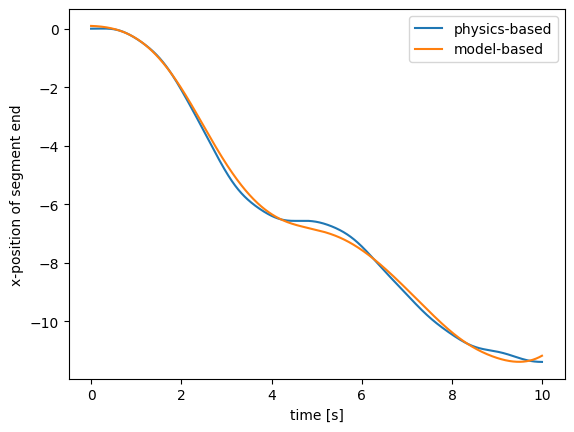

In [18]:
from cc.examples.feedforward_controller import make_feedforward_controller
from cc.env.collect import collect

controller = make_feedforward_controller(sample_train.action[0])
pred_sample, _ = collect(env_model, controller)

import matplotlib.pyplot as plt 

plt.plot(env.ts, sample_train.obs["xpos_of_segment_end"][0, :-1], label="physics-based")
plt.plot(env.ts, pred_sample.obs["xpos_of_segment_end"][0, :-1], label = "model-based")
plt.xlabel("time [s]")
plt.ylabel("x-position of segment end")
plt.legend()


In [19]:
# save model for usage in next notebook
eqx.tree_serialise_leaves("model.eqx", fitted_model)

In [20]:
# reload model
del fitted_model
fitted_model = eqx.tree_deserialise_leaves("model.eqx", model) 